In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.options.mode.chained_assignment = None  # default='warn'
import pickle
import matplotlib.pylab as plt
import tensorflow as tf
from tensorflow import keras
from keras import regularizers
from keras.layers import PReLU
#from keras_visualizer import visualizer

%matplotlib inline

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
keras.utils.set_random_seed(42)
#ata = np.array([],[], [])
def readData(): 
    dataA, dataB, dataC = [], [], []
    path = 'data/data/'
    for a in os.walk((path + 'A')):
        print("a: ", a)
        dataA.append(pd.DataFrame(pd.read_parquet(path + 'A/' + str(a[2][0]))))
        dataA.append(pd.DataFrame(pd.read_parquet(path + 'A/' + str(a[2][1]))))
        dataA.append(pd.DataFrame(pd.read_parquet(path + 'A/' + str(a[2][2]))))
        dataA.append(pd.DataFrame(pd.read_parquet(path + 'A/' + str(a[2][3]))))
        #print(dataA)
        
    for b in os.walk(path + 'B'):
        dataB.append(pd.DataFrame(pd.read_parquet(path + 'B/' + str(b[2][0]))))
        dataB.append(pd.DataFrame(pd.read_parquet(path + 'B/' + str(b[2][1]))))
        dataB.append(pd.DataFrame(pd.read_parquet(path + 'B/' + str(b[2][2]))))
        dataB.append(pd.DataFrame(pd.read_parquet(path + 'B/' + str(b[2][3]))))
        
    for c in os.walk(path + 'C'):
        dataC.append(pd.DataFrame(pd.read_parquet(path + 'C/' + str(c[2][0]))))
        dataC.append(pd.DataFrame(pd.read_parquet(path + 'C/' + str(c[2][1]))))
        dataC.append(pd.DataFrame(pd.read_parquet(path + 'C/' + str(c[2][2]))))
        dataC.append(pd.DataFrame(pd.read_parquet(path + 'C/' + str(c[2][3]))))
        
    
        
    return dataA, dataB, dataC
   # print(dataA[0])
   # print(dataB[0])
   # print(dataC[0])

A, B, C = readData()
#print(A[2])
#print(A[1])
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
#Preprocessing Functions
def splitWeatherAndEnergyReports(data):
    weather = [data[1], data[2], data[3]]
    energy = data[0]
    return weather, energy

def NanToZero(data):
    data1 = []
    for df in data: 
        df1 = df.fillna(0) #replace Nan with 0.
        data1.append(df1)    
    return data1

def quartersToHours(data):
    data1 = []
    for df in data:
        #print(df['date_forecast'].iloc[0])
        #print(df['date_forecast'].iloc[len(df)-1])
        df['date_forecast'] = df['date_forecast'].map(lambda x: str(x)[:-6])
        df_new = df.groupby(['date_forecast'], as_index=False).mean()
        df_new['date_forecast'] = df_new['date_forecast'].apply(lambda x: x + ':00:00')
        data1.append(df_new)     
    return data1

def quartersToHours2(data):
    data1 = []
    for df in data:
        #print(df['date_forecast'].iloc[0])
        #print(df['date_forecast'].iloc[len(df)-1])
        df['date_forecast'] = df['date_forecast'].map(lambda x: str(x)[:-6])
        df_new = df.groupby(['date_forecast'], as_index=False).first()
        df_new['date_forecast'] = df_new['date_forecast'].apply(lambda x: x + ':00:00')
        data1.append(df_new)   
    return data1

#Removing NaN-values from all datasets 
#A
X = pd.concat([A[3], A[2]], ignore_index = True)
X = pd.concat([X, A[1]], ignore_index = True)
#print("A: ", X.isna().sum())
#X[['date_forecast', 'ceiling_height_agl:m']].set_index('date_forecast').plot()
X['snow_density:kgm3'] = X['snow_density:kgm3'].fillna(0)
X[['ceiling_height_agl:m', 'cloud_base_agl:m']] = X[['ceiling_height_agl:m', 'cloud_base_agl:m']].interpolate(method='cubic')
#for elem in X.columns:
 #   if elem not in ['date_forecast', 'date_calc']:
        #X[['date_forecast', str(elem)]].set_index('date_forecast').plot()
  #      X[str(elem)] = X[str(elem)].to_frame().rolling(24).mean().interpolate(method='cubic').bfill()
        #X[['date_forecast', str(elem)]].set_index('date_forecast').plot()
       # X[str(elem)].drop(index=X[str(elem)].index[:30], axis=0, inplace=True)
#X = X.dropna()
#print("A2: ", X.isna().sum())
#X[['date_forecast', 'ceiling_height_agl:m']].set_index('date_forecast').plot()
#print("X: ", X)
A[3], A[2], A[1] = X[:len(A[3])], X[len(A[3]):len(A[3])+len(A[2])], X[len(A[2])+len(A[3]):]
#
#
#B
X = pd.concat([B[3], B[2]], ignore_index = True)
X = pd.concat([X, B[1]], ignore_index = True)
#print("B: ", X.isna().sum())
#X[['date_forecast', 'snow_density:kgm3']].set_index('date_forecast').plot()
X['snow_density:kgm3'] = X['snow_density:kgm3'].fillna(0)
X[['ceiling_height_agl:m', 'cloud_base_agl:m']] = X[['ceiling_height_agl:m', 'cloud_base_agl:m']].interpolate(method='cubic')
#X[['date_forecast', 'snow_density:kgm3']].set_index('date_forecast').plot()
#print("X: ", X)
B[3], B[2], B[1] = X[:len(B[3])], X[len(B[3]):len(B[3])+len(B[2])], X[len(B[2])+len(B[3]):]
#
#
#C
X = pd.concat([C[3], C[2]], ignore_index = True)
X = pd.concat([X, C[1]], ignore_index = True)
#print("C: ", X.isna().sum())
#X[['date_forecast', 'snow_density:kgm3']].set_index('date_forecast').plot()
X['snow_density:kgm3'] = X['snow_density:kgm3'].fillna(0)
X[['ceiling_height_agl:m', 'cloud_base_agl:m']] = X[['ceiling_height_agl:m', 'cloud_base_agl:m']].interpolate(method='cubic')

#X[['date_forecast', 'snow_density:kgm3']].set_index('date_forecast').plot()
#print("X: ", X)
C[3], C[2], C[1] = X[:len(C[3])], X[len(C[3]):len(C[3])+len(C[2])], X[len(C[2])+len(C[3]):]

plt.show()


#A1 = NanToZero(A)
#B1 = NanToZero(B)
#C1 = NanToZero(C)

#Splitting weather and energy datasets
weather_A, energy_A = splitWeatherAndEnergyReports(A)
weather_B, energy_B = splitWeatherAndEnergyReports(B)
weather_C, energy_C = splitWeatherAndEnergyReports(C)
#weather_A[1][['date_forecast', 'cloud_base_agl:m']].set_index('date_forecast').plot()

#testr = weather_A.copy()
#group weather-measures from same hour. 
#E.g. [2019-06-02 22:00:00, 2019-06-02 22:15:00, 2019-06-02 22:30:00, 2019-06-02 22:45:00] -> 2019-06-02 22:00:00
weather_A1 = quartersToHours(weather_A)
weather_B1 = quartersToHours(weather_B)
weather_C1 = quartersToHours(weather_C)





a:  ('data/data/A', [], ['train_targets.parquet', 'X_test_estimated.parquet', 'X_train_estimated.parquet', 'X_train_observed.parquet'])


C:\Users\matse\AppData\Local\Temp\ipykernel_5580\4215552503.py:79: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_new = df.groupby(['date_forecast'], as_index=False).mean()
C:\Users\matse\AppData\Local\Temp\ipykernel_5580\4215552503.py:79: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_new = df.groupby(['date_forecast'], as_index=False).mean()
C:\Users\matse\AppData\Local\Temp\ipykernel_5580\4215552503.py:79: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns 

time                 0
pv_measurement    7020
dtype: int64

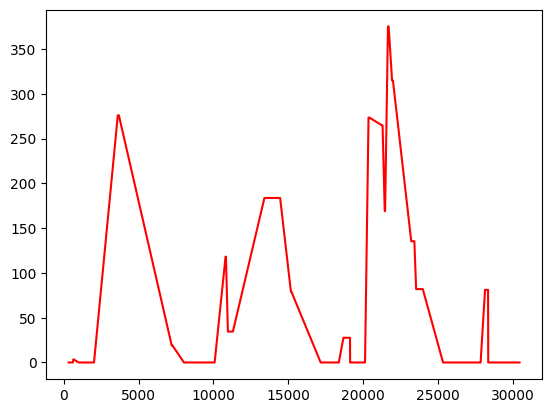

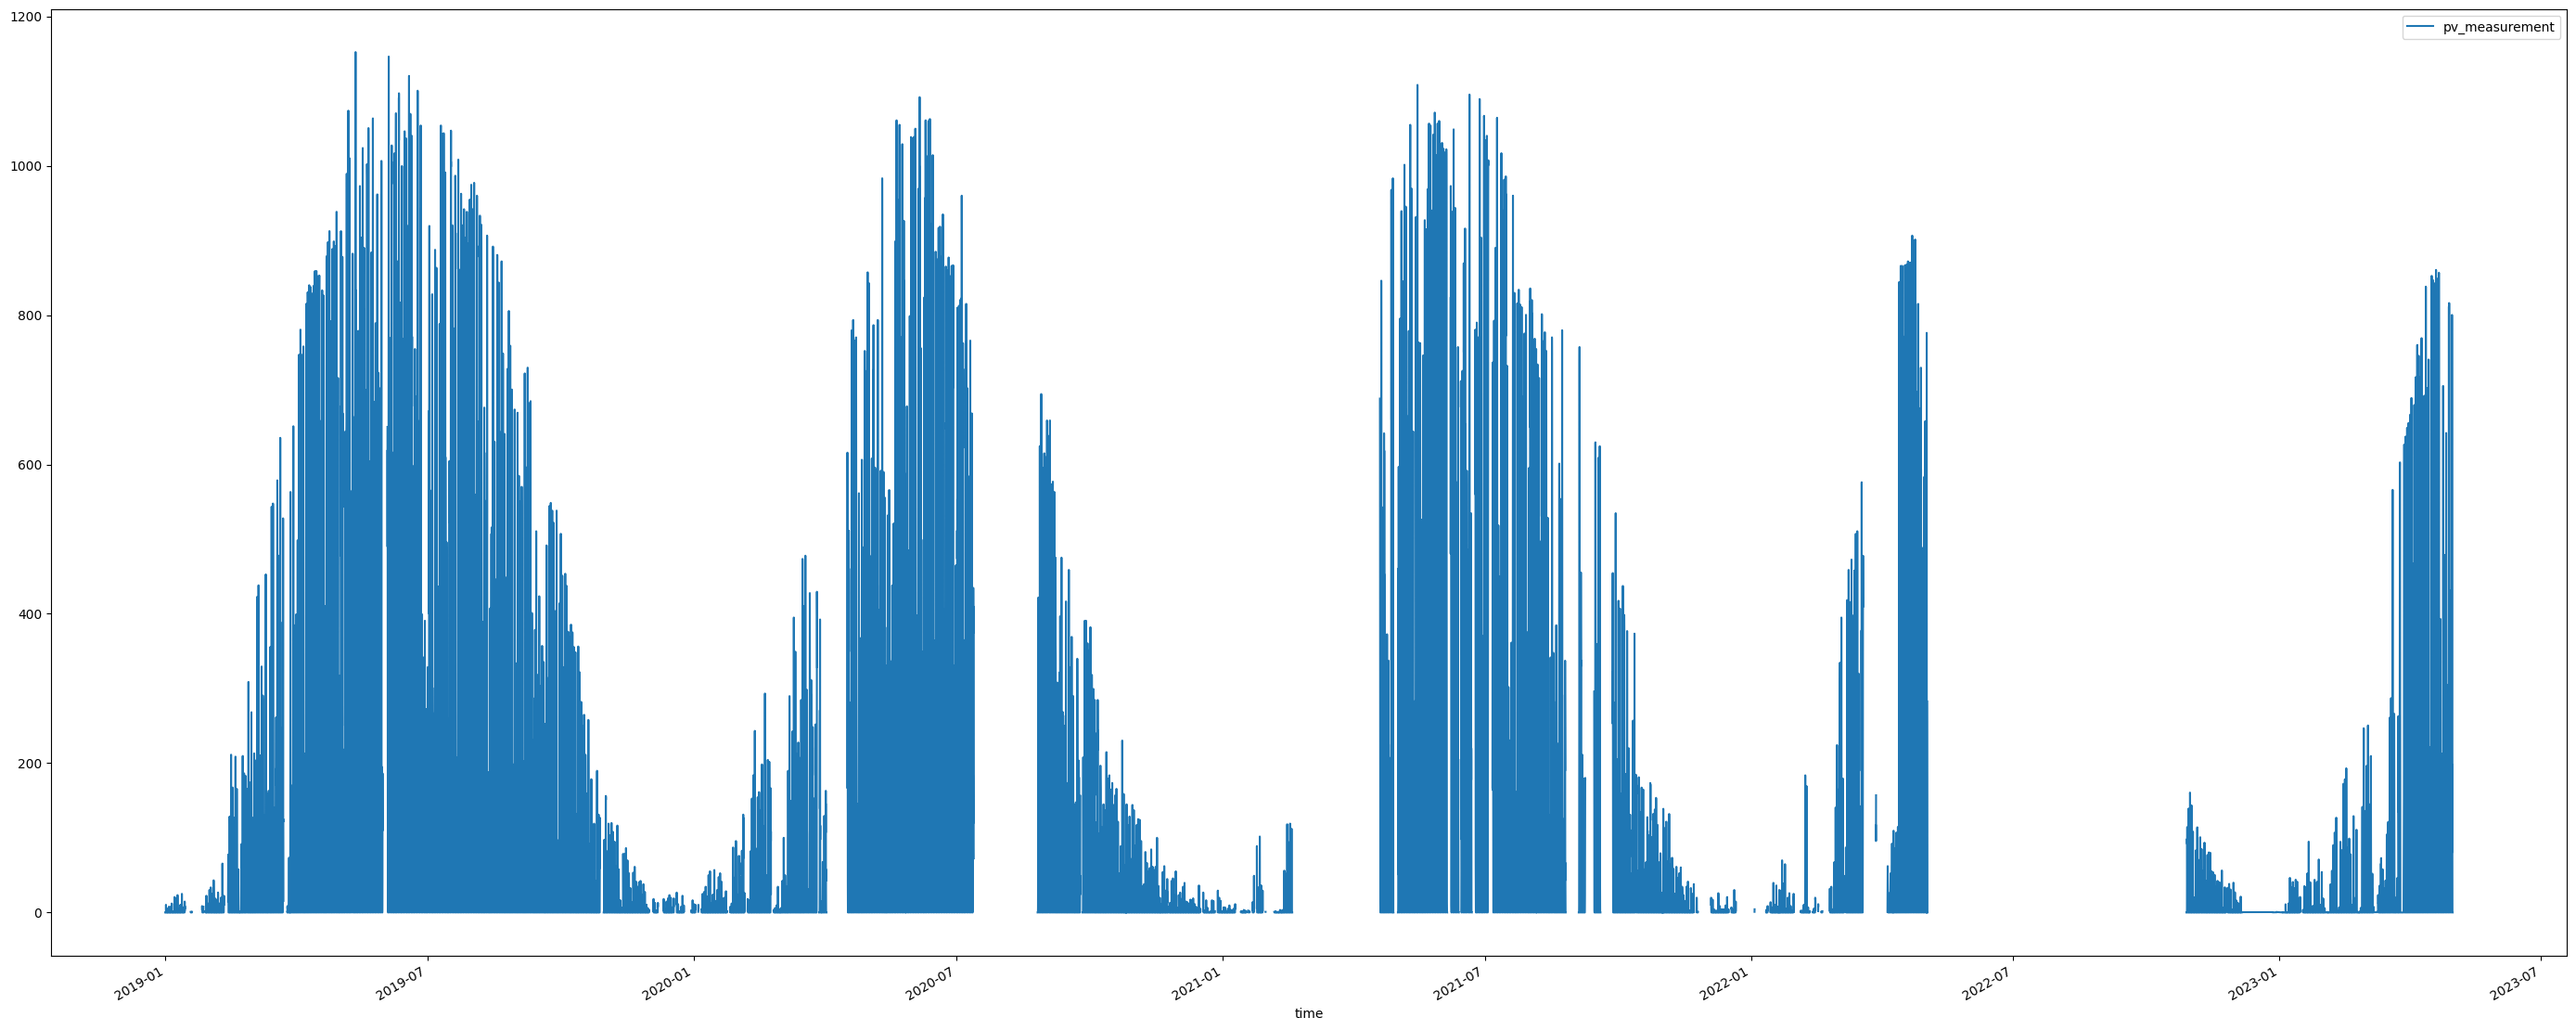

In [2]:
#B - Removing Nan-rows (w/resepct to Nan-values in target set)

energy_B['flag'] = energy_B['pv_measurement'].groupby([energy_B['pv_measurement'], energy_B['pv_measurement'].diff().ne(0).cumsum()]).transform('size').ge(24).astype(int) 
#energy_B['pv_measurement'].plot(figsize=(35,15))
energy_B.loc[energy_B['flag'] == 1]['pv_measurement'].plot(color='red')
energy_B.loc[energy_B['flag'] == 1, 'pv_measurement'] = None
#print("huh; ", energy_B.loc[energy_B['flag'] == 1, 'pv_measurement'])
energy_B[['time', 'pv_measurement']].set_index('time').plot(figsize=(35,15))
energy_B = energy_B.drop(['flag'], axis=1)
energy_B.isna().sum()


In [3]:
#Split data into appropriate subsets, & make it so they have same dimensions.
def splitData(data_train, data_test, labels):
    #print("data: ", data)
    print("Labels: ", labels['time'])
    train_endDate = str(data_train['date_forecast'][len(data_train)-1])
    print("tr: ", train_endDate)
    train_x_end = data_train.index[data_train['date_forecast'] == '2022-10-21 00:00:00' ][0] 
    train_y_end = labels.index[labels['time'] == '2022-10-21 00:00:00' ][0] 
    
    test_startDate = str(data_test['date_forecast'][0])
    test_x_start = data_test.index[data_test['date_forecast'] == '2022-10-28 22:00:00' ][0] #
    test_y_start = labels.index[labels['time'] == '2022-10-28 22:00:00' ][0] #
    print("indexT: ", test_x_start)
    
    train_x = data_train.iloc[:train_x_end]
    train_y = labels.iloc[:train_y_end]
        
    test_x = data_test.iloc[test_x_start:]
    test_y = labels.iloc[test_y_start:]
    
    X = pd.concat([train_x, test_x], ignore_index = True)
    Y = pd.concat([train_y, test_y], ignore_index = True)
    
    
    return X, Y



def findGap(test_x, test_y):
    #gapfound = False
    #print("merge: ", pd.merge(test_x, test_y))
    test_y1 = test_y.copy()
    test_x1 = test_x.copy()
    for i in range(len(test_y)): 
        if str(test_x.iloc[i]['date_forecast']) != str(test_y.iloc[i]['time']): 
            #print("test: ", str(test_y.iloc[i]['time'])[0:10])
            print(test_x.iloc[i]['date_forecast'])
            #print(test_x.iloc[i-1]['date_forecast'])
            print(test_y.iloc[i]['time'])
            print("-------------------------------------")
            #if (len(test_x) - (len(test_x) - )
            #test_y1 = dropDate(test_y, 'time', )
            

def dropDate(df, column, date):
    new_df = df
    for i in range(len(df)):
        #print(str(df.iloc[i][column]))
        if str(df.iloc[i][column])[0:10] == date:
            #print("okiii")
            new_df = new_df.drop(index=df.iloc[i].name)
    
    return new_df
    #FOUND GAP: weather-prediction-dataset doesn't have prediction for: 2023-01-26 
    # solution: drop this date from labels.

def alignData(x_train, x_test, y):     
    X = pd.concat([x_train, x_test], ignore_index = True)
    y = y.rename(columns={'time': 'date_forecast'})
    y['date_forecast'] = y['date_forecast'].astype(str)
    aligned = X.merge(y, how='inner', on=['date_forecast'])

    X = aligned.drop(['pv_measurement'], axis=1)
    Y = aligned['pv_measurement']
    return X, Y

def alignData2(x_train, x_test, y):     
    X = pd.concat([x_train, x_test], ignore_index = True)
    y = y.rename(columns={'time': 'date_forecast'})
    y['date_forecast'] = y['date_forecast'].astype(str)
    aligned = X.merge(y, how='inner', on=['date_forecast'])
    return aligned


def dropNanrows(df):
    return df.dropna()

# Parameters:(weather_A[2] = train_x_observed, weather_A1[2] = x_train_estimated, energy_A = train_targets)
energy_A['pv_measurement'] = energy_A['pv_measurement'].abs()

#energy_B['pv_measurement'] = energy_B['pv_measurement'].loc[energy_B['pv_measurement'].shift(100) != energy_B['pv_measurement']]
#energy_B['pv_measurement']= energy_B['pv_measurement'].replace(np.NaN, energy_B['pv_measurement'].mean())
energy_B  = dropNanrows(energy_B)
#energy_B['pv_measurement'] = energy_B['pv_measurement'].abs()

energy_C = dropNanrows(energy_C)
energy_C['pv_measurement'] = energy_C['pv_measurement'].abs()

#print("ba: ", len(energy_B))
#print("ca: ", len(energy_C))


In [4]:
print(weather_A1[2]['date_forecast'])
print(weather_A1[1]['date_forecast'])
print(weather_A1[0]['date_forecast'])

0        2019-06-02 22:00:00
1        2019-06-02 23:00:00
2        2019-06-03 00:00:00
3        2019-06-03 01:00:00
4        2019-06-03 02:00:00
                ...         
29663    2022-10-20 21:00:00
29664    2022-10-20 22:00:00
29665    2022-10-20 23:00:00
29666    2022-10-21 00:00:00
29667    2022-10-21 01:00:00
Name: date_forecast, Length: 29668, dtype: object
0       2022-10-28 22:00:00
1       2022-10-28 23:00:00
2       2022-10-29 00:00:00
3       2022-10-29 01:00:00
4       2022-10-29 02:00:00
               ...         
4389    2023-04-30 19:00:00
4390    2023-04-30 20:00:00
4391    2023-04-30 21:00:00
4392    2023-04-30 22:00:00
4393    2023-04-30 23:00:00
Name: date_forecast, Length: 4394, dtype: object
0      2023-05-01 00:00:00
1      2023-05-01 01:00:00
2      2023-05-01 02:00:00
3      2023-05-01 03:00:00
4      2023-05-01 04:00:00
              ...         
715    2023-07-03 19:00:00
716    2023-07-03 20:00:00
717    2023-07-03 21:00:00
718    2023-07-03 22:00:00
719 

In [5]:
#For CNN & Feedforward
#A-BLOCK
X_A, Y_A = alignData(weather_A1[2], weather_A1[1], energy_A) 
testData_A = weather_A1[0] 

#B-BLOCK
X_B, Y_B = alignData(weather_B1[2], weather_B1[1], energy_B)
testData_B = weather_B1[0]
print(X_B.iloc[0])

#C-BLOCK
X_C, Y_C = alignData(weather_C1[2], weather_C1[1], energy_C)
print(Y_C)
testData_C = weather_C1[0]


#debug-function for finding rows not equal in x&y datasets.
#findGap(X, Y)
        

date_forecast                     2019-01-01 00:00:00
absolute_humidity_2m:gm3                        5.525
air_density_2m:kgm3                           1.23975
ceiling_height_agl:m                      1200.675049
clear_sky_energy_1h:J                             0.0
clear_sky_rad:W                                   0.0
cloud_base_agl:m                          1200.675049
dew_or_rime:idx                                   0.0
dew_point_2m:K                             275.149994
diffuse_rad:W                                     0.0
diffuse_rad_1h:J                                  0.0
direct_rad:W                                      0.0
direct_rad_1h:J                                   0.0
effective_cloud_cover:p                     81.824997
elevation:m                                       7.0
fresh_snow_12h:cm                                 0.0
fresh_snow_1h:cm                                  0.0
fresh_snow_24h:cm                                 0.0
fresh_snow_3h:cm            

In [6]:
#CHECKING IF MAX AND MIN VALUES IN FEATURES IS IN TRAINING DATA. IT IS!
for column in X_A.columns:
    print("AAAAAAAAAAAAAAAAA")
    print(X_A[str(column)].max(), " VS ", testData_A[str(column)].max())
    print(X_A[str(column)].min(), " VS ", testData_A[str(column)].min())
    print("---------------------------------")
for column in X_B.columns:
    print("AAAAAAAAAAAAAAAAA")
    print(X_B[str(column)].max(), " VS ", testData_B[str(column)].max())
    print(X_B[str(column)].min(), " VS ", testData_B[str(column)].min())
    print("---------------------------------")
for column in X_C.columns:
    print("AAAAAAAAAAAAAAAAA")
    print(X_C[str(column)].max(), " VS ", testData_C[str(column)].max())
    print(X_C[str(column)].min(), " VS ", testData_C[str(column)].min())
    print("---------------------------------")



AAAAAAAAAAAAAAAAA
2023-04-30 23:00:00  VS  2023-07-03 23:00:00
2019-06-02 22:00:00  VS  2023-05-01 00:00:00
---------------------------------
AAAAAAAAAAAAAAAAA
17.35  VS  13.675
0.7  VS  3.2
---------------------------------
AAAAAAAAAAAAAAAAA
1.42625  VS  1.29975
1.145  VS  1.151
---------------------------------
AAAAAAAAAAAAAAAAA
12294.9  VS  11671.355
-297.01685  VS  53.3
---------------------------------
AAAAAAAAAAAAAAAAA
2988627.5  VS  2987530.2
0.0  VS  0.0
---------------------------------
AAAAAAAAAAAAAAAAA
835.1  VS  834.95
0.0  VS  0.0
---------------------------------
AAAAAAAAAAAAAAAAA
11673.625  VS  11256.7
-149.32074  VS  30.225
---------------------------------
AAAAAAAAAAAAAAAAA
1.0  VS  1.0
-1.0  VS  0.0
---------------------------------
AAAAAAAAAAAAAAAAA
293.625  VS  289.55
251.075  VS  268.1
---------------------------------
AAAAAAAAAAAAAAAAA
332.275  VS  307.5
0.0  VS  0.0
---------------------------------
AAAAAAAAAAAAAAAAA
1191085.2  VS  1098738.5
0.0  VS  0.0
--------

<Axes: >

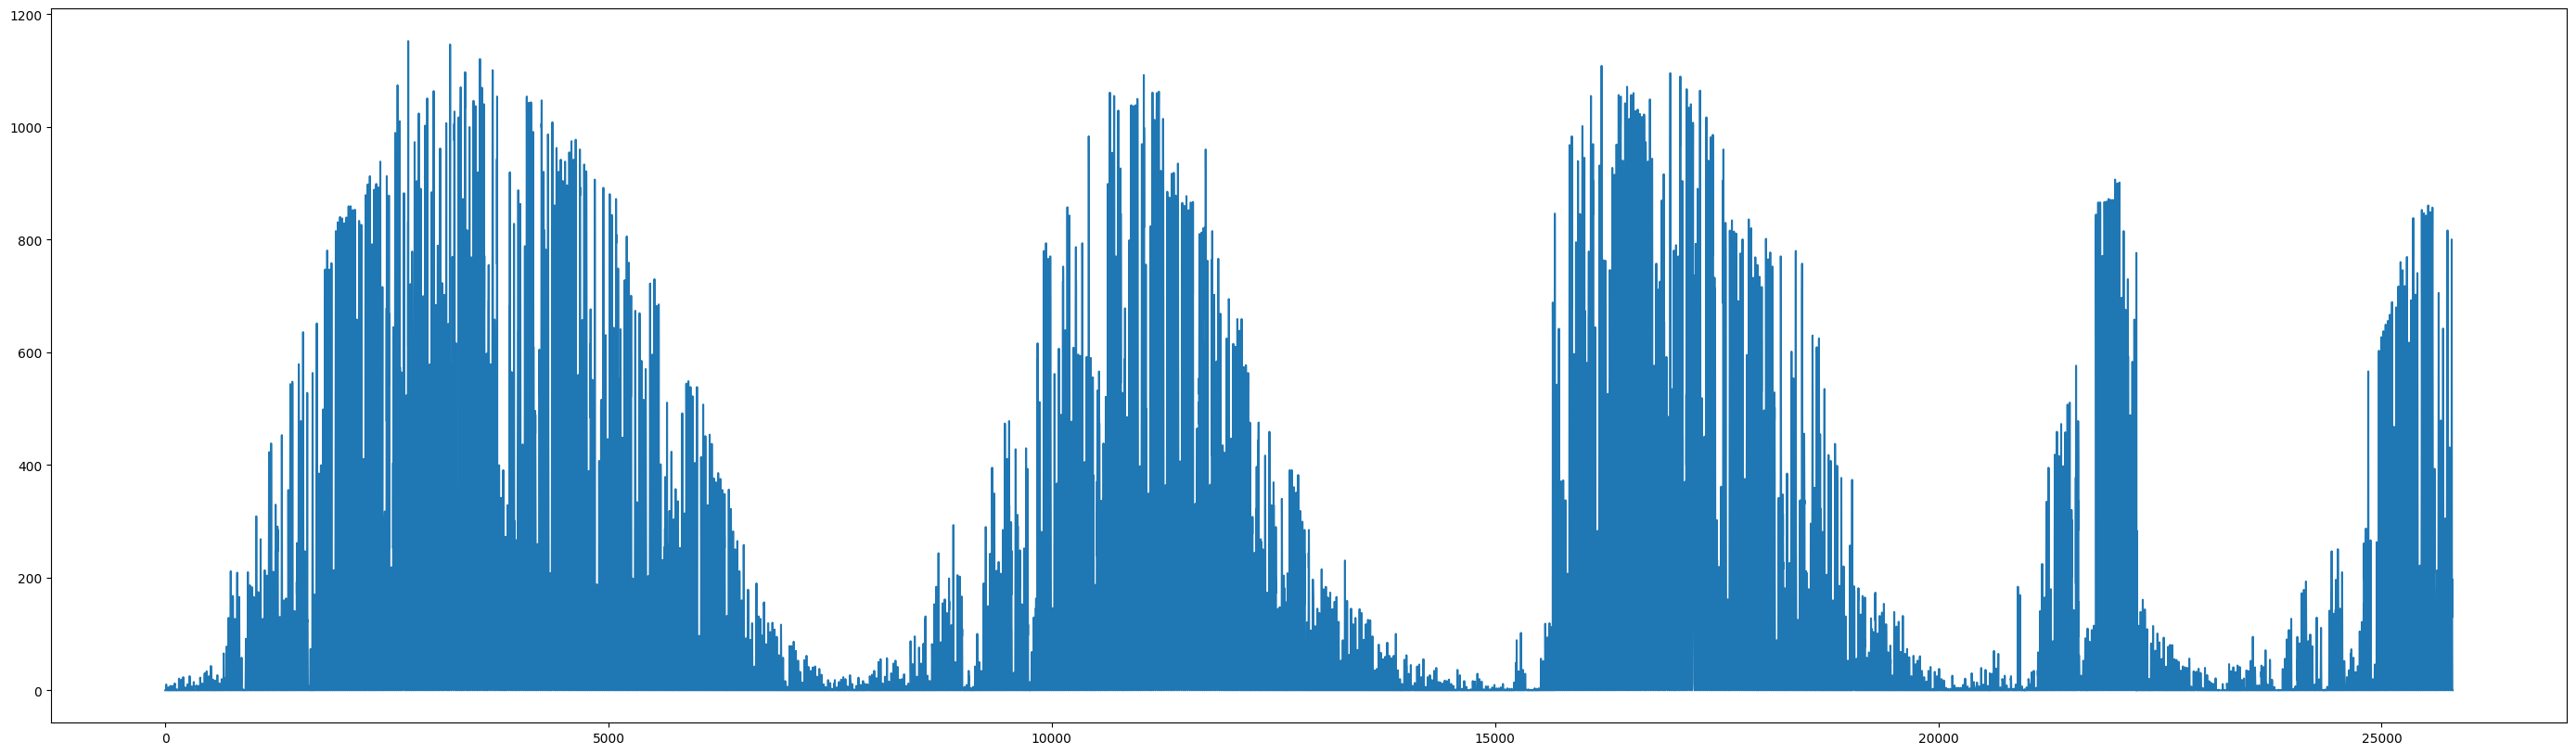

In [7]:
Y_B.plot(figsize=(35,10))

In [8]:
#HEATMAP
def show_heatmap(data):
    plt.matshow(data.corr())
    plt.xticks(range(data.shape[1]), data.columns, fontsize=14, rotation=90)
    plt.gca().xaxis.tick_bottom()
    plt.yticks(range(data.shape[1]), data.columns, fontsize=14)

    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title("Feature Correlation Heatmap", fontsize=14)
    plt.show()


#show_heatmap(X_A)

In [9]:
#more preprocessing
    

def normalizeValues(train_x, test_x):
    #Standardizing
    #train_x = train_x.apply(lambda iterator: ((iterator - iterator.mean())/iterator.std()))
    #test_x = test_x.apply(lambda iterator: ((iterator - iterator.mean())/iterator.std()))
    
    #Ranging all values in column between (0, 1)
    train_x = train_x.apply(lambda iterator: ((iterator.max() - iterator)/(iterator.max() - iterator.min())))
    test_x = test_x.apply(lambda iterator: ((iterator.max() - iterator)/(iterator.max() - iterator.min())))
    
    return train_x, test_x

#def standardizeValues(train_x, test_x):
  
    
def lookAtFeatures(data): 
    for col in data:
        print("Feature: ", col)
        print("max: ", data[col].max())
        print("min: ", data[col].min())
        print("mean: ", data[col].mean())
        print("number of uniqueValues: ", len(data[col].unique()))
        print("---------------------------------------------------")           
              

def dropConstants(data):
    data = data.loc[:, (data != data.iloc[0]).any()]
    return data
        
def dateToFreq2(d):
    date_time = pd.to_datetime(d['date_forecast'])
    timestamp_s = date_time.map(pd.Timestamp.timestamp)
    day = 24*60*60
    year = (365.2425)*day


    d['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
    d['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
    d['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
    d['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

    plt.plot(np.array(d['Year sin']))
    plt.plot(np.array(d['Year cos']))
    #plt.plot(np.array(test['Day sin'])[:25])
    #plt.plot(np.array(test['Day cos'])[:25])
    #plt.xlabel('Time [h]')
    #plt.title('Time of day signal')
    return d
def saveData(data, filename):
    filepath = 'data/preprocessed/' + filename + '.csv'
    #PHD_STIPENDS = pd.read_csv('/kaggle/input/phd-stipends/csv') # load from notebook input
    data.to_csv(filepath, index=False) # save to notebook output

def retriveData(filename):
    filepath = 'data/preprocessed/' + filename + '.csv'
    data = pd.read_csv(filepath) # load from notebook input
    return data

#Preprocessing TODO
# - Endre flere fatures til frekvenser
# - Endre behandling av NaN-verdier. F.eks endre til verdien til foregående eksempel (DONE)
# - Se korrelanse mellom energiProd og hvert enkelt feature <-- & evt. bytte ut removeConstants() m/funn herfra.
# - Kombiner modeller til ensembleModell.
#   -Implementere konfidens/konfidensintervall(?) til hver enkelt prediksjon, så blir pred til modeller vektet m/det.
# -Sjekk ut duppen i testData, typ indentisk i alle blokkene

def featureFilter(x, t, labels):
    y_t = pd.DataFrame(labels) 
    test = pd.concat([x.copy(), t], ignore_index = True)
    dc = []
    for elem in test.columns:
    # test['date_forecast'] = test['date_forecast']
        # print(elem)
        # print(Y_A)
        if str(elem) != 'date_forecast':
        #test = test.drop('date_forecast', axis=0)
            #print('feature')
            if abs(test[str(elem)].corr(y_t['pv_measurement'])) < 0.06: 
                dc.append(str(elem))
            print(f"{elem} correlanse: ", test[str(elem)].corr(y_t['pv_measurement']))
            plot = pd.concat([test[str(elem)], ])
            #huh = test.copy()
            test[['date_forecast', str(elem)]].set_index('date_forecast').plot.line()
            #huh[str(elem)].copy().to_frame().rolling(24).mean().plot.line()
            #print('Y')
            #y_t[ 'pv_measurement'][:1000].plot.line()
            #plt.legend([ "op = 1", "op = 0.5"]) 
            #plt.show()
    
    
    return dc

def denormalizeAll(tr, te, minmax):
    all = pd.concat([tr, te], ignore_index = True)
    cols = all.columns
    print(len(minmax))
    print(len(cols))
    for i in range(len(minmax)):
        all.iloc[i] = all.iloc[i] * (minmax[i][1] - minmax[i][0]) + minmax[i][0]
    return all[:len(tr)], all[len(tr):]


from statsmodels.tsa.seasonal import seasonal_decompose
def deseasonalize(tr, te):
    all = pd.concat([tr, te], ignore_index = True)
    for col in all.columns:
        decomposition = seasonal_decompose(all[str(col)], model='additive', period=24)
        all[str(col)] = all[str(col)] - decomposition.seasonal
    return all[:len(tr)], all[len(tr):] 



#USELESS
#drop_columns = featureFilter(X_A, testData_A, Y_A)
#print(drop_columns)


<Axes: >

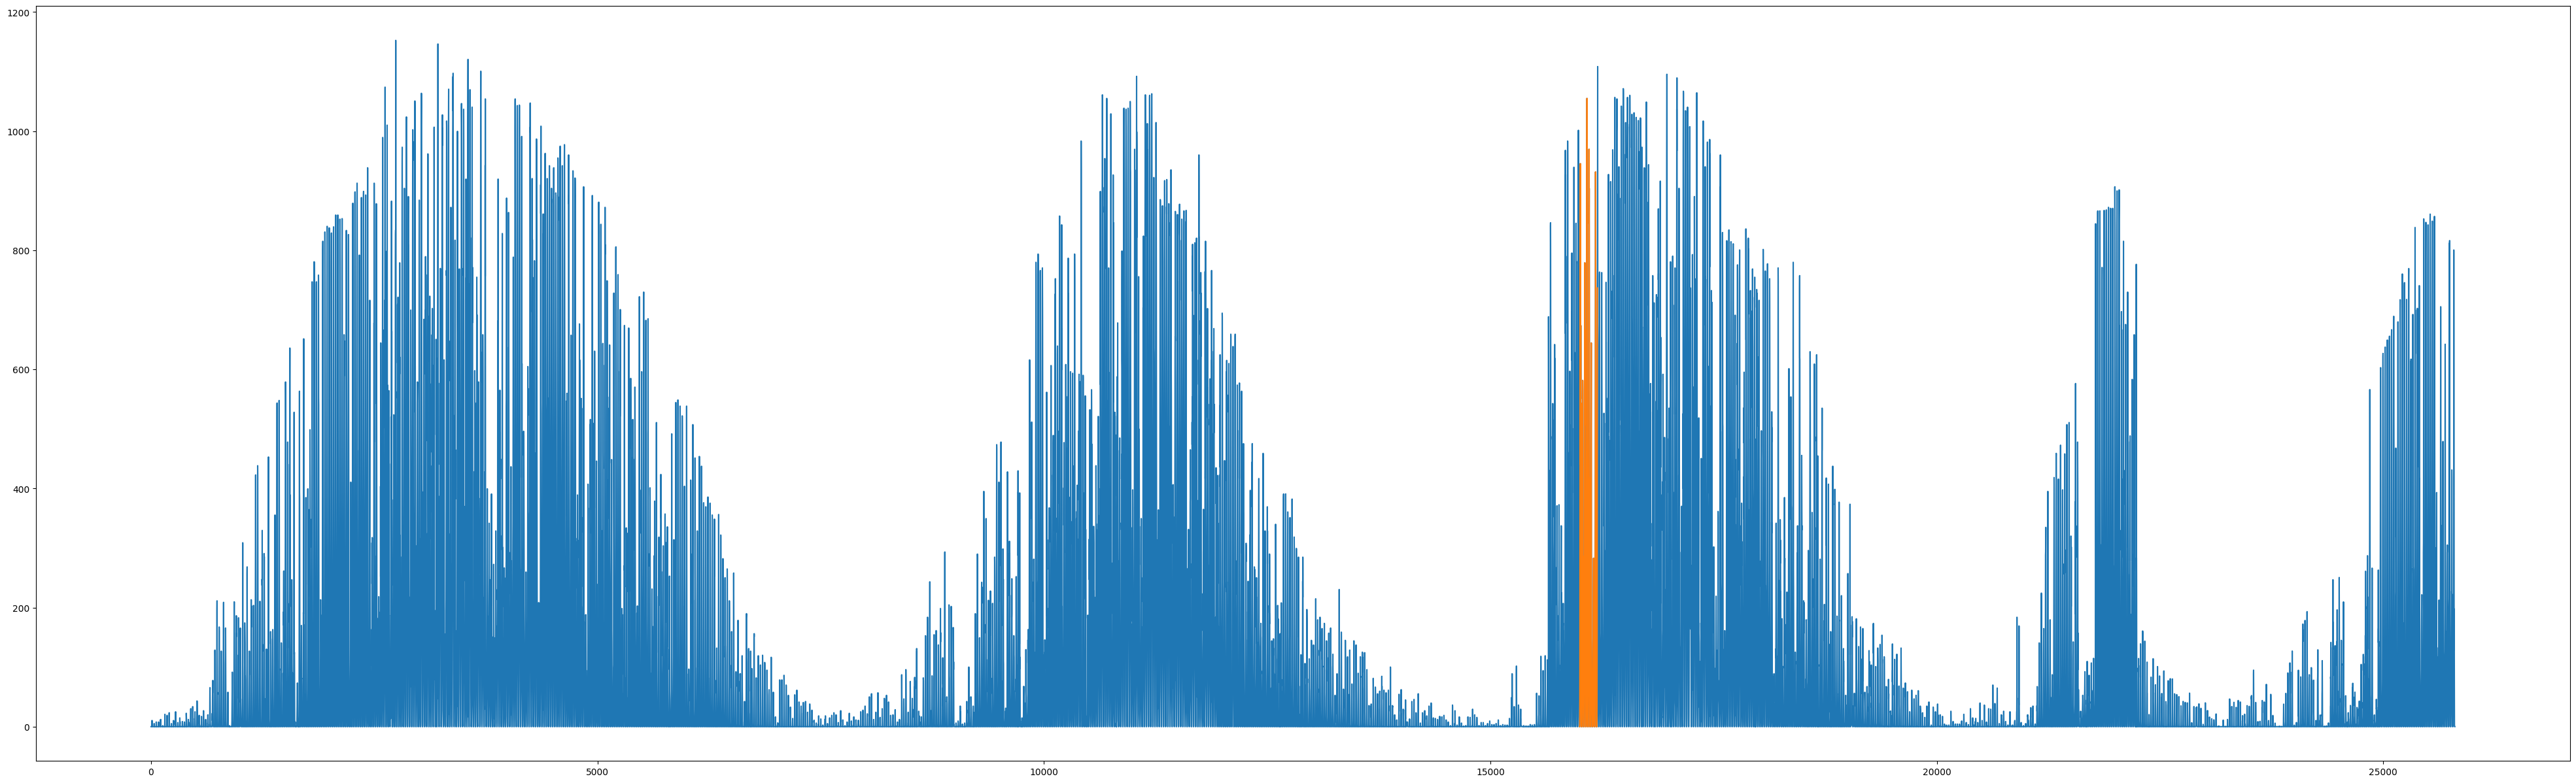

In [10]:
Y_B.plot(figsize=(50,15))
Y_B[16000:16200].plot(figsize=(50,15))
#print(X_B['date_forecast'][16000:16200])

In [11]:
#FAST FOURIER TRANSFORM ON FEATURE-SIGNALS
from scipy.fft import fft, rfft
from scipy.fft import fftfreq, rfftfreq
import pywt
from pywt import swt, dwt, wavedec




In [12]:
#Preprocessing functions (currently in use)
from sklearn.model_selection import train_test_split

def normalizeAll(tr, te):
    all = pd.concat([tr, te], ignore_index = True)
    #minmax = [(all[str(col)].min(), all[str(col)].max()) for col in all.columns]
    all = all.apply(lambda iterator: ((iterator.max() - iterator)/(iterator.max() - iterator.min())))
    return all[:len(tr)], all[len(tr):]


def dataSplits(X_tree, X_NN, Y, td_tree, td_NN, splitIndex):
    X_tr_trees = X_tree.iloc[:splitIndex]
    X_te_trees = X_tree.iloc[splitIndex:]

    X_tr_NN = X_NN.iloc[:splitIndex]
    X_te_NN = X_NN.iloc[splitIndex:]

    Y_tr = Y.iloc[:splitIndex]
    Y_te = Y.iloc[splitIndex:]


    return X_tr_trees, X_te_trees, X_tr_NN, X_te_NN, Y_tr, Y_te, td_tree, td_NN

def dataSplit2(X_tree, X_NN, Y, td_tree, td_NN, splitRatio):
        X_tree['Y'] = pd.DataFrame(Y)['pv_measurement']
        tr_trees, te_trees = train_test_split(X_tree, test_size=splitRatio)
        
        Y_tr_trees = tr_trees['Y']
        Y_te_trees = te_trees['Y']

        tr_trees.drop(['Y'], axis=1, inplace=True)
        te_trees.drop(['Y'], axis=1, inplace=True)

        X_NN['Y'] = pd.DataFrame(Y)['pv_measurement']
        tr_NN, te_NN = train_test_split(X_NN, test_size=splitRatio)
        
        Y_tr_NN = tr_NN['Y']
        Y_te_NN = te_NN['Y']

        tr_NN.drop(['Y'], axis=1, inplace=True)
        te_NN.drop(['Y'], axis=1, inplace=True)

        return tr_trees, te_trees, tr_NN, te_NN, Y_tr_trees, Y_te_trees, Y_tr_NN, Y_te_NN, td_tree, td_NN

def dateToFreq(data_tr, data_te):
    test = pd.concat([data_tr, data_te], ignore_index = True)
    date_time = pd.to_datetime(test['date_forecast'])
    timestamp_s = date_time.map(pd.Timestamp.timestamp)
    day = 24*60*60
    year = (365.2425)*day


    test['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
    test['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
    test['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
    test['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

    #plt.plot(np.array(test['Year sin']))
    #plt.plot(np.array(test['Year cos']))
    #plt.plot(np.array(test['Day sin'])[:25])
    #plt.plot(np.array(test['Day cos'])[:25])
    #plt.xlabel('Time [h]')
    #plt.title('Time of day signal')
    tr, te = test.iloc[:len(data_tr)], test.iloc[len(data_tr):]

    return tr, te

def add_times(tr, te):
    all = pd.concat([tr, te], ignore_index = True) 
    #train_y["Year"] = [train_y.iloc[i]["time"].year for i in range(len(train_y))]
    #train_y["Month"] = [train_y.iloc[m]["time"].month for m in range(len(train_y))]
    
    #test_y["Year"] = [test_y.iloc[i]["time"].year for i in range(len(test_y))]
    #test_y["Month"] = [test_y.iloc[m]["time"].month for m in range(len(test_y))]
    
    all["Hour"] = [int(all.iloc[i]['date_forecast'][11:13]) for i in range(len(all))]
    all["Month"] = [int(all.iloc[i]['date_forecast'][5:7]) for i in range(len(all))]
    all["Year"] = [int(all.iloc[i]['date_forecast'][0:4]) for i in range(len(all))]
    all["Day"] = [int(all.iloc[i]['date_forecast'][8:10]) for i in range(len(all))]
    all['Week'] = pd.to_datetime(all['date_forecast']).dt.isocalendar().week.astype(float)
    return all[:len(tr)], all[len(tr):] 
   
def removeDates(X):
    X = X.drop(['date_forecast'], axis=1)
    return X

def removeColumns(df, columns): 
    return df.drop(columns, axis=1)  

def flag(tr, te, splitIndex):
    data_observed = tr.iloc[:splitIndex]
    data_estimated = tr.iloc[splitIndex:]
    
    data_observed['flag'] = 1
    data_estimated['flag'] = 0
    te['flag'] = 0

    return pd.concat([data_observed, data_estimated], ignore_index = True), te


def createFeatures(tr, te,): #ALL CREATED FEATURES BY NOW PROVIDES BETTER SCORE
    all = pd.concat([tr, te], ignore_index = True)
    top5 = ['absolute_humidity_2m:gm3', 'ceiling_height_agl:m', 'air_density_2m:kgm3', 'cloud_base_agl:m', 'sun_azimuth:d'] 
    seenKombos = []
    toCombine = [('effective_cloud_cover:p', 'clear_sky_energy_1h:J')]
    for elem in top5:
        for elem2 in top5:
            if {elem, elem2} not in seenKombos:
               seenKombos.append({elem, elem2})
               if elem != elem2:
                    toCombine.append((str(elem), str(elem2)))
    toClose = []
    for col in all.copy().columns:
        for col2 in all.copy().columns:
            if {str(col), str(col2)} not in seenKombos:
                seenKombos.append({str(col), str(col2)})
                if col != col2:
                    if abs(all[str(col)].corr(all[str(col2)])) >= 0.8:
                        #print(str(col), "--" ,str(col2))
                        #print("---------------------------------")
                        if str(col)[:4] == str(col2)[:4]:
                            toClose.append((str(col), str(col2)))
                        elif str(col) in top5 or str(col2) in top5:
                            toCombine.append((str(col), str(col2)))
                        #all[str(feature)] = all[str(col)] * all[str(col2)]
                            
    print("toCL: ", toClose)
    print("toComb: ", toCombine)
    print("------------------------")
    created = []
    for i in range(len(toCombine)):
        all[toCombine[i][0] + '_' + toCombine[i][1]] = all[toCombine[i][0]] * all[toCombine[i][1]]
        created.append(toCombine[i][0] + '_' + toCombine[i][1])
    return all[:len(tr)], all[len(tr):], created 

In [13]:
#TODO

#Få Domain-knowledge og kombiner bla.: (DONE) <-- se over og muligens vær mer selektiv, mao. håndplukk kombinasjoner hvor partene ikke er like værtyper(?)
    #Clear sky energy
    #radiation
    #wind
    #Humidity
    #Air pressure


#Test ut:
#CATBOOST-MODEL

#USE VALIDATION SET EQUAL IN SEASONALITY. mao. evaluer modellen med data fra samme sesong som submission-data er på.
    # Weighted sum istedenfor average. 

#FLAG ESTIMATED VS. OBSERVED weather. Mao. legg til et feature hvor observert vær har 1 og estimert har 0. (DONE)


#TODO

#COMBINE WIND AND CLOUD COVER
#EFFECTIVE CLOUD COVER, CLEAR SKY ENERGY

#TRAIN MODEL ON ORIGINAL, FIND 5 MOST IMPORTANT FEATURES, THEN CREATE NEW FEATURES W/THOSE THAT HAS HIGH CORR TO TOP 5

#REMOVE NORMALIZATION FOR TREE-MODELS

#RECALIBRATE WEIGHTS FOR ENSEMBLE 

#SNS.PAIRGRID

#AUTOML- H2O




In [14]:
# import seaborn as sns
# g = sns.PairGrid(X_A, diag_sharey=False)
# g.map(sns.kdeplot)

In [15]:
#FINDING CORRELAtion BETWEEN FEATURES

# absolute_humidity_2m:gm3
# ceiling_height_agl:m
# air_density
# cloud_base_agl:m
# sun_azimuth:d
corr = X_A.corr()
corr.style.background_gradient(cmap='coolwarm')
# 'RdBu_r', 'BrBG_r', & PuOr_r are other good diverging colormaps

C:\Users\matse\AppData\Local\Temp\ipykernel_5580\2685648175.py:8: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = X_A.corr()
c:\Users\matse\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\io\formats\style.py:3931: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
c:\Users\matse\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\io\formats\style.py:3932: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


In [16]:
import seaborn
import matplotlib.pyplot as plt
def see(X, Y):
    print(X)
    stone = pd.concat([X, Y], ignore_index = True)
    # PairGrid object with hue
    graph = seaborn.PairGrid(stone)
    # type of graph for non-diagonal(upper part)
    graph = graph.map_upper(seaborn.scatterplot)
    # type of graph for non-diagonal(lower part)
    graph = graph.map_lower(seaborn.kdeplot)
    # type of graph for diagonal
    graph = graph.map_diag(seaborn.kdeplot, lw = 2)
    # to show
    plt.show()

In [17]:
#see(X_A, Y_A)
#see(test, test_Y)


In [18]:
from sklearn.model_selection import train_test_split
#TRAININGDATA A

splitIndex_A = X_A.index[X_A['date_forecast'] == '2022-10-28 22:00:00'][0]

#Creating flag feature to differantiate between observed & estimated weater-data
X_A, testData_A = flag(X_A, testData_A, splitIndex_A) #Observed data

X_A, testData_A = add_times(X_A, testData_A)

# see(X_A, _A)
testData_A = removeDates(testData_A)
#testData_A.drop(['elevation:m'], axis=1, inplace=True)

X_A = removeColumns(X_A, X_A.columns.difference(testData_A.columns))  #Fitting trainingData to useful Features in testData
#X_A, testData_A = deseasonalize(X_A.copy(), testData_A.copy())
#X_A, testData_A = normalizeAll(X_A, testData_A)
X_A, testData_A, created = createFeatures(X_A, testData_A)
# for c in range(len(created)):
#     print(created)[c]
#print(X_A.columns)
X_A_neuralNets, testData_A_neuralNets = normalizeAll(X_A.copy(), testData_A.copy())
#X_A_neuralNets, testData_A_neuralNets = X_A.copy, testData_A.copy()
#X_A, testData_A = denormalizeAll(X_A, testData_A, minmax)
#X_A_tr_trees, X_A_te_trees, X_A_tr_NN, X_A_te_NN, Y_A_tr, Y_A_te, testData_A_tree, testData_A_NN = dataSplits(X_A, X_A_neuralNets, Y_A, testData_A,
#                                                                                                             testData_A_neuralNets, splitIndex_A)

X_A_tr_trees, X_A_te_trees,  X_A_tr_NN, X_A_te_NN, Y_A_tr_trees, Y_A_te_trees, Y_A_tr_NN, Y_A_te_NN, testData_A_tree, testData_A_NN = dataSplit2(X_A, X_A_neuralNets, Y_A, testData_A, 
                                                                                                                          testData_A_neuralNets, 0.15)

#Features to remove 
X_A_tr_trees.drop(['absolute_humidity_2m:gm3_ceiling_height_agl:m', 'absolute_humidity_2m:gm3_dew_point_2m:K', 'absolute_humidity_2m:gm3_t_1000hPa:K'], axis=1, inplace=True)
X_A_te_trees.drop(['absolute_humidity_2m:gm3_ceiling_height_agl:m', 'absolute_humidity_2m:gm3_dew_point_2m:K', 'absolute_humidity_2m:gm3_t_1000hPa:K'], axis=1, inplace=True)
X_A_tr_NN.drop(['absolute_humidity_2m:gm3_ceiling_height_agl:m', 'absolute_humidity_2m:gm3_dew_point_2m:K', 'absolute_humidity_2m:gm3_t_1000hPa:K'], axis=1, inplace=True)
X_A_te_NN.drop(['absolute_humidity_2m:gm3_ceiling_height_agl:m', 'absolute_humidity_2m:gm3_dew_point_2m:K', 'absolute_humidity_2m:gm3_t_1000hPa:K'], axis=1, inplace=True)
testData_A_tree.drop(['absolute_humidity_2m:gm3_ceiling_height_agl:m', 'absolute_humidity_2m:gm3_dew_point_2m:K', 'absolute_humidity_2m:gm3_t_1000hPa:K'], axis=1, inplace=True)
testData_A_NN.drop(['absolute_humidity_2m:gm3_ceiling_height_agl:m', 'absolute_humidity_2m:gm3_dew_point_2m:K', 'absolute_humidity_2m:gm3_t_1000hPa:K'], axis=1, inplace=True)

#TRAININGDATA B
splitIndex_B = X_B.index[X_B['date_forecast'] == '2022-10-28 22:00:00'][0]

X_B, testData_B = flag(X_B, testData_B, splitIndex_B)

X_B, testData_B = add_times(X_B, testData_B )

testData_B = removeDates(testData_B)
#testData_B.drop(['elevation:m', 'snow_drift:idx'], axis=1, inplace=True)
X_B = removeColumns(X_B, X_B.columns.difference(testData_B.columns)) #Fitting trainingData to useful FEatures in testData
#X_A, testData_A = deseasonalize(X_A.copy(), testData_A.copy())

X_B, testData_B, created = createFeatures(X_B, testData_B)
X_B_neuralNets, testData_B_neuralNets = normalizeAll(X_B.copy(), testData_B.copy())

# X_B_tr_trees, X_B_te_trees, X_B_tr_NN, X_B_te_NN, Y_B_tr, Y_B_te, testData_B_tree, testData_B_NN = dataSplits(X_B, X_B_neuralNets, Y_B, testData_B,
#                                                                                                              testData_B_neuralNets, splitIndex_B)
X_B_tr_trees, X_B_te_trees,  X_B_tr_NN, X_B_te_NN, Y_B_tr_trees, Y_B_te_trees, Y_B_tr_NN, Y_B_te_NN, testData_B_tree, testData_B_NN = dataSplit2(X_B, X_B_neuralNets, Y_B, testData_B, 
                                                                                                                          testData_B_neuralNets, 0.15)

#Features to remove 
X_B_tr_trees.drop(['absolute_humidity_2m:gm3_ceiling_height_agl:m', 'absolute_humidity_2m:gm3_dew_point_2m:K', 'absolute_humidity_2m:gm3_t_1000hPa:K'], axis=1, inplace=True)
X_B_te_trees.drop(['absolute_humidity_2m:gm3_ceiling_height_agl:m', 'absolute_humidity_2m:gm3_dew_point_2m:K', 'absolute_humidity_2m:gm3_t_1000hPa:K'], axis=1, inplace=True)
X_B_tr_NN.drop(['absolute_humidity_2m:gm3_ceiling_height_agl:m', 'absolute_humidity_2m:gm3_dew_point_2m:K', 'absolute_humidity_2m:gm3_t_1000hPa:K'], axis=1, inplace=True)
X_B_te_NN.drop(['absolute_humidity_2m:gm3_ceiling_height_agl:m', 'absolute_humidity_2m:gm3_dew_point_2m:K', 'absolute_humidity_2m:gm3_t_1000hPa:K'], axis=1, inplace=True)
testData_B_tree.drop(['absolute_humidity_2m:gm3_ceiling_height_agl:m', 'absolute_humidity_2m:gm3_dew_point_2m:K', 'absolute_humidity_2m:gm3_t_1000hPa:K'], axis=1, inplace=True)
testData_B_NN.drop(['absolute_humidity_2m:gm3_ceiling_height_agl:m', 'absolute_humidity_2m:gm3_dew_point_2m:K', 'absolute_humidity_2m:gm3_t_1000hPa:K'], axis=1, inplace=True)


#TRAININGDATA C
splitIndex_C = X_C.index[X_C['date_forecast'] == '2022-10-28 22:00:00'][0]

X_C, testData_C = flag(X_C, testData_C, splitIndex_C)

X_C, testData_C = add_times(X_C, testData_C)

testData_C = removeDates(testData_C)
#testData_C.drop(['elevation:m', 'snow_drift:idx'], axis=1, inplace=True)
X_C = removeColumns(X_C, X_C.columns.difference(testData_C.columns)) #Fitting trainingData to useful FEatures in testData
#X_A, testData_A = deseasonalize(X_A.copy(), testData_A.copy())

X_C, testData_C, created = createFeatures(X_C, testData_C)
X_C_neuralNets, testData_C_neuralNets = normalizeAll(X_C.copy(), testData_C.copy())

# X_C_tr_trees, X_C_te_trees, X_C_tr_NN, X_C_te_NN, Y_C_tr, Y_C_te, testData_C_tree, testData_C_NN = dataSplits(X_C, X_C_neuralNets, Y_C, testData_C,
#                                                                                                             testData_C_neuralNets, splitIndex_C)
X_C_tr_trees, X_C_te_trees,  X_C_tr_NN, X_C_te_NN, Y_C_tr_trees, Y_C_te_trees, Y_C_tr_NN, Y_C_te_NN, testData_C_tree, testData_C_NN = dataSplit2(X_C, X_C_neuralNets, Y_C, testData_C, 
                                                                                                                          testData_C_neuralNets, 0.15)


#Features to remove 
X_C_tr_trees.drop(['absolute_humidity_2m:gm3_ceiling_height_agl:m', 'absolute_humidity_2m:gm3_dew_point_2m:K', 'absolute_humidity_2m:gm3_t_1000hPa:K'], axis=1, inplace=True)
X_C_te_trees.drop(['absolute_humidity_2m:gm3_ceiling_height_agl:m', 'absolute_humidity_2m:gm3_dew_point_2m:K', 'absolute_humidity_2m:gm3_t_1000hPa:K'], axis=1, inplace=True)
X_C_tr_NN.drop(['absolute_humidity_2m:gm3_ceiling_height_agl:m', 'absolute_humidity_2m:gm3_dew_point_2m:K', 'absolute_humidity_2m:gm3_t_1000hPa:K'], axis=1, inplace=True)
X_C_te_NN.drop(['absolute_humidity_2m:gm3_ceiling_height_agl:m', 'absolute_humidity_2m:gm3_dew_point_2m:K', 'absolute_humidity_2m:gm3_t_1000hPa:K'], axis=1, inplace=True)
testData_C_tree.drop(['absolute_humidity_2m:gm3_ceiling_height_agl:m', 'absolute_humidity_2m:gm3_dew_point_2m:K', 'absolute_humidity_2m:gm3_t_1000hPa:K'], axis=1, inplace=True)
testData_C_NN.drop(['absolute_humidity_2m:gm3_ceiling_height_agl:m', 'absolute_humidity_2m:gm3_dew_point_2m:K', 'absolute_humidity_2m:gm3_t_1000hPa:K'], axis=1, inplace=True)



toCL:  [('clear_sky_energy_1h:J', 'clear_sky_rad:W'), ('diffuse_rad:W', 'diffuse_rad_1h:J'), ('direct_rad:W', 'direct_rad_1h:J'), ('fresh_snow_12h:cm', 'fresh_snow_6h:cm'), ('fresh_snow_1h:cm', 'fresh_snow_3h:cm'), ('fresh_snow_3h:cm', 'fresh_snow_6h:cm'), ('pressure_100m:hPa', 'pressure_50m:hPa'), ('snow_density:kgm3', 'snow_depth:cm')]
toComb:  [('effective_cloud_cover:p', 'clear_sky_energy_1h:J'), ('absolute_humidity_2m:gm3', 'ceiling_height_agl:m'), ('absolute_humidity_2m:gm3', 'air_density_2m:kgm3'), ('absolute_humidity_2m:gm3', 'cloud_base_agl:m'), ('absolute_humidity_2m:gm3', 'sun_azimuth:d'), ('ceiling_height_agl:m', 'air_density_2m:kgm3'), ('ceiling_height_agl:m', 'cloud_base_agl:m'), ('ceiling_height_agl:m', 'sun_azimuth:d'), ('air_density_2m:kgm3', 'cloud_base_agl:m'), ('air_density_2m:kgm3', 'sun_azimuth:d'), ('cloud_base_agl:m', 'sun_azimuth:d'), ('absolute_humidity_2m:gm3', 'dew_point_2m:K'), ('absolute_humidity_2m:gm3', 't_1000hPa:K'), ('air_density_2m:kgm3', 'dew_point_

In [19]:
print(X_A_te_trees['flag'].value_counts())
#print(X_A_tr_trees['Month'])

1    4453
0     657
Name: flag, dtype: int64


<Axes: >

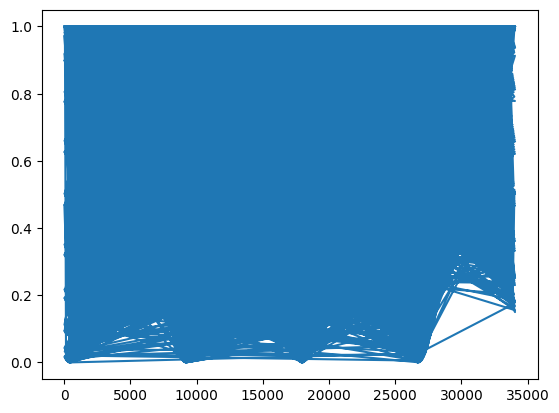

In [20]:
X_A_tr_NN['clear_sky_rad:W'].plot()

In [21]:
#Plot every column
"""for column in X_C.columns:
    plt.figure()
    plt.plot(X_C[str(column)])
    plt.title(column)
    plt.show()"""

'for column in X_C.columns:\n    plt.figure()\n    plt.plot(X_C[str(column)])\n    plt.title(column)\n    plt.show()'

In [22]:
#FEATURE SELECTION
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt

def featureSelect( X_tr, Y_tr, X_te, Y_te, td, num_features):
    sfs_final = SFS(LinearRegression(),
            k_features=num_features,
            forward=False,
            floating=True,
            scoring = 'r2',
            cv = 0)

    sfs_final.fit(X_tr, Y_tr)
    c = []
    for name in sfs_final.k_feature_names_:
        c.append(name)
    #print("C: ", c)
    idk = {}
    newF = pd.DataFrame(idk, columns=c)
    print("diff: ", X_tr.columns.difference(newF.columns))
    X_tr = removeColumns(X_tr, X_tr.columns.difference(newF.columns))
    X_te = removeColumns(X_te, X_te.columns.difference(newF.columns))
    td = removeColumns(td, td.columns.difference(newF.columns))
    return X_tr, Y_tr, X_te, Y_te, td

#X_A_trt, Y_A_trt, X_A_tet, Y_A_tet, testData_At = featureSelect(X_A_tr, Y_A_tr, X_A_te, Y_A_te, testData_A, 40) 
#X_B_trt, Y_B_trt, X_B_tet, Y_B_tet, testData_Bt = featureSelect(X_B_tr, Y_B_tr, X_B_te, Y_B_te, testData_B, 40) 
#X_C_trt, Y_C_trt, X_C_tet, Y_C_tet, testData_Ct = featureSelect(X_C_tr, Y_C_tr, X_C_te, Y_C_te, testData_C, 40) 

#X_A_tr, Y_A_tr, X_A_te, Y_A_te, testData_A = featureSelect(X_A_tr, Y_A_tr, X_A_te, Y_A_te, testData_A, 46) 
#X_B_tr, Y_B_tr, X_B_te, Y_B_te, testData_B = featureSelect(X_B_tr, Y_B_tr, X_B_te, Y_B_te, testData_B, 46) 
#X_C_tr, Y_C_tr, X_C_te, Y_C_te, testData_C = featureSelect(X_C_tr, Y_C_tr, X_C_te, Y_C_te, testData_C, 46) 

def printer():
    print("C_TR: ", X_A_tr.columns)
    print("C_TR_len: ", len(X_A_tr.columns))
    print("-----------------------")
    print("C_Te: ", X_A_te.columns)
    print("C_Te_len: ", len(X_A_te.columns))
    print("-----------------------")
    print("C_Td: ", testData_A.columns)
    print("C_Td_len: ", len(testData_A.columns))

#printer()
#sfs_f = SFS(LinearRegression(),
    #      k_features=(30, 45),
        #   forward=True,
          # floating=True,
          # scoring = 'r2',
          # cv = 0)

#sfs_f.fit(X_A_tr, Y_A_tr)

sfs_b = SFS(LinearRegression(),
          k_features=46,
          forward=False,
          floating=False,
          scoring = 'r2',
          cv = 0)

def checkF(s, X, Y):
    s.fit(X, Y)
    #print(sfs.k_feature_names_) 
    c = []
    for name in sfs_b.k_feature_names_:
        c.append(name)
    print("C: ", c)
    idk = {}
    newF = pd.DataFrame(idk, columns=c)
    #print(newF.columns)
    #print(X_A_tr.columns)
    #print(newF.columns)
    print("removed: ", X_A_tr.columns.difference(newF.columns))
    fig1 = plot_sfs(s.get_metric_dict(), kind='std_dev')
    plt.title('Sequential Backward Selection (w. StdErr)')
    plt.grid()
    plt.figure(figsize=(60,10))
    plt.show()
#print(len(sfs.k_feature_names_))
#print()

#checkF(sfs_b, X_A, Y_A)
#checkF(sfs_b, X_B, Y_B)
#checkF(sfs_b, X_C, Y_C)



In [23]:
#Split and convert to numpy
def splitRatio(X, Y, train_ratio):
    tr = train_ratio
    #vl = train_ratio + validation_ratio
   # train_x, validation_x, test_x = X[:int(len(X)*tr)], X[int(len(X)*tr):int(len(X)*vl)], X[int(len(X)*vl):]
   # train_y, validation_y, test_y= Y[:int(len(Y)*tr)], Y[int(len(Y)*tr):int(len(Y)*vl)], Y[int(len(Y)*vl):]
    train_x = X[0].iloc[:int(len(X[0])*tr)]
    validation_x = X[0].iloc[int(len(X[0])*tr):] 

    train_y = Y[0].iloc[:int(len(Y[0])*tr)]
    validation_y = Y[0].iloc[int(len(Y[0])*tr):] 

    test_x = X[1]
    test_y = Y[1]
    
    return train_x, validation_x, test_x, train_y, validation_y, test_y

def splitRatio2(X, Y, train_ratio,validation_ratio):
    tr = train_ratio
    vl = train_ratio + validation_ratio
    train_x, validation_x, test_x = X[:int(len(X)*tr)], X[int(len(X)*tr):int(len(X)*vl)], X[int(len(X)*vl):]
    train_y, validation_y, test_y= Y[:int(len(Y)*tr)], Y[int(len(Y)*tr):int(len(Y)*vl)], Y[int(len(Y)*vl):]
    
    return train_x, validation_x, test_x, train_y, validation_y, test_y
                                                                             
def pandasToNumpy(tr_x, val_x, te_x, tr_y, val_y, te_y):
    return {'train_x':np.nan_to_num(tr_x.to_numpy(), nan=0),
            'validation_x': np.nan_to_num(val_x.to_numpy(), nan=0),
            'test_x': np.nan_to_num(te_x.to_numpy(), nan=0),
            'train_y': np.nan_to_num(tr_y.to_numpy(), nan=0),
            'validation_y': np.nan_to_num(val_y.to_numpy(), nan=0),
            'test_y': np.nan_to_num(te_y.to_numpy(), nan=0)}   
  
def allData_pandasToNumpy(X, Y):
    return np.nan_to_num(X.to_numpy(), nan=0), np.nan_to_num(Y.to_numpy(), nan=0) 
                                                     
train_x, validation_x, test_x, train_y, validation_y, test_y = splitRatio([X_A_tr_NN, X_A_te_NN], [Y_A_tr_NN, Y_A_te_NN], 0.8)
#train_x, validation_x, test_x, train_y, validation_y, test_y = splitRatio2(X_A, Y_A, 0.956, 0.022)
print(len(train_x))
print(len(train_y))
print(len(validation_x))
print(len(validation_y))
print(len(test_x))
print(len(test_y))

X_A_tr_NN = np.nan_to_num(X_A_tr_NN.to_numpy(), nan=0)
X_A_te_NN = np.nan_to_num(X_A_te_NN.to_numpy(), nan=0)

Y_A_tr_NN = np.nan_to_num(Y_A_tr_NN.to_numpy(), nan=0)
Y_A_te_NN = np.nan_to_num(Y_A_te_NN.to_numpy(), nan=0)

# for elem in train_x.columns:
#    train_x[str(elem)] = train_x[str(elem)].to_frame().rolling(24).mean().bfill()
data = pandasToNumpy(train_x, validation_x, test_x, train_y, validation_y, test_y)

23160
23160
5791
5791
5110
5110


<Axes: >

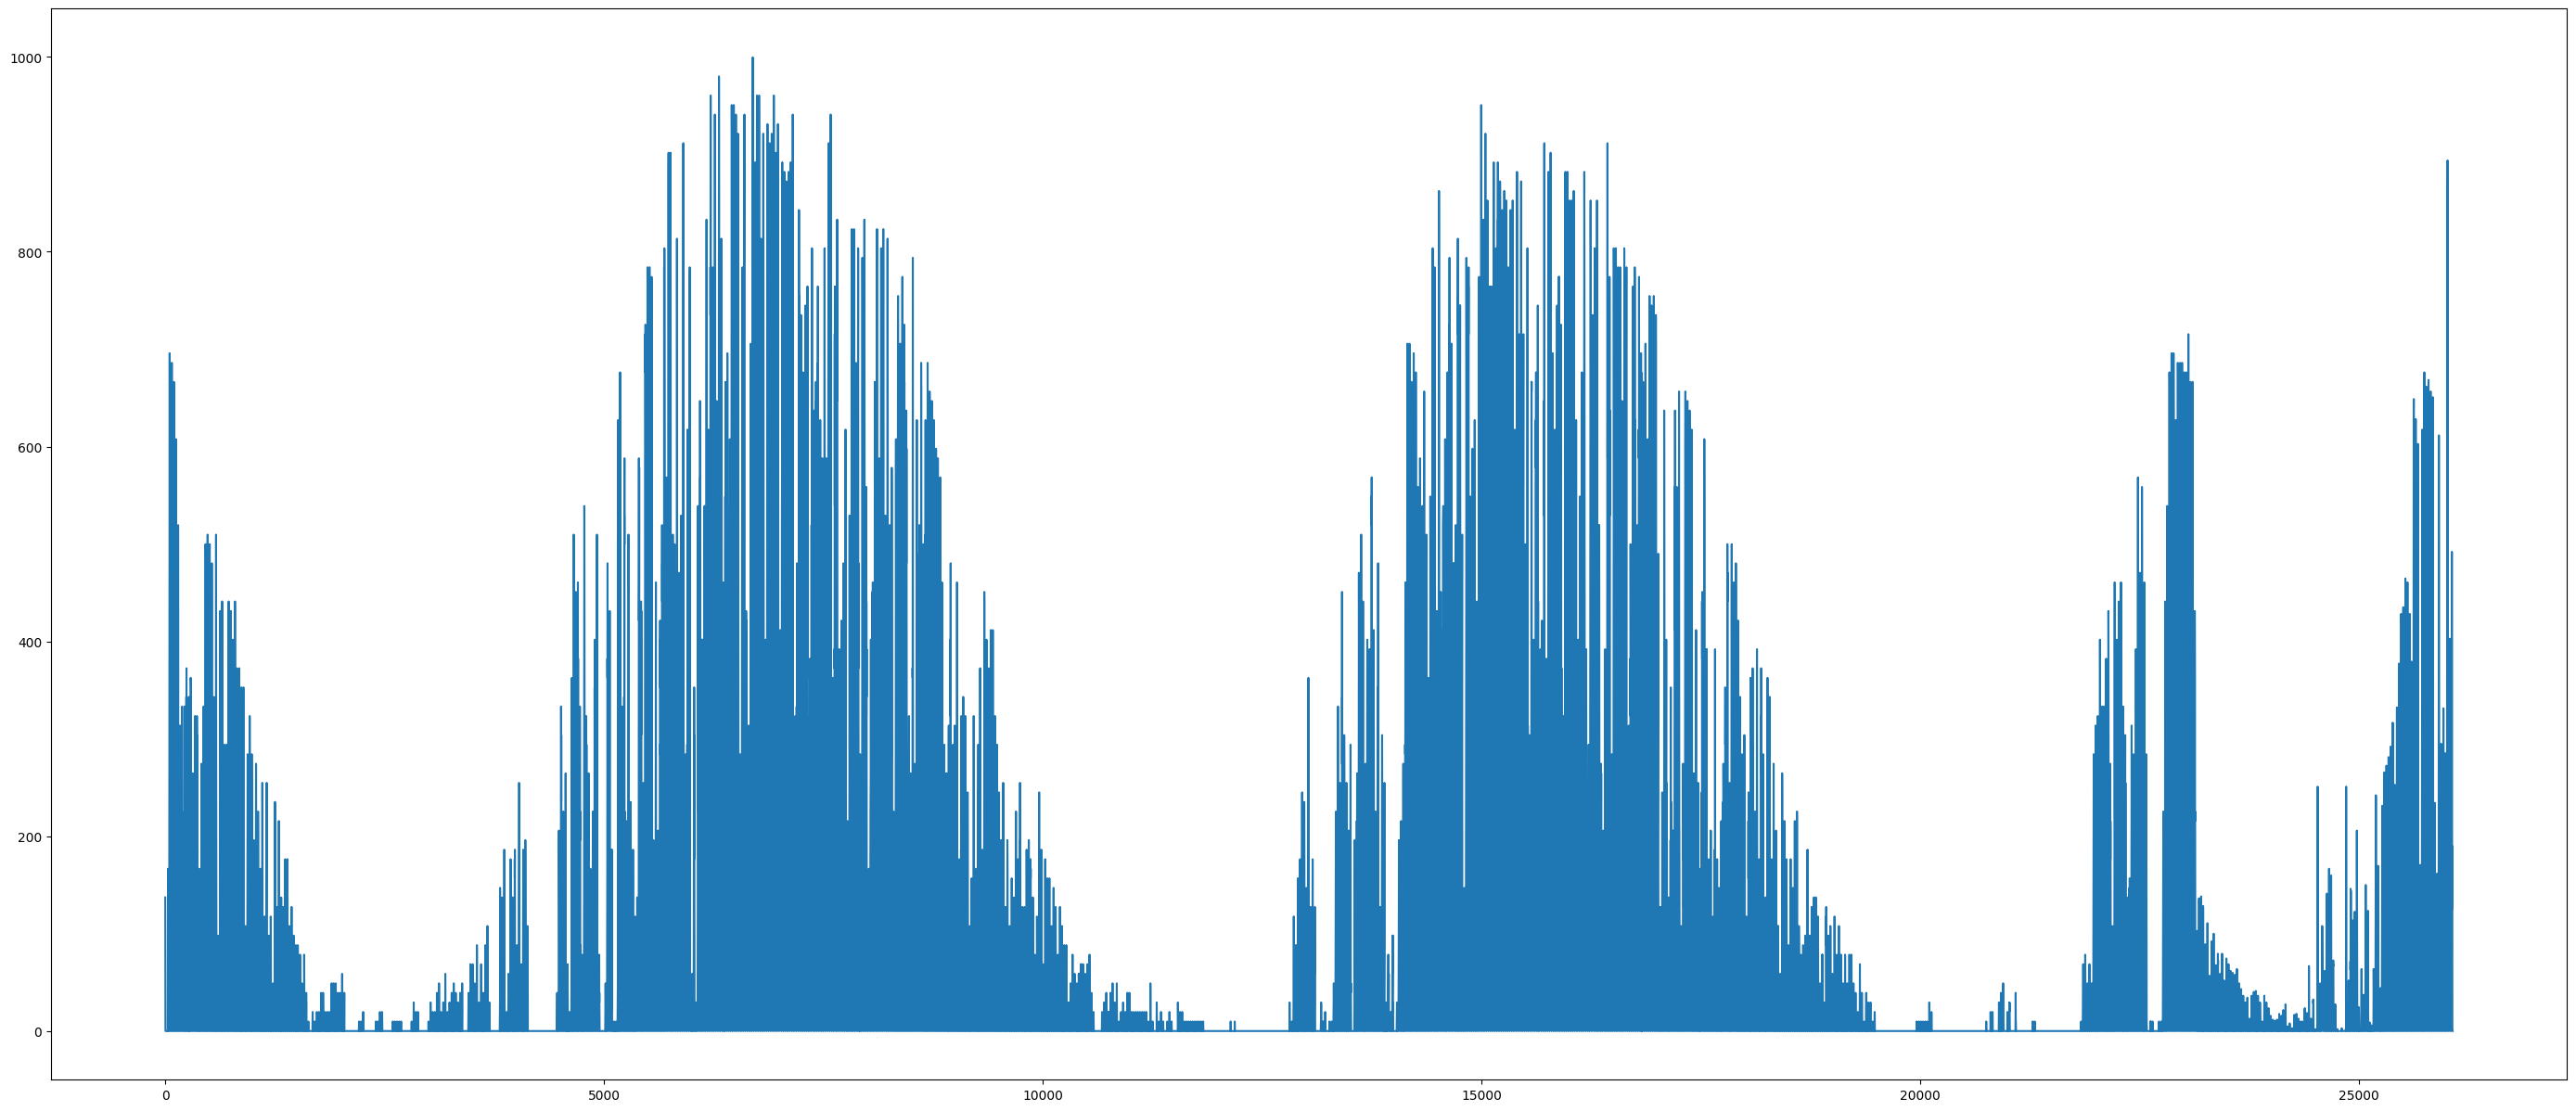

In [55]:
Y_C.plot(figsize=(35,15))
#Y_C = np.concatenate

In [56]:
#TESTDATA
testData_A = np.nan_to_num(testData_A_neuralNets.to_numpy(), nan=0)
testData_A_cnn = testData_A.reshape(*testData_A.shape, 1)

testData_B = np.nan_to_num(testData_B_neuralNets.to_numpy(), nan=0)
testData_B_cnn = testData_B.reshape(*testData_B.shape, 1)

testData_C = np.nan_to_num(testData_C_neuralNets.to_numpy(), nan=0)
testData_C_cnn = testData_C.reshape(*testData_C.shape, 1)

In [57]:
#Loss&activation-functions
def loss_negative_binomial(y_true, y_pred): 
    n = y_pred[:, 0][0]
    p = y_pred[:, 1][0]
    
    return (
        tf.math.lgamma(n) 
        + tf.math.lgamma(y_true + 1)
        - tf.math.lgamma(n + y_true)
        - n * tf.math.log(p)
        - y_true * tf.math.log(1 - p)
    )

def activate_negative_binomial(x):
    a = k.softplus(x[:, 0])
    b = k.sigmoid(x[:, 1])

    a = k.reshape(a, (k.shape(a)[0], 1))
    b = k.reshape(b, (k.shape(b)[0], 1))

    return k.concatenate((a, b), axis=1)


In [26]:
#SAVE&RETRIEVE&REMOVE

#Save & retrieve & delete data (as pickle-files)
import xgboost
import pickle


def saveModel_KERAS(model, filename):
    filepath = 'data/models/' + filename + '.keras'
    model.save(filepath)

def saveModel_XGBOOST(model, filename):
    filepath = 'data/models/' + filename + '.sav'
    #model.save_model(filepath)
    pickle.dump(model, open(filepath, 'wb'))

        
def retrieveModel_KERAS(filename):
    filepath = 'data/models/' + filename + '.keras'
    model = keras.models.load_model(filepath)
    
    return model

def retrieveModel_XGBOOST(filename):
    filepath = 'data/models/' + filename + '.sav'
    model = pickle.load(open(filepath, 'rb'))
    return model

def savePred(pred, filename):
    filepath = 'data/submissions/' + filename + '.csv'
    #PHD_STIPENDS = pd.read_csv('/kaggle/input/phd-stipends/csv') # load from notebook input
    pred.to_csv(filepath, index=False) # save to notebook output

def retrivePred(predName):
    filepath = 'data/submissions/' + predName + '.csv'
    pred = pd.read_csv(filepath) # load from notebook input
    return pred

def removeData(file_path):
    os.remove(file_path) 

In [59]:
#Feedforward-model
#TODO: datasets should be converted to numpy-files 
#build models
# Maybe use kerastuner to test what parameters and/or hyperparameters are mort valuable
#print("xtr: ", train_x)
#print("xte: ", test_x)

import random


def normalizationLayer(train_x):
    normalizer = tf.keras.layers.Normalization(axis=-1)
    normalizer.adapt(np.array(train_x))
    return normalizer

def feedforwardNeuralNet(data):
    checkpoint = tf.keras.callbacks.ModelCheckpoint('data/models/', monitor="val_loss", mode="min", save_best_only=True, verbose=1)
    model = tf.keras.Sequential([
                #tf.keras.layers.BatchNormalization(),
                #normalizationLayer(data["train_y"]),
                #keras.Input(shape=(51,)),
                
                #keras.layers.Dropout(0.25), #drop (raindomly(?)) % of input features
                keras.layers.Dense(128, activation='relu',
                                    kernel_regularizer=regularizers.L1L2(l1=0.01, l2=0.01),
                                    bias_regularizer=regularizers.L1L2(l1=0.01, l2=0.01)),
                keras.layers.Dense(128, activation='relu',
                                    kernel_regularizer=regularizers.L1L2(l1=0.01, l2=0.01),
                                    bias_regularizer=regularizers.L1L2(l1=0.01, l2=0.001)), 
                keras.layers.Dense(128, activation='relu'), 
                                    #  kernel_regularizer=regularizers.L1L2(l1=0.01, l2=0.01)),
                                     #bias_regularizer=regularizers.L1L2(l1=0.01, l2=0.01)), 
                keras.layers.Dense(128, activation='relu'), 
                                    #  kernel_regularizer=regularizers.L1L2(l1=0.01, l2=0.01)),
                                     #bias_regularizer=regularizers.L1L2(l1=0.01, l2=0.01)),

                keras.layers.Dense(1000, activation='relu'),
                                    #  kernel_regularizer=regularizers.L1L2(l1=0.01, l2=0.01),
                                    #  bias_regularizer=regularizers.L1L2(l1=0.01, l2=0.01)),
                keras.layers.Dense(1000, activation='relu'),
                                    #  kernel_regularizer=regularizers.L1L2(l1=0.01, l2=0.01)),
                                     #bias_regularizer=regularizers.L1L2(l1=0.01, l2=0.001)), 
                keras.layers.Dense(1000, activation='relu'), 
                                    #  kernel_regularizer=regularizers.L1L2(l1=0.01, l2=0.01)),
                                     #bias_regularizer=regularizers.L1L2(l1=0.01, l2=0.01)), 
                keras.layers.Dense(128, activation='relu'), 
                                    #  kernel_regularizer=regularizers.L1L2(l1=0.01, l2=0.01)),
                                     #bias_regularizer=regularizers.L1L2(l1=0.01, l2=0.01)),
                 keras.layers.Dense(128, activation='relu'),
                                    #  kernel_regularizer=regularizers.L1L2(l1=0.01, l2=0.01),
                                    #  bias_regularizer=regularizers.L1L2(l1=0.01, l2=0.01)),
                keras.layers.Dense(128, activation='relu'),
                                    #  kernel_regularizer=regularizers.L1L2(l1=0.01, l2=0.01)),
                                     #bias_regularizer=regularizers.L1L2(l1=0.01, l2=0.001)), 
                keras.layers.Dense(128, activation='relu'), 
                                    #  kernel_regularizer=regularizers.L1L2(l1=0.01, l2=0.01)),
                                     #bias_regularizer=regularizers.L1L2(l1=0.01, l2=0.01)), 
                keras.layers.Dense(128, activation='relu'), 
                                    #  kernel_regularizer=regularizers.L1L2(l1=0.01, l2=0.01)),
                                     #bias_regularizer=regularizers.L1L2(l1=0.01, l2=0.01)),
                keras.layers.Dense(1, activation='relu'), 
                                     #
                ])
    model.compile(loss='mean_absolute_error',
                  optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                  metrics=[keras.metrics.MeanAbsoluteError()])
    model.fit(x=data["train_x"], y=data["train_y"], validation_data=(data['validation_x'], data['validation_y']), callbacks=[checkpoint], epochs=30, batch_size=24)
    model.load_weights('data/models/')
    acc = model.evaluate(data["test_x"], data["test_y"])
    print("ACCC", acc)
    return model

def plotANN(model1, data):
    predicted_y = model1.predict(data['test_x'])

    #Plot
    x = []
    plt.plot(predicted_y, linestyle = 'dotted', color='red')
    for i in range(0,len(data['test_y'])):
        x.append(i)
    plt.scatter(x, data['test_y'])
    plt.show()
    #visualizer(model1, file_format='png', view=False)

def plotANN(model, data, testData):
    predicted_y = model.predict(data['test_x'])
    predicted_y_test = model.predict(testData) 

    predicted_y = np.append(predicted_y, predicted_y_test)
    x = []
    #plt.plot(predicted_tr_y, linestyle = 'dotted', color='green')
    plt.plot(predicted_y, linestyle = 'dotted', color='red')
    #labels = np.append(data['train_y'], data['test_y'])
    for i in range(0,len( data['test_y'])):
        x.append(i)
    plt.scatter(x,  data['test_y'])
    plt.show()
    #visualizer(model1, file_format='png', view=False)

def plotAllANN(model, data, testData):
    model.evaluate(data['test_x'], data['test_y'])
    predicted_tr_y = model.predict(data['train_x'])
    predicted_val_y = model.predict(data['validation_x'])
    predicted_te_y = model.predict(data['test_x'])
    predicted_y_test = model.predict(testData) 
    predicted_y = np.append(predicted_tr_y, predicted_val_y )
    predicted_y = np.append(predicted_y, predicted_te_y )
    predicted_y = np.append(predicted_y, predicted_y_test)
    x = []
    #plt.plot(predicted_tr_y, linestyle = 'dotted', color='green')
    plt.plot(predicted_y, linestyle = 'dotted', color='red')
    labels = np.append(data['train_y'], data['validation_y'])
    labels = np.append(labels, data['test_y'])
    for i in range(0,len(labels)):
        x.append(i)
    plt.scatter(x, labels)
    plt.show()
    #visualizer(model1, file_format='png', view=False)

def plotAllANN2(model, data, testData):
    model.evaluate(data['test_x'], data['test_y'])
    predicted_tr_y = model.predict(data['train_x'])
    predicted_val_y = model.predict(data['validation_x'])
    predicted_te_y = model.predict(data['test_x'])
    predicted_y_test = model.predict(testData) 
    predicted_y = np.append(predicted_tr_y, predicted_val_y )
    predicted_y = np.append(predicted_y, predicted_te_y )
    predicted_y = np.append(predicted_y, predicted_y_test)
    x = []
    #plt.plot(predicted_tr_y, linestyle = 'dotted', color='green')
    plt.plot(predicted_y[:3000], linestyle = 'dotted', color='red')
    labels = np.append(data['train_y'], data['validation_y'])
    labels = np.append(labels, data['test_y'])
    for i in range(0,len(labels[:3000])):
        x.append(i)
    plt.scatter(x, labels[:3000])
    plt.figure(figsize=(100,10))
    plt.show()
    #visualizer(model1, file_format='png', view=False)

    
model1 = feedforwardNeuralNet(data)
# plotANN(model1, data, testData_A)
# plotAllANN(model1, data, testData_A)
# plotAllANN2(model1, data, testData_A)



Epoch 1/30
964/965 [============================>.] - ETA: 0s - loss: 292.7443 - mean_absolute_error: 282.5016
Epoch 1: val_loss improved from inf to 227.07465, saving model to data/models\
INFO:tensorflow:Assets written to: data/models\assets


INFO:tensorflow:Assets written to: data/models\assets


965/965 [==============================] - 46s 42ms/step - loss: 292.9049 - mean_absolute_error: 282.6634 - val_loss: 227.0746 - val_mean_absolute_error: 217.9229
Epoch 2/30
964/965 [============================>.] - ETA: 0s - loss: 249.7087 - mean_absolute_error: 240.8374
Epoch 2: val_loss improved from 227.07465 to 219.31522, saving model to data/models\
INFO:tensorflow:Assets written to: data/models\assets


INFO:tensorflow:Assets written to: data/models\assets


965/965 [==============================] - 39s 40ms/step - loss: 249.5897 - mean_absolute_error: 240.7186 - val_loss: 219.3152 - val_mean_absolute_error: 210.6879
Epoch 3/30
964/965 [============================>.] - ETA: 0s - loss: 242.1661 - mean_absolute_error: 233.8259
Epoch 3: val_loss did not improve from 219.31522
965/965 [==============================] - 36s 37ms/step - loss: 242.0380 - mean_absolute_error: 233.6980 - val_loss: 226.8254 - val_mean_absolute_error: 218.6078
Epoch 4/30
964/965 [============================>.] - ETA: 0s - loss: 232.2325 - mean_absolute_error: 224.3571
Epoch 4: val_loss improved from 219.31522 to 210.86395, saving model to data/models\
INFO:tensorflow:Assets written to: data/models\assets


INFO:tensorflow:Assets written to: data/models\assets


965/965 [==============================] - 40s 41ms/step - loss: 232.1883 - mean_absolute_error: 224.3131 - val_loss: 210.8640 - val_mean_absolute_error: 203.1896
Epoch 5/30
965/965 [==============================] - ETA: 0s - loss: 227.8616 - mean_absolute_error: 220.4693
Epoch 5: val_loss did not improve from 210.86395
965/965 [==============================] - 36s 37ms/step - loss: 227.8616 - mean_absolute_error: 220.4693 - val_loss: 222.7755 - val_mean_absolute_error: 215.6015
Epoch 6/30
965/965 [==============================] - ETA: 0s - loss: 229.5739 - mean_absolute_error: 222.4976
Epoch 6: val_loss did not improve from 210.86395
965/965 [==============================] - 33s 34ms/step - loss: 229.5739 - mean_absolute_error: 222.4976 - val_loss: 236.3277 - val_mean_absolute_error: 229.4643
Epoch 7/30
965/965 [==============================] - ETA: 0s - loss: 227.7321 - mean_absolute_error: 221.0552
Epoch 7: val_loss improved from 210.86395 to 207.27739, saving model to data/mod

INFO:tensorflow:Assets written to: data/models\assets


965/965 [==============================] - 38s 39ms/step - loss: 227.7321 - mean_absolute_error: 221.0552 - val_loss: 207.2774 - val_mean_absolute_error: 200.7726
Epoch 8/30
965/965 [==============================] - ETA: 0s - loss: 220.6021 - mean_absolute_error: 214.3000
Epoch 8: val_loss did not improve from 207.27739
965/965 [==============================] - 34s 35ms/step - loss: 220.6021 - mean_absolute_error: 214.3000 - val_loss: 207.7491 - val_mean_absolute_error: 201.6750
Epoch 9/30
964/965 [============================>.] - ETA: 0s - loss: 220.9257 - mean_absolute_error: 214.9847
Epoch 9: val_loss did not improve from 207.27739
965/965 [==============================] - 34s 35ms/step - loss: 220.9512 - mean_absolute_error: 215.0103 - val_loss: 215.6837 - val_mean_absolute_error: 209.8251
Epoch 10/30
965/965 [==============================] - ETA: 0s - loss: 216.9838 - mean_absolute_error: 211.3509
Epoch 10: val_loss improved from 207.27739 to 206.60049, saving model to data/m

INFO:tensorflow:Assets written to: data/models\assets


965/965 [==============================] - 38s 39ms/step - loss: 216.9838 - mean_absolute_error: 211.3509 - val_loss: 206.6005 - val_mean_absolute_error: 201.0081
Epoch 11/30
965/965 [==============================] - ETA: 0s - loss: 218.7447 - mean_absolute_error: 213.2642
Epoch 11: val_loss did not improve from 206.60049
965/965 [==============================] - 33s 35ms/step - loss: 218.7447 - mean_absolute_error: 213.2642 - val_loss: 212.5517 - val_mean_absolute_error: 207.1136
Epoch 12/30
964/965 [============================>.] - ETA: 0s - loss: 214.6263 - mean_absolute_error: 209.3377
Epoch 12: val_loss did not improve from 206.60049
965/965 [==============================] - 33s 34ms/step - loss: 214.7213 - mean_absolute_error: 209.4329 - val_loss: 208.2767 - val_mean_absolute_error: 203.1432
Epoch 13/30
964/965 [============================>.] - ETA: 0s - loss: 213.7768 - mean_absolute_error: 208.6028
Epoch 13: val_loss improved from 206.60049 to 198.02528, saving model to da

INFO:tensorflow:Assets written to: data/models\assets


965/965 [==============================] - 37s 38ms/step - loss: 213.7957 - mean_absolute_error: 208.6218 - val_loss: 198.0253 - val_mean_absolute_error: 192.8741
Epoch 14/30
965/965 [==============================] - ETA: 0s - loss: 210.2435 - mean_absolute_error: 205.2112
Epoch 14: val_loss improved from 198.02528 to 197.07033, saving model to data/models\
INFO:tensorflow:Assets written to: data/models\assets


INFO:tensorflow:Assets written to: data/models\assets


965/965 [==============================] - 34s 36ms/step - loss: 210.2435 - mean_absolute_error: 205.2112 - val_loss: 197.0703 - val_mean_absolute_error: 192.0232
Epoch 15/30
965/965 [==============================] - ETA: 0s - loss: 210.3172 - mean_absolute_error: 205.3751
Epoch 15: val_loss did not improve from 197.07033
965/965 [==============================] - 30s 31ms/step - loss: 210.3172 - mean_absolute_error: 205.3751 - val_loss: 215.6146 - val_mean_absolute_error: 210.7062
Epoch 16/30
964/965 [============================>.] - ETA: 0s - loss: 208.9903 - mean_absolute_error: 204.1503
Epoch 16: val_loss did not improve from 197.07033
965/965 [==============================] - 30s 31ms/step - loss: 208.9405 - mean_absolute_error: 204.1005 - val_loss: 229.9177 - val_mean_absolute_error: 225.0767
Epoch 17/30
965/965 [==============================] - ETA: 0s - loss: 211.8143 - mean_absolute_error: 206.8862
Epoch 17: val_loss did not improve from 197.07033
965/965 [================

KeyboardInterrupt: 

In [91]:
#saveModel_KERAS(model1, 'feedforward_118_47Features_A')

In [92]:
#PREPARE DATA FOR CNN

#TODO: - Add dummy-dimension to data so its compatible w/conv-layers DONE
#       - Add validation-data (By splitting up training data into training/validation) DONE
def prepareDataForCNN(data, length, batch_size): 
    data_cnn = data.copy()
    data_cnn['train_x'] = data['train_x'].reshape(*data['train_x'].shape, 1)
    data_cnn['validation_x'] = data['validation_x'].reshape(*data['validation_x'].shape, 1)
    data_cnn['test_x'] = data['test_x'].reshape(*data['test_x'].shape, 1)
    #train_generator = tf.keras.preprocessing.sequence.TimeseriesGenerator(tr, data['train_y'], 
    #                                                                length=length, 
    #                                                                batch_size=batch_size)
    #validation_generator = tf.keras.preprocessing.sequence.TimeseriesGenerator(val, data['validation_y'], 
    #                                                                length=length, 
    #                                                                batch_size=batch_size)
    #test_generator = tf.keras.preprocessing.sequence.TimeseriesGenerator(te, data['test_y'], 
     #                                                               length=length, 
     #                                                               batch_size=batch_size)
    #return train_generator, validation_generator, test_generator
    return data_cnn
                          

data_cnn = prepareDataForCNN(data, 24, 24)

X_A_tr_NN = X_A_tr_NN.reshape(*X_A_tr_NN.shape, 1)
X_A_te_NN = X_A_te_NN.reshape(*X_A_te_NN.shape, 1)

In [93]:
#Transformer-model
#SE HUGGING FACE NETTSIDER (i bookmarks)
#BRUKER ANDRE BIBLIOTEKER ENN KERAS/TENSORFLOW LETSGOOOO
from keras import layers
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

def build_model(input_shape, head_size, num_heads,ff_dim, num_transformer_blocks, mlp_units, dropout=0, mlp_dropout=0):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1, activation="relu")(x)
    return keras.Model(inputs, outputs)
def transformer(data_cnn):

    input_shape = data_cnn['train_x'].shape[1:]

    model = build_model(
        input_shape,
        head_size=256,
        num_heads=4,
        ff_dim=4,
        num_transformer_blocks=2,
        mlp_units=[45, 45],
        mlp_dropout=0.05,
        dropout=0.05,
    )

    model.compile(
        loss="mean_absolute_error",
        optimizer=keras.optimizers.Adam(learning_rate=1e-4),
        metrics=["mean_absolute_error"],
    )
    #model.summary()

    callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
    checkpoint = tf.keras.callbacks.ModelCheckpoint('data/models/', monitor="val_loss", mode="min", save_best_only=True, verbose=1)
    input_dim = len(data['train_x'][0])
    print('dim: ', input_dim)
    model.fit(
        data_cnn['train_x'],
        data_cnn['train_y'],
        validation_data=(data_cnn['validation_x'], data_cnn['validation_y']),
        epochs=100,
        batch_size=32,
        callbacks=checkpoint,
        #shuffle=True
    )

    model.evaluate(data_cnn['test_x'], data_cnn['test_y'], verbose=1)
    return model
#modelTransformer = transformer(data_cnn)

In [94]:
#PyramidialMLP
from keras.layers import PReLU
def pyramidialMLP(data):
    checkpoint = tf.keras.callbacks.ModelCheckpoint('data/models/', monitor="val_loss", mode="min", save_best_only=True, verbose=1)
    # deep pyramidal MLP, narrowing with depth
    model = keras.Sequential([
        keras.layers.Dropout(0.13),
        keras.layers.Dense(192, kernel_regularizer=regularizers.L1L2(l1=0.01, l2=0.01),
                                     bias_regularizer=regularizers.L1L2(l1=0.01, l2=0.01)),
        PReLU(),
        keras.layers.Dropout(0.11),
        keras.layers.Dense(96, kernel_regularizer=regularizers.L1L2(l1=0.01, l2=0.01)),
                                     #bias_regularizer=regularizers.L1L2(l1=0.01, l2=0.01)),
        PReLU(),
        keras.layers.Dropout(0.09),
        keras.layers.Dense(48, kernel_regularizer=regularizers.L1L2(l1=0.01, l2=0.01)),
                                     #bias_regularizer=regularizers.L1L2(l1=0.01, l2=0.01)),
        PReLU(),
        keras.layers.Dropout(0.07),
       
        keras.layers.Dense(24, kernel_regularizer=regularizers.L1L2(l1=0.01, l2=0.01)),
                                     #bias_regularizer=regularizers.L1L2(l1=0.01, l2=0.01)),
        PReLU(),
        keras.layers.Dropout(0.05),
        
        keras.layers.Dense(1, kernel_regularizer=regularizers.L1L2(l1=0.01, l2=0.01),
                                     bias_regularizer=regularizers.L1L2(l1=0.01, l2=0.01)),
        PReLU(),

    ])
    model.compile(loss='mean_absolute_error',
                  optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                  metrics=[keras.metrics.MeanAbsoluteError()])
    
    model.fit(x=data['train_x'], y=data['train_y'], validation_data=(data['validation_x'], data['validation_y']), epochs=10, batch_size=24, callbacks=[checkpoint], shuffle=True)
    model.load_weights('data/models/')
    acc = model.evaluate(data['test_x'], data['test_y'])
    print("ACCC", acc)
   

    return model


#xg = pyramidialMLP(data)

In [95]:
print(len(X_A_te_trees.columns))
print(len(X_B_te_trees.columns))
print(len(X_C_te_trees.columns))

64
64
64


In [96]:
#XGBOOST-MODEL
from sklearn.model_selection import RepeatedKFold, cross_val_score
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
def xgboost(X_tr, Y_tr, X_te, Y_te):
    params = {"objective": "binary:logistic",
            "eta": 0.2,
            "max_depth": 6,
            "min_child_weight": 1,
            "silent": 0,
            "seed": 1}
    num_trees=300
    model = xgb.XGBRegressor(booster='gbtree', objective= 'reg:absoluteerror', max_depth=14,
                            n_estimators=2000, eta=0.03, eval_metric='mae', sampling_method='uniform', 
                             reg_lambda=1, reg_alpha=0.001, subsample=0.7, colsample_bytree=0.8)
    model.fit(X_tr, Y_tr, eval_set=[(X_tr, Y_tr), (X_te, Y_te)], verbose=True)
    
    #_ = xgb.plot_importance(model, height=0.9)

    #pred_test = model.predict(X_te)
    #print("MAE: ", mean_absolute_error(y_true=Y_te, y_pred=pred_test))
    return model


#A-BLOCK PARAMS: (objective: absoluteerror, n_estimators: 61, eta: 0.3, reg_lambda: 0.5, reg_alpha: 0.001)
#B-BLOCK PARAMS: (objective: absoluteerror, n_estimators: 61, eta: 0.2, reg_lambda: 0.5, reg_alpha: 0.001)
#C-BLOCK PARAMS: (objective: absoluteerror, n_estimators: 61, eta: 0.3, reg_lambda: 0.5, reg_alpha: 0.001)

m = xgb.XGBRegressor(booster='gbtree', objective= 'reg:absoluteerror', max_depth=7,
                            n_estimators=1000, eta=0.1, eval_metric='mae', sampling_method='uniform', 
                             reg_lambda=1, reg_alpha=0.0001, subsample=0.7, colsample_bytree=0.8)
#cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=1)
#scores = cross_val_score(m, X_A, Y_A, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1,)
#print("MAE_kfold: ", abs(scores).mean())
#print("MAE: ", abs(scores))
#print(X_A_tr_trees.columns)
#print(X_A_tr_trees.describe())
#print(len(X_A_tr_trees.columns))

xgboost_model = xgboost(X_B_tr_trees, Y_B_tr_trees, X_B_te_trees, Y_B_te_trees)
#A&B: 6000 epochs
#C: 

In [97]:
#PLOT LEARNING-CURVE
from matplotlib import pyplot
results = xgboost_model.evals_result()
# plot learning curves
pyplot.plot(results['validation_0']['mae'], label='train')
pyplot.plot(results['validation_1']['mae'], label='test')
pyplot.legend()

In [98]:
'effective_cloud_cover:p_clear_sky_energy_1h:J', 'absolute_humidity_2m:gm3_ceiling_height_agl:m'

('effective_cloud_cover:p_clear_sky_energy_1h:J',
 'absolute_humidity_2m:gm3_ceiling_height_agl:m')

In [99]:
#Iterate through generated features and inspect whether they improve performance
toRemove = []
dateFeatures = ['Week', 'Day', 'Hour', 'Month', 'Year']
dateFeatures.extend(created)
print((created))

for elem in dateFeatures:
    print(elem)
    testSet_tr, testSet_te = X_A_tr_trees.copy(), X_A_te_trees.copy()
    testSet_tr.drop([str(elem)], axis=1, inplace=True)
    testSet_te.drop([str(elem)], axis=1, inplace=True)

    prev = xgboost(X_A_tr_trees, Y_A_tr_trees, X_A_te_trees, Y_A_te_trees)
    tester = xgboost(testSet_tr, Y_A_tr_trees, testSet_te, Y_A_te_trees) 
    
    len_prev = len(X_A_tr_trees.columns)
    pred_prev = prev.predict(X_A_te_trees)
    score_prev = mean_absolute_error(y_true=Y_A_te_trees, y_pred=pred_prev)

    pred_test = tester.predict(testSet_te)
    score_test = mean_absolute_error(y_true=Y_A_te_trees, y_pred=pred_test)

   
    print("feature: ", elem)
    print("-----------------------")
    print("score_prev: ", score_prev)
    print("score_test: ", score_test)
    if score_test < score_prev:
        X_A_tr_trees.drop([str(elem)], axis=1, inplace=True)
        X_A_te_trees.drop([str(elem)], axis=1, inplace=True)
        print("REMOVE ", elem)
        toRemove.append(elem)
    else:
        print('KEEP', elem)
    
    print("----------------------------------")
    print("-------------------------------")

print('Remove these: ', toRemove)
    
    

    

['effective_cloud_cover:p_clear_sky_energy_1h:J', 'absolute_humidity_2m:gm3_ceiling_height_agl:m', 'absolute_humidity_2m:gm3_air_density_2m:kgm3', 'absolute_humidity_2m:gm3_cloud_base_agl:m', 'absolute_humidity_2m:gm3_sun_azimuth:d', 'ceiling_height_agl:m_air_density_2m:kgm3', 'ceiling_height_agl:m_cloud_base_agl:m', 'ceiling_height_agl:m_sun_azimuth:d', 'air_density_2m:kgm3_cloud_base_agl:m', 'air_density_2m:kgm3_sun_azimuth:d', 'cloud_base_agl:m_sun_azimuth:d', 'absolute_humidity_2m:gm3_dew_point_2m:K', 'absolute_humidity_2m:gm3_t_1000hPa:K', 'air_density_2m:kgm3_dew_point_2m:K', 'air_density_2m:kgm3_t_1000hPa:K', 'sun_azimuth:d_Hour']
Week


[0]	validation_0-mae:623.06282	validation_1-mae:603.03716
[1]	validation_0-mae:609.89191	validation_1-mae:589.99624
[2]	validation_0-mae:596.18239	validation_1-mae:576.27435
[3]	validation_0-mae:582.40881	validation_1-mae:562.87060
[4]	validation_0-mae:568.84979	validation_1-mae:549.60996
[5]	validation_0-mae:555.44025	validation_1-mae:536.56880
[6]	validation_0-mae:541.95455	validation_1-mae:523.61262
[7]	validation_0-mae:528.14547	validation_1-mae:510.40198
[8]	validation_0-mae:514.15303	validation_1-mae:497.00163
[9]	validation_0-mae:500.70570	validation_1-mae:484.09146
[10]	validation_0-mae:487.77067	validation_1-mae:472.00680
[11]	validation_0-mae:475.60154	validation_1-mae:460.59168
[12]	validation_0-mae:463.46205	validation_1-mae:449.44015
[13]	validation_0-mae:451.46289	validation_1-mae:438.37306
[14]	validation_0-mae:439.88663	validation_1-mae:427.43901
[15]	validation_0-mae:428.93519	validation_1-mae:417.25282
[16]	validation_0-mae:417.74358	validation_1-mae:406.99708
[17]	va

KeyboardInterrupt: 

Feature:  ('snow_drift:idx', 19.0)
Feature:  ('wind_speed_w_1000hPa:ms', 103.0)
Feature:  ('snow_melt_10min:mm', 551.0)
Feature:  ('is_day:idx', 758.0)
Feature:  ('prob_rime:p', 870.0)
Feature:  ('snow_density:kgm3', 1120.0)
Feature:  ('is_in_shadow:idx', 1358.0)
Feature:  ('fresh_snow_3h:cm', 2085.0)
Feature:  ('fresh_snow_6h:cm', 2230.0)
Feature:  ('fresh_snow_1h:cm', 2365.0)
Feature:  ('flag', 2664.0)
Feature:  ('snow_depth:cm', 3482.0)
Feature:  ('dew_or_rime:idx', 4073.0)
Feature:  ('sfc_pressure:hPa', 5376.0)
Feature:  ('precip_type_5min:idx', 5831.0)
Feature:  ('fresh_snow_24h:cm', 6438.0)
Feature:  ('fresh_snow_12h:cm', 6604.0)
Feature:  ('rain_water:kgm2', 8050.0)
Feature:  ('pressure_50m:hPa', 8385.0)
Feature:  ('Year', 9246.0)
Feature:  ('sun_azimuth:d_Hour', 11367.0)
Feature:  ('Hour', 11534.0)
Feature:  ('Month', 12392.0)
Feature:  ('absolute_humidity_2m:gm3_air_density_2m:kgm3', 19097.0)
Feature:  ('precip_5min:mm', 19389.0)
Feature:  ('air_density_2m:kgm3_cloud_base_agl:

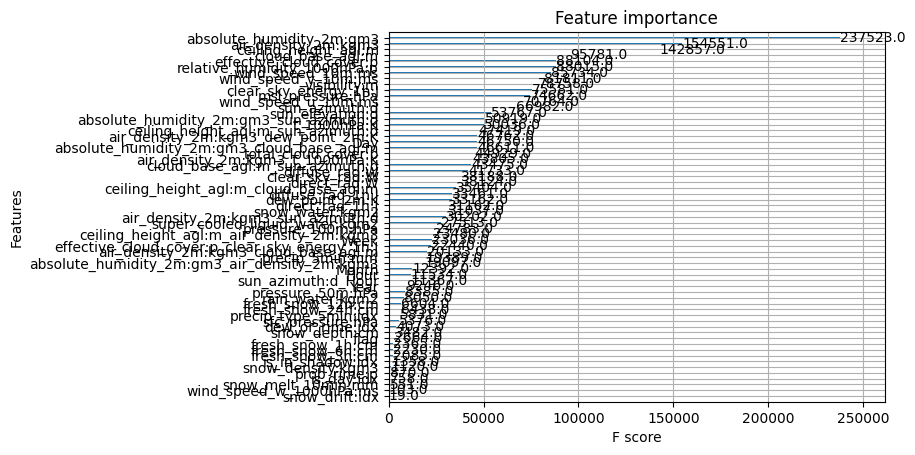

In [ ]:
from xgboost import plot_importance 
plot_importance(xgboost_model)
fi = xgboost_model.get_booster().get_score(importance_type='weight')

fi_sorted = sorted(fi.items(), key=lambda item: item[1])
for elem in fi_sorted:
    print("Feature: ", elem )
    
#TOP 5
# Absolute_humidity
# Ceiling_height
# Air_density
# Cloud_base
# sun_azimuth


In [ ]:
# saveModel_XGBOOST(xgboost_model, 'xgboost_21_2_64Features_B')


In [ ]:

# xx = retrieveModel_XGBOOST('xgboost_17_64Features_C')
# #xxx = retrieveModel_XGBOOST('xgboost_115_70Features_A')
# print(xx)
# pred_train = xx.predict(X_A_tr_trees)
# #pred_train_1 = xxx.predict(X_A_tr_trees)
# print("MAE_tr: ", mean_absolute_error(y_true=Y_A_tr_trees, y_pred=pred_train))
# #print("MAE_tr: ", mean_absolute_error(y_true=Y_A_tr, y_pred=pred_train_1))

# pred_test = xx.predict(X_A_te_trees)
# #pred_test_1 = xxx.predict(X_A_te_trees)
# print("-----------------------------------------")
# print("MAE_te: ", mean_absolute_error(y_true=Y_A_te_trees, y_pred=pred_test))
# #print("MAE_te: ", mean_absolute_error(y_true=Y_A_te, y_pred=pred_test_1))

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.03, eval_metric='mae',
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=14,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=2251,
             n_jobs=None, num_parallel_tree=None, ...)


ValueError: feature_names mismatch: ['absolute_humidity_2m:gm3', 'air_density_2m:kgm3', 'ceiling_height_agl:m', 'clear_sky_energy_1h:J', 'clear_sky_rad:W', 'cloud_base_agl:m', 'dew_or_rime:idx', 'dew_point_2m:K', 'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J', 'effective_cloud_cover:p', 'elevation:m', 'fresh_snow_12h:cm', 'fresh_snow_1h:cm', 'fresh_snow_24h:cm', 'fresh_snow_3h:cm', 'fresh_snow_6h:cm', 'is_day:idx', 'is_in_shadow:idx', 'msl_pressure:hPa', 'precip_5min:mm', 'precip_type_5min:idx', 'pressure_100m:hPa', 'pressure_50m:hPa', 'prob_rime:p', 'rain_water:kgm2', 'relative_humidity_1000hPa:p', 'sfc_pressure:hPa', 'snow_density:kgm3', 'snow_depth:cm', 'snow_drift:idx', 'snow_melt_10min:mm', 'snow_water:kgm2', 'sun_azimuth:d', 'sun_elevation:d', 'super_cooled_liquid_water:kgm2', 't_1000hPa:K', 'total_cloud_cover:p', 'visibility:m', 'wind_speed_10m:ms', 'wind_speed_u_10m:ms', 'wind_speed_v_10m:ms', 'wind_speed_w_1000hPa:ms', 'flag', 'Hour', 'Month', 'Year', 'Day', 'Week', 'absolute_humidity_2m:gm3_ceiling_height_agl:m', 'absolute_humidity_2m:gm3_air_density_2m:kgm3', 'absolute_humidity_2m:gm3_cloud_base_agl:m', 'absolute_humidity_2m:gm3_sun_azimuth:d', 'ceiling_height_agl:m_air_density_2m:kgm3', 'ceiling_height_agl:m_cloud_base_agl:m', 'ceiling_height_agl:m_sun_azimuth:d', 'air_density_2m:kgm3_cloud_base_agl:m', 'air_density_2m:kgm3_sun_azimuth:d', 'cloud_base_agl:m_sun_azimuth:d', 'absolute_humidity_2m:gm3_dew_point_2m:K', 'absolute_humidity_2m:gm3_t_1000hPa:K', 'air_density_2m:kgm3_dew_point_2m:K', 'air_density_2m:kgm3_t_1000hPa:K', 'sun_azimuth:d_Hour'] ['absolute_humidity_2m:gm3', 'air_density_2m:kgm3', 'ceiling_height_agl:m', 'clear_sky_energy_1h:J', 'clear_sky_rad:W', 'cloud_base_agl:m', 'dew_or_rime:idx', 'dew_point_2m:K', 'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J', 'effective_cloud_cover:p', 'elevation:m', 'fresh_snow_12h:cm', 'fresh_snow_1h:cm', 'fresh_snow_24h:cm', 'fresh_snow_3h:cm', 'fresh_snow_6h:cm', 'is_day:idx', 'is_in_shadow:idx', 'msl_pressure:hPa', 'precip_5min:mm', 'precip_type_5min:idx', 'pressure_100m:hPa', 'pressure_50m:hPa', 'prob_rime:p', 'rain_water:kgm2', 'relative_humidity_1000hPa:p', 'sfc_pressure:hPa', 'snow_density:kgm3', 'snow_depth:cm', 'snow_drift:idx', 'snow_melt_10min:mm', 'snow_water:kgm2', 'sun_azimuth:d', 'sun_elevation:d', 'super_cooled_liquid_water:kgm2', 't_1000hPa:K', 'total_cloud_cover:p', 'visibility:m', 'wind_speed_10m:ms', 'wind_speed_u_10m:ms', 'wind_speed_v_10m:ms', 'wind_speed_w_1000hPa:ms', 'flag', 'Hour', 'Month', 'Year', 'Day', 'Week', 'effective_cloud_cover:p_clear_sky_energy_1h:J', 'absolute_humidity_2m:gm3_air_density_2m:kgm3', 'absolute_humidity_2m:gm3_cloud_base_agl:m', 'absolute_humidity_2m:gm3_sun_azimuth:d', 'ceiling_height_agl:m_air_density_2m:kgm3', 'ceiling_height_agl:m_cloud_base_agl:m', 'ceiling_height_agl:m_sun_azimuth:d', 'air_density_2m:kgm3_cloud_base_agl:m', 'air_density_2m:kgm3_sun_azimuth:d', 'cloud_base_agl:m_sun_azimuth:d', 'air_density_2m:kgm3_dew_point_2m:K', 'air_density_2m:kgm3_t_1000hPa:K', 'sun_azimuth:d_Hour']
expected absolute_humidity_2m:gm3_t_1000hPa:K, absolute_humidity_2m:gm3_ceiling_height_agl:m, absolute_humidity_2m:gm3_dew_point_2m:K in input data
training data did not have the following fields: effective_cloud_cover:p_clear_sky_energy_1h:J

In [ ]:
# #PLOT XGBOOST
# def plot_predictions(y_test, actual):
#     plt.plot(y_test, linestyle = 'dotted', color='red')
#     x = []
#     for i in range(0,len(actual)):
#       x.append(i)
#     plt.scatter(x, actual)
#     plt.figure(figsize=(100,10))
#     plt.show()

  
# pred_tr0 = xx.predict(X_A_tr_trees)
# pred_tr = xx.predict(X_A_te_trees)
# pred_te = xx.predict(testData_A_tree)

# allPreds = np.append(pred_tr, pred_te, axis=0)
# allPreds1 = np.append(pred_tr0, allPreds, axis=0)


# plot_predictions(allPreds, pd.DataFrame(Y_A_te_trees)['Y'])
# plot_predictions(allPreds1, pd.DataFrame(Y_A_te_trees)['Y'])

# # pred_tr0 = xxx.predict(X_A_tr_trees)
# # pred_tr = xxx.predict(X_A_te_trees)
# # pred_te = xxx.predict(testData_A_tree)

# # allPreds = np.append(pred_tr, pred_te, axis=0)
# # allPreds1 = np.append(pred_tr0, allPreds, axis=0)


# # plot_predictions(allPreds, pd.DataFrame(Y_A_te)['pv_measurement'])
# # plot_predictions(allPreds1, pd.DataFrame(Y_A_te)['pv_measurement'])

ValueError: feature_names mismatch: ['absolute_humidity_2m:gm3', 'air_density_2m:kgm3', 'ceiling_height_agl:m', 'clear_sky_energy_1h:J', 'clear_sky_rad:W', 'cloud_base_agl:m', 'dew_or_rime:idx', 'dew_point_2m:K', 'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J', 'effective_cloud_cover:p', 'elevation:m', 'fresh_snow_12h:cm', 'fresh_snow_1h:cm', 'fresh_snow_24h:cm', 'fresh_snow_3h:cm', 'fresh_snow_6h:cm', 'is_day:idx', 'is_in_shadow:idx', 'msl_pressure:hPa', 'precip_5min:mm', 'precip_type_5min:idx', 'pressure_100m:hPa', 'pressure_50m:hPa', 'prob_rime:p', 'rain_water:kgm2', 'relative_humidity_1000hPa:p', 'sfc_pressure:hPa', 'snow_density:kgm3', 'snow_depth:cm', 'snow_drift:idx', 'snow_melt_10min:mm', 'snow_water:kgm2', 'sun_azimuth:d', 'sun_elevation:d', 'super_cooled_liquid_water:kgm2', 't_1000hPa:K', 'total_cloud_cover:p', 'visibility:m', 'wind_speed_10m:ms', 'wind_speed_u_10m:ms', 'wind_speed_v_10m:ms', 'wind_speed_w_1000hPa:ms', 'flag', 'Hour', 'Month', 'Year', 'Day', 'Week', 'absolute_humidity_2m:gm3_ceiling_height_agl:m', 'absolute_humidity_2m:gm3_air_density_2m:kgm3', 'absolute_humidity_2m:gm3_cloud_base_agl:m', 'absolute_humidity_2m:gm3_sun_azimuth:d', 'ceiling_height_agl:m_air_density_2m:kgm3', 'ceiling_height_agl:m_cloud_base_agl:m', 'ceiling_height_agl:m_sun_azimuth:d', 'air_density_2m:kgm3_cloud_base_agl:m', 'air_density_2m:kgm3_sun_azimuth:d', 'cloud_base_agl:m_sun_azimuth:d', 'absolute_humidity_2m:gm3_dew_point_2m:K', 'absolute_humidity_2m:gm3_t_1000hPa:K', 'air_density_2m:kgm3_dew_point_2m:K', 'air_density_2m:kgm3_t_1000hPa:K', 'sun_azimuth:d_Hour'] ['absolute_humidity_2m:gm3', 'air_density_2m:kgm3', 'ceiling_height_agl:m', 'clear_sky_energy_1h:J', 'clear_sky_rad:W', 'cloud_base_agl:m', 'dew_or_rime:idx', 'dew_point_2m:K', 'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J', 'effective_cloud_cover:p', 'elevation:m', 'fresh_snow_12h:cm', 'fresh_snow_1h:cm', 'fresh_snow_24h:cm', 'fresh_snow_3h:cm', 'fresh_snow_6h:cm', 'is_day:idx', 'is_in_shadow:idx', 'msl_pressure:hPa', 'precip_5min:mm', 'precip_type_5min:idx', 'pressure_100m:hPa', 'pressure_50m:hPa', 'prob_rime:p', 'rain_water:kgm2', 'relative_humidity_1000hPa:p', 'sfc_pressure:hPa', 'snow_density:kgm3', 'snow_depth:cm', 'snow_drift:idx', 'snow_melt_10min:mm', 'snow_water:kgm2', 'sun_azimuth:d', 'sun_elevation:d', 'super_cooled_liquid_water:kgm2', 't_1000hPa:K', 'total_cloud_cover:p', 'visibility:m', 'wind_speed_10m:ms', 'wind_speed_u_10m:ms', 'wind_speed_v_10m:ms', 'wind_speed_w_1000hPa:ms', 'flag', 'Hour', 'Month', 'Year', 'Day', 'Week', 'effective_cloud_cover:p_clear_sky_energy_1h:J', 'absolute_humidity_2m:gm3_air_density_2m:kgm3', 'absolute_humidity_2m:gm3_cloud_base_agl:m', 'absolute_humidity_2m:gm3_sun_azimuth:d', 'ceiling_height_agl:m_air_density_2m:kgm3', 'ceiling_height_agl:m_cloud_base_agl:m', 'ceiling_height_agl:m_sun_azimuth:d', 'air_density_2m:kgm3_cloud_base_agl:m', 'air_density_2m:kgm3_sun_azimuth:d', 'cloud_base_agl:m_sun_azimuth:d', 'air_density_2m:kgm3_dew_point_2m:K', 'air_density_2m:kgm3_t_1000hPa:K', 'sun_azimuth:d_Hour']
expected absolute_humidity_2m:gm3_t_1000hPa:K, absolute_humidity_2m:gm3_ceiling_height_agl:m, absolute_humidity_2m:gm3_dew_point_2m:K in input data
training data did not have the following fields: effective_cloud_cover:p_clear_sky_energy_1h:J

In [ ]:
#GRU-model
def gru(data):
    checkpoint = tf.keras.callbacks.ModelCheckpoint('data/models/', monitor="val_loss", mode="min", save_best_only=True, verbose=1)
    model = keras.Sequential([
        keras.layers.GRU(64, activation='relu', input_shape=(data['train_x'].shape[1], data['train_x'].shape[2]), return_sequences=True),
        keras.layers.GRU(32, activation='relu', return_sequences=False),
        keras.layers.Dropout(0.1),
        keras.layers.Dense(50, activation='relu'),
        keras.layers.Dense(50, activation='relu'),
        keras.layers.Dense(50, activation='relu'),
        keras.layers.Dense(50, activation='relu'),
        keras.layers.Dense(50, activation='relu'),

    ])
    model.compile(loss='mean_absolute_error',
                  optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                  metrics=[keras.metrics.MeanAbsoluteError()])
    
    #model.fit(x=np.asarray(data['train_x']).astype('float32'), y=np.asarray(data['train_y']).astype('float32'), validation_data=(data['validation_x'], data['validation_y']), epochs=10, batch_size=128, callbacks=[checkpoint], shuffle=True)
    model.fit(x=data['train_x'], y=data['train_y'], validation_data=(data['validation_x'], data['validation_y']), epochs=10, batch_size=24, callbacks=[checkpoint], shuffle=True)
    model.load_weights('data/models/')
    acc = model.evaluate(data['test_x'], data['test_y'])
    print("ACCC", acc)
    return model

#GRU = gru(data_cnn)



Epoch 1/10
215/742 [=======>......................] - ETA: 18s - loss: 122.5390 - mean_absolute_error: 122.5390

KeyboardInterrupt: 

In [136]:
print(len(X_A_tr_trees))
print(len(X_A_te_trees))

30654
3407


In [4]:
#CATBOOST-MODEL
from catboost import CatBoostRegressor
import tensorflow as tf
#print(tf.config.list_physical_devices())

# specify the training parameters 
cat_model = CatBoostRegressor(iterations=3900, 
                          depth=12, 
                          learning_rate=0.01, 
                          loss_function='MAE',
                        #   reg_lambda=1,
                        #   subsample=1,
                        #   colsample_bylevel=1
                        )
#train the model

cat_model.fit(X_A_tr_trees, Y_A_tr_trees, eval_set=(X_A_te_trees, Y_A_te_trees))
#model.get_evals_result()
cat_model.get_best_iteration()

#A: 3923 epochs
#B: 500 EPOCHS
#C: 500 EPOCHS




[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


NameError: name 'X_A_tr_trees' is not defined

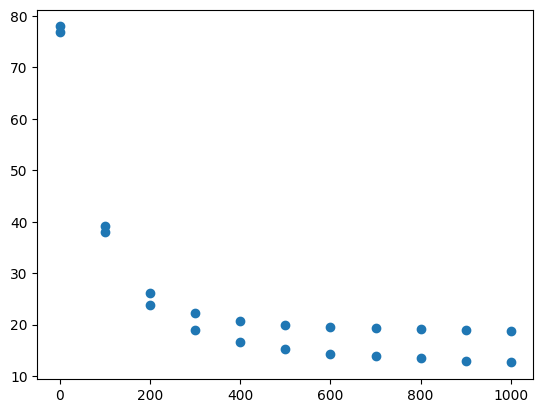

In [258]:
content = ['1000, 12.6445977',
'900, 12.9851948',
'800, 13.4393400',	
'700, 13.8544334',
'600, 14.3755244',
'500, 15.1869804',
'400, 16.6392936',
'300, 18.9503841',
'200, 23.8324074',
'100, 37.9762457',
'  0, 76.9489107',
'1000, 18.7264156',
'900, 18.8824706',
'800, 19.0851572',	
'700, 19.2677033',
'600, 19.5037303',
'500, 19.9269454',
'400, 20.7602342',
'300, 22.3534509',
'200, 26.0922866',
'100, 39.1346243',
'  0, 77.9382591',]


# content = [ '0, 106.4547436',
#           '0, 106.9794300',
#                 '100,  50.5667364',
#                 '100,  51.0389052', 
#                 '200, 32.9167501',
#                 '200,  31.8413667', 
#                 '300, 27.4238521',
#                 '300,  24.9767677',
#                 '400, 25.2605638',
#                 '400,  21.6378206', 
#                 '500, 24.1947236',
#                 '500,  19.5355443',
#                 '700,  23.1968063',
#                 '700,  17.2279570',
#                 '900,  22.7127135',
#                 '900,  15.8937070',
#                 '1100,  22.3295488',
#                 '1100,  14.7444985',
#                 '1300,  22.0179101',
#                 '1300,  13.5533399',
#                 '1500,  21.7720602',
#                 '1500,  12.5172403',
#                 '1700,  21.5726452',
#                 '1700,  11.4304411',
#                 '1800,  10.8499503',
#                 '1800,  21.4721213',
#                 '2000,  21.2916108',
#                 '2000,  10.0272054',
#                 '2300, 21.1748730',
#                 '2300,  9.4328573' ,
#                 '2560, 21.1114423',
#                 '2560,  9.1530312']


x = [float(i.split(',')[0]) for i in content]
y = [float(i.split(',')[1]) for i in content]

#print(x, y, z)
fig = plt.figure()
ax = plt.axes()

ax.scatter(x, y)


In [138]:
#SAVE CAT-MODEL
saveModel_XGBOOST(cat_model, 'CAT_140_64Features_A')


In [140]:
from sklearn.metrics import mean_absolute_error
o = retrieveModel_XGBOOST("CAT_142_64Features_A")
pr = o.predict(X_A_tr_trees)
print(mean_absolute_error(pr, Y_A_tr_trees))

75.93333710747487


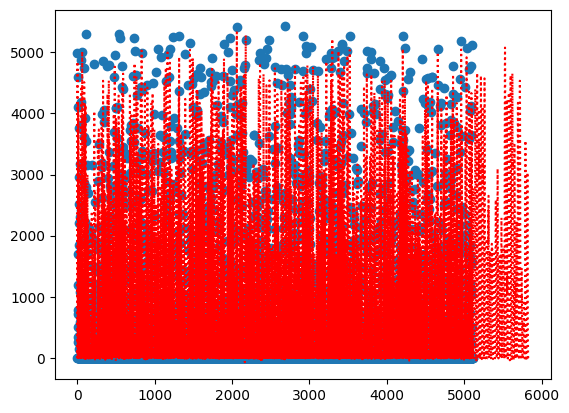

<Figure size 10000x1000 with 0 Axes>

In [157]:
#PLOT CATBOOST
def plot_predictions(y_test, actual):
    plt.plot(y_test, linestyle = 'dotted', color='red')
    x = []
    for i in range(0,len(actual)):
      x.append(i)
    plt.scatter(x, actual)
    plt.figure(figsize=(100,10))
    plt.show()

xx = retrieveModel_XGBOOST('CAT_142_64Features_A')   
pred_tr = xx.predict(X_A_te_trees)
pred_te = xx.predict(testData_A_tree)
allPreds = np.append(pred_tr, pred_te, axis=0)


plot_predictions(allPreds, pd.DataFrame(Y_A_te_trees)['Y'])


input dim:  64
kernel size:  31
Epoch 1/1000
1206/1207 [============================>.] - ETA: 0s - loss: 321.1537 - mean_absolute_error: 321.1537
Epoch 1: val_loss improved from inf to 218.96832, saving model to data/models\
INFO:tensorflow:Assets written to: data/models\assets


INFO:tensorflow:Assets written to: data/models\assets


1207/1207 [==============================] - 24s 18ms/step - loss: 321.0772 - mean_absolute_error: 321.0772 - val_loss: 218.9683 - val_mean_absolute_error: 218.9683
Epoch 2/1000
1205/1207 [============================>.] - ETA: 0s - loss: 223.2233 - mean_absolute_error: 223.2233
Epoch 2: val_loss improved from 218.96832 to 213.62209, saving model to data/models\
INFO:tensorflow:Assets written to: data/models\assets


INFO:tensorflow:Assets written to: data/models\assets


1207/1207 [==============================] - 22s 18ms/step - loss: 223.1849 - mean_absolute_error: 223.1849 - val_loss: 213.6221 - val_mean_absolute_error: 213.6221
Epoch 3/1000
1206/1207 [============================>.] - ETA: 0s - loss: 217.5640 - mean_absolute_error: 217.5640
Epoch 3: val_loss improved from 213.62209 to 205.33951, saving model to data/models\
INFO:tensorflow:Assets written to: data/models\assets


INFO:tensorflow:Assets written to: data/models\assets


1207/1207 [==============================] - 22s 18ms/step - loss: 217.5468 - mean_absolute_error: 217.5468 - val_loss: 205.3395 - val_mean_absolute_error: 205.3395
Epoch 4/1000
1204/1207 [============================>.] - ETA: 0s - loss: 214.0694 - mean_absolute_error: 214.0694
Epoch 4: val_loss did not improve from 205.33951
1207/1207 [==============================] - 21s 17ms/step - loss: 213.9111 - mean_absolute_error: 213.9111 - val_loss: 211.8336 - val_mean_absolute_error: 211.8336
Epoch 5/1000
1207/1207 [==============================] - ETA: 0s - loss: 212.3341 - mean_absolute_error: 212.3341
Epoch 5: val_loss did not improve from 205.33951
1207/1207 [==============================] - 20s 17ms/step - loss: 212.3341 - mean_absolute_error: 212.3341 - val_loss: 211.0818 - val_mean_absolute_error: 211.0818
Epoch 6/1000
1204/1207 [============================>.] - ETA: 0s - loss: 210.3415 - mean_absolute_error: 210.3415
Epoch 6: val_loss improved from 205.33951 to 202.24321, saving

INFO:tensorflow:Assets written to: data/models\assets


1207/1207 [==============================] - 23s 19ms/step - loss: 210.3485 - mean_absolute_error: 210.3485 - val_loss: 202.2432 - val_mean_absolute_error: 202.2432
Epoch 7/1000
1206/1207 [============================>.] - ETA: 0s - loss: 209.3947 - mean_absolute_error: 209.3947
Epoch 7: val_loss did not improve from 202.24321
1207/1207 [==============================] - 19s 15ms/step - loss: 209.3445 - mean_absolute_error: 209.3445 - val_loss: 202.7710 - val_mean_absolute_error: 202.7710
Epoch 8/1000
1207/1207 [==============================] - ETA: 0s - loss: 207.3992 - mean_absolute_error: 207.3992
Epoch 8: val_loss improved from 202.24321 to 199.33630, saving model to data/models\
INFO:tensorflow:Assets written to: data/models\assets


INFO:tensorflow:Assets written to: data/models\assets


1207/1207 [==============================] - 20s 17ms/step - loss: 207.3992 - mean_absolute_error: 207.3992 - val_loss: 199.3363 - val_mean_absolute_error: 199.3363
Epoch 9/1000
1203/1207 [============================>.] - ETA: 0s - loss: 206.2391 - mean_absolute_error: 206.2391
Epoch 9: val_loss improved from 199.33630 to 196.89778, saving model to data/models\
INFO:tensorflow:Assets written to: data/models\assets


INFO:tensorflow:Assets written to: data/models\assets


1207/1207 [==============================] - 21s 17ms/step - loss: 206.2093 - mean_absolute_error: 206.2093 - val_loss: 196.8978 - val_mean_absolute_error: 196.8978
Epoch 10/1000
1205/1207 [============================>.] - ETA: 0s - loss: 205.1444 - mean_absolute_error: 205.1444
Epoch 10: val_loss improved from 196.89778 to 195.44315, saving model to data/models\
INFO:tensorflow:Assets written to: data/models\assets


INFO:tensorflow:Assets written to: data/models\assets


1207/1207 [==============================] - 20s 17ms/step - loss: 205.0822 - mean_absolute_error: 205.0822 - val_loss: 195.4431 - val_mean_absolute_error: 195.4431
Epoch 11/1000
1206/1207 [============================>.] - ETA: 0s - loss: 203.5010 - mean_absolute_error: 203.5010
Epoch 11: val_loss did not improve from 195.44315
1207/1207 [==============================] - 19s 15ms/step - loss: 203.5078 - mean_absolute_error: 203.5078 - val_loss: 196.7165 - val_mean_absolute_error: 196.7165
Epoch 12/1000
1205/1207 [============================>.] - ETA: 0s - loss: 202.5940 - mean_absolute_error: 202.5940
Epoch 12: val_loss improved from 195.44315 to 194.09988, saving model to data/models\
INFO:tensorflow:Assets written to: data/models\assets


INFO:tensorflow:Assets written to: data/models\assets


1207/1207 [==============================] - 21s 17ms/step - loss: 202.4950 - mean_absolute_error: 202.4950 - val_loss: 194.0999 - val_mean_absolute_error: 194.0999
Epoch 13/1000
1206/1207 [============================>.] - ETA: 0s - loss: 201.6502 - mean_absolute_error: 201.6502
Epoch 13: val_loss improved from 194.09988 to 192.09558, saving model to data/models\
INFO:tensorflow:Assets written to: data/models\assets


INFO:tensorflow:Assets written to: data/models\assets


1207/1207 [==============================] - 21s 17ms/step - loss: 201.6086 - mean_absolute_error: 201.6086 - val_loss: 192.0956 - val_mean_absolute_error: 192.0956
Epoch 14/1000
1205/1207 [============================>.] - ETA: 0s - loss: 200.7952 - mean_absolute_error: 200.7952
Epoch 14: val_loss improved from 192.09558 to 191.69986, saving model to data/models\
INFO:tensorflow:Assets written to: data/models\assets


INFO:tensorflow:Assets written to: data/models\assets


1207/1207 [==============================] - 21s 17ms/step - loss: 200.6967 - mean_absolute_error: 200.6967 - val_loss: 191.6999 - val_mean_absolute_error: 191.6999
Epoch 15/1000
1205/1207 [============================>.] - ETA: 0s - loss: 199.1134 - mean_absolute_error: 199.1134
Epoch 15: val_loss improved from 191.69986 to 191.64627, saving model to data/models\
INFO:tensorflow:Assets written to: data/models\assets


INFO:tensorflow:Assets written to: data/models\assets


1207/1207 [==============================] - 20s 17ms/step - loss: 199.2227 - mean_absolute_error: 199.2227 - val_loss: 191.6463 - val_mean_absolute_error: 191.6463
Epoch 16/1000
1205/1207 [============================>.] - ETA: 0s - loss: 198.3004 - mean_absolute_error: 198.3004
Epoch 16: val_loss improved from 191.64627 to 190.58678, saving model to data/models\
INFO:tensorflow:Assets written to: data/models\assets


INFO:tensorflow:Assets written to: data/models\assets


1207/1207 [==============================] - 20s 17ms/step - loss: 198.3895 - mean_absolute_error: 198.3894 - val_loss: 190.5868 - val_mean_absolute_error: 190.5868
Epoch 17/1000
1207/1207 [==============================] - ETA: 0s - loss: 197.7988 - mean_absolute_error: 197.7988
Epoch 17: val_loss improved from 190.58678 to 188.35687, saving model to data/models\
INFO:tensorflow:Assets written to: data/models\assets


INFO:tensorflow:Assets written to: data/models\assets


1207/1207 [==============================] - 21s 17ms/step - loss: 197.7988 - mean_absolute_error: 197.7988 - val_loss: 188.3569 - val_mean_absolute_error: 188.3569
Epoch 18/1000
1206/1207 [============================>.] - ETA: 0s - loss: 196.3170 - mean_absolute_error: 196.3170
Epoch 18: val_loss improved from 188.35687 to 186.90837, saving model to data/models\
INFO:tensorflow:Assets written to: data/models\assets


INFO:tensorflow:Assets written to: data/models\assets


1207/1207 [==============================] - 20s 17ms/step - loss: 196.2746 - mean_absolute_error: 196.2746 - val_loss: 186.9084 - val_mean_absolute_error: 186.9084
Epoch 19/1000
1204/1207 [============================>.] - ETA: 0s - loss: 195.0002 - mean_absolute_error: 195.0002
Epoch 19: val_loss did not improve from 186.90837
1207/1207 [==============================] - 19s 16ms/step - loss: 195.0216 - mean_absolute_error: 195.0216 - val_loss: 187.6404 - val_mean_absolute_error: 187.6404
Epoch 20/1000
1206/1207 [============================>.] - ETA: 0s - loss: 194.4550 - mean_absolute_error: 194.4550
Epoch 20: val_loss did not improve from 186.90837
1207/1207 [==============================] - 19s 16ms/step - loss: 194.4459 - mean_absolute_error: 194.4459 - val_loss: 187.1898 - val_mean_absolute_error: 187.1898
Epoch 21/1000
1204/1207 [============================>.] - ETA: 0s - loss: 194.0734 - mean_absolute_error: 194.0734
Epoch 21: val_loss improved from 186.90837 to 185.64066, 

INFO:tensorflow:Assets written to: data/models\assets


1207/1207 [==============================] - 21s 18ms/step - loss: 194.0059 - mean_absolute_error: 194.0059 - val_loss: 185.6407 - val_mean_absolute_error: 185.6407
Epoch 22/1000
1204/1207 [============================>.] - ETA: 0s - loss: 193.1581 - mean_absolute_error: 193.1581
Epoch 22: val_loss did not improve from 185.64066
1207/1207 [==============================] - 18s 15ms/step - loss: 193.1839 - mean_absolute_error: 193.1839 - val_loss: 186.8684 - val_mean_absolute_error: 186.8684
Epoch 23/1000
1207/1207 [==============================] - ETA: 0s - loss: 192.4721 - mean_absolute_error: 192.4721
Epoch 23: val_loss improved from 185.64066 to 184.36543, saving model to data/models\
INFO:tensorflow:Assets written to: data/models\assets


INFO:tensorflow:Assets written to: data/models\assets


1207/1207 [==============================] - 20s 17ms/step - loss: 192.4721 - mean_absolute_error: 192.4721 - val_loss: 184.3654 - val_mean_absolute_error: 184.3654
Epoch 24/1000
1206/1207 [============================>.] - ETA: 0s - loss: 191.9319 - mean_absolute_error: 191.9319
Epoch 24: val_loss did not improve from 184.36543
1207/1207 [==============================] - 19s 16ms/step - loss: 191.8909 - mean_absolute_error: 191.8909 - val_loss: 184.9819 - val_mean_absolute_error: 184.9819
Epoch 25/1000
1206/1207 [============================>.] - ETA: 0s - loss: 190.8473 - mean_absolute_error: 190.8473
Epoch 25: val_loss improved from 184.36543 to 184.24182, saving model to data/models\
INFO:tensorflow:Assets written to: data/models\assets


INFO:tensorflow:Assets written to: data/models\assets


1207/1207 [==============================] - 20s 17ms/step - loss: 190.8920 - mean_absolute_error: 190.8920 - val_loss: 184.2418 - val_mean_absolute_error: 184.2418
Epoch 26/1000
1207/1207 [==============================] - ETA: 0s - loss: 190.5327 - mean_absolute_error: 190.5327
Epoch 26: val_loss improved from 184.24182 to 184.00188, saving model to data/models\
INFO:tensorflow:Assets written to: data/models\assets


INFO:tensorflow:Assets written to: data/models\assets


1207/1207 [==============================] - 21s 17ms/step - loss: 190.5327 - mean_absolute_error: 190.5327 - val_loss: 184.0019 - val_mean_absolute_error: 184.0019
Epoch 27/1000
1205/1207 [============================>.] - ETA: 0s - loss: 190.5061 - mean_absolute_error: 190.5061
Epoch 27: val_loss improved from 184.00188 to 182.94852, saving model to data/models\
INFO:tensorflow:Assets written to: data/models\assets


INFO:tensorflow:Assets written to: data/models\assets


1207/1207 [==============================] - 20s 17ms/step - loss: 190.4551 - mean_absolute_error: 190.4551 - val_loss: 182.9485 - val_mean_absolute_error: 182.9485
Epoch 28/1000
1205/1207 [============================>.] - ETA: 0s - loss: 189.1754 - mean_absolute_error: 189.1754
Epoch 28: val_loss improved from 182.94852 to 182.40709, saving model to data/models\
INFO:tensorflow:Assets written to: data/models\assets


INFO:tensorflow:Assets written to: data/models\assets


1207/1207 [==============================] - 20s 16ms/step - loss: 189.1768 - mean_absolute_error: 189.1768 - val_loss: 182.4071 - val_mean_absolute_error: 182.4071
Epoch 29/1000
1205/1207 [============================>.] - ETA: 0s - loss: 189.2724 - mean_absolute_error: 189.2724
Epoch 29: val_loss improved from 182.40709 to 182.33586, saving model to data/models\
INFO:tensorflow:Assets written to: data/models\assets


INFO:tensorflow:Assets written to: data/models\assets


1207/1207 [==============================] - 21s 17ms/step - loss: 189.2221 - mean_absolute_error: 189.2221 - val_loss: 182.3359 - val_mean_absolute_error: 182.3359
Epoch 30/1000
1206/1207 [============================>.] - ETA: 0s - loss: 189.6214 - mean_absolute_error: 189.6214
Epoch 30: val_loss improved from 182.33586 to 180.80222, saving model to data/models\
INFO:tensorflow:Assets written to: data/models\assets


INFO:tensorflow:Assets written to: data/models\assets


1207/1207 [==============================] - 20s 17ms/step - loss: 189.5977 - mean_absolute_error: 189.5977 - val_loss: 180.8022 - val_mean_absolute_error: 180.8022
Epoch 31/1000
1205/1207 [============================>.] - ETA: 0s - loss: 188.3483 - mean_absolute_error: 188.3483
Epoch 31: val_loss did not improve from 180.80222
1207/1207 [==============================] - 18s 15ms/step - loss: 188.2436 - mean_absolute_error: 188.2436 - val_loss: 180.9014 - val_mean_absolute_error: 180.9014
Epoch 32/1000
1206/1207 [============================>.] - ETA: 0s - loss: 188.1995 - mean_absolute_error: 188.1995
Epoch 32: val_loss did not improve from 180.80222
1207/1207 [==============================] - 19s 16ms/step - loss: 188.1724 - mean_absolute_error: 188.1724 - val_loss: 181.6935 - val_mean_absolute_error: 181.6935
Epoch 33/1000
1205/1207 [============================>.] - ETA: 0s - loss: 186.9875 - mean_absolute_error: 186.9875
Epoch 33: val_loss did not improve from 180.80222
1207/12

INFO:tensorflow:Assets written to: data/models\assets


1207/1207 [==============================] - 21s 17ms/step - loss: 186.8821 - mean_absolute_error: 186.8821 - val_loss: 179.6313 - val_mean_absolute_error: 179.6313
Epoch 35/1000
1204/1207 [============================>.] - ETA: 0s - loss: 186.6352 - mean_absolute_error: 186.6352
Epoch 35: val_loss improved from 179.63129 to 179.35664, saving model to data/models\
INFO:tensorflow:Assets written to: data/models\assets


INFO:tensorflow:Assets written to: data/models\assets


1207/1207 [==============================] - 20s 17ms/step - loss: 186.8394 - mean_absolute_error: 186.8394 - val_loss: 179.3566 - val_mean_absolute_error: 179.3566
Epoch 36/1000
1205/1207 [============================>.] - ETA: 0s - loss: 186.0837 - mean_absolute_error: 186.0837
Epoch 36: val_loss did not improve from 179.35664
1207/1207 [==============================] - 19s 15ms/step - loss: 186.1908 - mean_absolute_error: 186.1908 - val_loss: 183.1279 - val_mean_absolute_error: 183.1279
Epoch 37/1000
1206/1207 [============================>.] - ETA: 0s - loss: 186.6099 - mean_absolute_error: 186.6099
Epoch 37: val_loss improved from 179.35664 to 179.08525, saving model to data/models\
INFO:tensorflow:Assets written to: data/models\assets


INFO:tensorflow:Assets written to: data/models\assets


1207/1207 [==============================] - 20s 17ms/step - loss: 186.7205 - mean_absolute_error: 186.7205 - val_loss: 179.0853 - val_mean_absolute_error: 179.0853
Epoch 38/1000
1207/1207 [==============================] - ETA: 0s - loss: 185.1826 - mean_absolute_error: 185.1826
Epoch 38: val_loss improved from 179.08525 to 178.84036, saving model to data/models\
INFO:tensorflow:Assets written to: data/models\assets


INFO:tensorflow:Assets written to: data/models\assets


1207/1207 [==============================] - 20s 17ms/step - loss: 185.1826 - mean_absolute_error: 185.1826 - val_loss: 178.8404 - val_mean_absolute_error: 178.8404
Epoch 39/1000
1207/1207 [==============================] - ETA: 0s - loss: 185.3081 - mean_absolute_error: 185.3081
Epoch 39: val_loss did not improve from 178.84036
1207/1207 [==============================] - 19s 15ms/step - loss: 185.3081 - mean_absolute_error: 185.3081 - val_loss: 181.0306 - val_mean_absolute_error: 181.0306
Epoch 40/1000
1207/1207 [==============================] - ETA: 0s - loss: 184.9858 - mean_absolute_error: 184.9858
Epoch 40: val_loss improved from 178.84036 to 178.49348, saving model to data/models\
INFO:tensorflow:Assets written to: data/models\assets


INFO:tensorflow:Assets written to: data/models\assets


1207/1207 [==============================] - 21s 17ms/step - loss: 184.9858 - mean_absolute_error: 184.9858 - val_loss: 178.4935 - val_mean_absolute_error: 178.4935
Epoch 41/1000
1204/1207 [============================>.] - ETA: 0s - loss: 184.6689 - mean_absolute_error: 184.6689
Epoch 41: val_loss improved from 178.49348 to 178.04343, saving model to data/models\
INFO:tensorflow:Assets written to: data/models\assets


INFO:tensorflow:Assets written to: data/models\assets


1207/1207 [==============================] - 20s 17ms/step - loss: 184.5701 - mean_absolute_error: 184.5701 - val_loss: 178.0434 - val_mean_absolute_error: 178.0434
Epoch 42/1000
1206/1207 [============================>.] - ETA: 0s - loss: 184.2401 - mean_absolute_error: 184.2401
Epoch 42: val_loss did not improve from 178.04343
1207/1207 [==============================] - 18s 15ms/step - loss: 184.2001 - mean_absolute_error: 184.2001 - val_loss: 178.5565 - val_mean_absolute_error: 178.5565
Epoch 43/1000
1207/1207 [==============================] - ETA: 0s - loss: 183.7366 - mean_absolute_error: 183.7366
Epoch 43: val_loss did not improve from 178.04343
1207/1207 [==============================] - 18s 15ms/step - loss: 183.7366 - mean_absolute_error: 183.7366 - val_loss: 180.1915 - val_mean_absolute_error: 180.1915
Epoch 44/1000
1206/1207 [============================>.] - ETA: 0s - loss: 183.8440 - mean_absolute_error: 183.8440
Epoch 44: val_loss did not improve from 178.04343
1207/12

INFO:tensorflow:Assets written to: data/models\assets


1207/1207 [==============================] - 21s 17ms/step - loss: 183.5850 - mean_absolute_error: 183.5850 - val_loss: 177.1653 - val_mean_absolute_error: 177.1653
Epoch 46/1000
1207/1207 [==============================] - ETA: 0s - loss: 183.1546 - mean_absolute_error: 183.1546
Epoch 46: val_loss improved from 177.16533 to 176.78769, saving model to data/models\
INFO:tensorflow:Assets written to: data/models\assets


INFO:tensorflow:Assets written to: data/models\assets


1207/1207 [==============================] - 20s 17ms/step - loss: 183.1546 - mean_absolute_error: 183.1546 - val_loss: 176.7877 - val_mean_absolute_error: 176.7877
Epoch 47/1000
1204/1207 [============================>.] - ETA: 0s - loss: 182.9004 - mean_absolute_error: 182.9004
Epoch 47: val_loss did not improve from 176.78769
1207/1207 [==============================] - 18s 15ms/step - loss: 182.8555 - mean_absolute_error: 182.8555 - val_loss: 178.6488 - val_mean_absolute_error: 178.6488
Epoch 48/1000
1206/1207 [============================>.] - ETA: 0s - loss: 182.8548 - mean_absolute_error: 182.8548
Epoch 48: val_loss improved from 176.78769 to 176.69688, saving model to data/models\
INFO:tensorflow:Assets written to: data/models\assets


INFO:tensorflow:Assets written to: data/models\assets


1207/1207 [==============================] - 21s 17ms/step - loss: 182.8588 - mean_absolute_error: 182.8588 - val_loss: 176.6969 - val_mean_absolute_error: 176.6969
Epoch 49/1000
1207/1207 [==============================] - ETA: 0s - loss: 182.5283 - mean_absolute_error: 182.5283
Epoch 49: val_loss did not improve from 176.69688
1207/1207 [==============================] - 18s 15ms/step - loss: 182.5283 - mean_absolute_error: 182.5283 - val_loss: 177.8609 - val_mean_absolute_error: 177.8609
Epoch 50/1000
1206/1207 [============================>.] - ETA: 0s - loss: 182.5127 - mean_absolute_error: 182.5127
Epoch 50: val_loss improved from 176.69688 to 176.37065, saving model to data/models\
INFO:tensorflow:Assets written to: data/models\assets


INFO:tensorflow:Assets written to: data/models\assets


1207/1207 [==============================] - 20s 17ms/step - loss: 182.5125 - mean_absolute_error: 182.5125 - val_loss: 176.3707 - val_mean_absolute_error: 176.3707
Epoch 51/1000
1207/1207 [==============================] - ETA: 0s - loss: 181.8605 - mean_absolute_error: 181.8605
Epoch 51: val_loss improved from 176.37065 to 176.10583, saving model to data/models\
INFO:tensorflow:Assets written to: data/models\assets


INFO:tensorflow:Assets written to: data/models\assets


1207/1207 [==============================] - 21s 17ms/step - loss: 181.8605 - mean_absolute_error: 181.8605 - val_loss: 176.1058 - val_mean_absolute_error: 176.1058
Epoch 52/1000
1204/1207 [============================>.] - ETA: 0s - loss: 181.9828 - mean_absolute_error: 181.9828
Epoch 52: val_loss did not improve from 176.10583
1207/1207 [==============================] - 18s 15ms/step - loss: 181.8963 - mean_absolute_error: 181.8963 - val_loss: 177.3799 - val_mean_absolute_error: 177.3799
Epoch 53/1000
1205/1207 [============================>.] - ETA: 0s - loss: 181.5560 - mean_absolute_error: 181.5560
Epoch 53: val_loss improved from 176.10583 to 175.80728, saving model to data/models\
INFO:tensorflow:Assets written to: data/models\assets


INFO:tensorflow:Assets written to: data/models\assets


1207/1207 [==============================] - 20s 17ms/step - loss: 181.6582 - mean_absolute_error: 181.6582 - val_loss: 175.8073 - val_mean_absolute_error: 175.8073
Epoch 54/1000
1205/1207 [============================>.] - ETA: 0s - loss: 181.4555 - mean_absolute_error: 181.4555
Epoch 54: val_loss did not improve from 175.80728
1207/1207 [==============================] - 18s 15ms/step - loss: 181.5225 - mean_absolute_error: 181.5225 - val_loss: 176.9380 - val_mean_absolute_error: 176.9380
Epoch 55/1000
1206/1207 [============================>.] - ETA: 0s - loss: 181.0774 - mean_absolute_error: 181.0774
Epoch 55: val_loss improved from 175.80728 to 174.85001, saving model to data/models\
INFO:tensorflow:Assets written to: data/models\assets


INFO:tensorflow:Assets written to: data/models\assets


1207/1207 [==============================] - 20s 17ms/step - loss: 181.0577 - mean_absolute_error: 181.0577 - val_loss: 174.8500 - val_mean_absolute_error: 174.8500
Epoch 56/1000
1207/1207 [==============================] - ETA: 0s - loss: 180.5520 - mean_absolute_error: 180.5520
Epoch 56: val_loss did not improve from 174.85001
1207/1207 [==============================] - 18s 15ms/step - loss: 180.5520 - mean_absolute_error: 180.5520 - val_loss: 177.6562 - val_mean_absolute_error: 177.6562
Epoch 57/1000
1204/1207 [============================>.] - ETA: 0s - loss: 180.5673 - mean_absolute_error: 180.5673
Epoch 57: val_loss did not improve from 174.85001
1207/1207 [==============================] - 18s 15ms/step - loss: 180.4901 - mean_absolute_error: 180.4901 - val_loss: 182.2181 - val_mean_absolute_error: 182.2181
Epoch 58/1000
1205/1207 [============================>.] - ETA: 0s - loss: 180.1665 - mean_absolute_error: 180.1665
Epoch 58: val_loss improved from 174.85001 to 174.66620, 

INFO:tensorflow:Assets written to: data/models\assets


1207/1207 [==============================] - 20s 16ms/step - loss: 180.1082 - mean_absolute_error: 180.1082 - val_loss: 174.6662 - val_mean_absolute_error: 174.6662
Epoch 59/1000
1206/1207 [============================>.] - ETA: 0s - loss: 180.0294 - mean_absolute_error: 180.0294
Epoch 59: val_loss improved from 174.66620 to 174.39830, saving model to data/models\
INFO:tensorflow:Assets written to: data/models\assets


INFO:tensorflow:Assets written to: data/models\assets


1207/1207 [==============================] - 21s 17ms/step - loss: 179.9929 - mean_absolute_error: 179.9929 - val_loss: 174.3983 - val_mean_absolute_error: 174.3983
Epoch 60/1000
1207/1207 [==============================] - ETA: 0s - loss: 179.9666 - mean_absolute_error: 179.9666
Epoch 60: val_loss did not improve from 174.39830
1207/1207 [==============================] - 19s 15ms/step - loss: 179.9666 - mean_absolute_error: 179.9666 - val_loss: 175.1115 - val_mean_absolute_error: 175.1115
Epoch 61/1000
1205/1207 [============================>.] - ETA: 0s - loss: 179.8679 - mean_absolute_error: 179.8679
Epoch 61: val_loss did not improve from 174.39830
1207/1207 [==============================] - 19s 15ms/step - loss: 179.9626 - mean_absolute_error: 179.9626 - val_loss: 180.8461 - val_mean_absolute_error: 180.8461
Epoch 62/1000
1205/1207 [============================>.] - ETA: 0s - loss: 179.9374 - mean_absolute_error: 179.9374
Epoch 62: val_loss did not improve from 174.39830
1207/12

INFO:tensorflow:Assets written to: data/models\assets


1207/1207 [==============================] - 21s 17ms/step - loss: 178.8250 - mean_absolute_error: 178.8250 - val_loss: 174.1663 - val_mean_absolute_error: 174.1663
Epoch 66/1000
1204/1207 [============================>.] - ETA: 0s - loss: 179.4425 - mean_absolute_error: 179.4425
Epoch 66: val_loss did not improve from 174.16626
1207/1207 [==============================] - 18s 15ms/step - loss: 179.3557 - mean_absolute_error: 179.3557 - val_loss: 178.0375 - val_mean_absolute_error: 178.0375
Epoch 67/1000
1205/1207 [============================>.] - ETA: 0s - loss: 178.7447 - mean_absolute_error: 178.7447
Epoch 67: val_loss did not improve from 174.16626
1207/1207 [==============================] - 18s 15ms/step - loss: 178.7345 - mean_absolute_error: 178.7345 - val_loss: 175.8772 - val_mean_absolute_error: 175.8772
Epoch 68/1000
1204/1207 [============================>.] - ETA: 0s - loss: 179.1719 - mean_absolute_error: 179.1719
Epoch 68: val_loss did not improve from 174.16626
1207/12

INFO:tensorflow:Assets written to: data/models\assets


1207/1207 [==============================] - 21s 17ms/step - loss: 178.6353 - mean_absolute_error: 178.6353 - val_loss: 173.6313 - val_mean_absolute_error: 173.6313
Epoch 70/1000
1205/1207 [============================>.] - ETA: 0s - loss: 178.2011 - mean_absolute_error: 178.2011
Epoch 70: val_loss did not improve from 173.63126
1207/1207 [==============================] - 19s 16ms/step - loss: 178.2070 - mean_absolute_error: 178.2070 - val_loss: 179.8860 - val_mean_absolute_error: 179.8860
Epoch 71/1000
1207/1207 [==============================] - ETA: 0s - loss: 178.3955 - mean_absolute_error: 178.3955
Epoch 71: val_loss did not improve from 173.63126
1207/1207 [==============================] - 18s 15ms/step - loss: 178.3955 - mean_absolute_error: 178.3955 - val_loss: 181.2116 - val_mean_absolute_error: 181.2116
Epoch 72/1000
1206/1207 [============================>.] - ETA: 0s - loss: 178.3503 - mean_absolute_error: 178.3503
Epoch 72: val_loss did not improve from 173.63126
1207/12

INFO:tensorflow:Assets written to: data/models\assets


1207/1207 [==============================] - 21s 17ms/step - loss: 177.7519 - mean_absolute_error: 177.7519 - val_loss: 173.1677 - val_mean_absolute_error: 173.1677
Epoch 74/1000
1206/1207 [============================>.] - ETA: 0s - loss: 177.5651 - mean_absolute_error: 177.5651
Epoch 74: val_loss did not improve from 173.16768
1207/1207 [==============================] - 21s 17ms/step - loss: 177.5446 - mean_absolute_error: 177.5446 - val_loss: 175.6129 - val_mean_absolute_error: 175.6129
Epoch 75/1000
1206/1207 [============================>.] - ETA: 0s - loss: 178.4915 - mean_absolute_error: 178.4915
Epoch 75: val_loss did not improve from 173.16768
1207/1207 [==============================] - 22s 18ms/step - loss: 178.4597 - mean_absolute_error: 178.4597 - val_loss: 173.9747 - val_mean_absolute_error: 173.9747
Epoch 76/1000
1207/1207 [==============================] - ETA: 0s - loss: 177.7946 - mean_absolute_error: 177.7946
Epoch 76: val_loss did not improve from 173.16768
1207/12

INFO:tensorflow:Assets written to: data/models\assets


1207/1207 [==============================] - 23s 19ms/step - loss: 175.7374 - mean_absolute_error: 175.7374 - val_loss: 171.5522 - val_mean_absolute_error: 171.5522
Epoch 93/1000
1207/1207 [==============================] - ETA: 0s - loss: 175.3600 - mean_absolute_error: 175.3600
Epoch 93: val_loss did not improve from 171.55222
1207/1207 [==============================] - 19s 16ms/step - loss: 175.3600 - mean_absolute_error: 175.3600 - val_loss: 172.5566 - val_mean_absolute_error: 172.5566
Epoch 94/1000
1206/1207 [============================>.] - ETA: 0s - loss: 175.3414 - mean_absolute_error: 175.3414
Epoch 94: val_loss did not improve from 171.55222
1207/1207 [==============================] - 19s 16ms/step - loss: 175.3387 - mean_absolute_error: 175.3387 - val_loss: 177.5342 - val_mean_absolute_error: 177.5342
Epoch 95/1000
1207/1207 [==============================] - ETA: 0s - loss: 175.7483 - mean_absolute_error: 175.7483
Epoch 95: val_loss did not improve from 171.55222
1207/12

INFO:tensorflow:Assets written to: data/models\assets


1207/1207 [==============================] - 21s 18ms/step - loss: 173.1401 - mean_absolute_error: 173.1401 - val_loss: 171.4831 - val_mean_absolute_error: 171.4831
Epoch 118/1000
1206/1207 [============================>.] - ETA: 0s - loss: 172.5720 - mean_absolute_error: 172.5720
Epoch 118: val_loss improved from 171.48314 to 171.12639, saving model to data/models\
INFO:tensorflow:Assets written to: data/models\assets


INFO:tensorflow:Assets written to: data/models\assets


1207/1207 [==============================] - 22s 18ms/step - loss: 172.5755 - mean_absolute_error: 172.5755 - val_loss: 171.1264 - val_mean_absolute_error: 171.1264
Epoch 119/1000
1206/1207 [============================>.] - ETA: 0s - loss: 172.3951 - mean_absolute_error: 172.3951
Epoch 119: val_loss did not improve from 171.12639
1207/1207 [==============================] - 19s 16ms/step - loss: 172.4052 - mean_absolute_error: 172.4052 - val_loss: 177.8197 - val_mean_absolute_error: 177.8197
Epoch 120/1000
1206/1207 [============================>.] - ETA: 0s - loss: 172.1469 - mean_absolute_error: 172.1469
Epoch 120: val_loss did not improve from 171.12639
1207/1207 [==============================] - 18s 15ms/step - loss: 172.2354 - mean_absolute_error: 172.2354 - val_loss: 172.4218 - val_mean_absolute_error: 172.4218
Epoch 121/1000
1207/1207 [==============================] - ETA: 0s - loss: 171.7912 - mean_absolute_error: 171.7912
Epoch 121: val_loss did not improve from 171.12639
1

INFO:tensorflow:Assets written to: data/models\assets


1207/1207 [==============================] - 22s 18ms/step - loss: 172.1214 - mean_absolute_error: 172.1214 - val_loss: 170.1482 - val_mean_absolute_error: 170.1482
Epoch 124/1000
1206/1207 [============================>.] - ETA: 0s - loss: 171.5761 - mean_absolute_error: 171.5761
Epoch 124: val_loss did not improve from 170.14824
1207/1207 [==============================] - 18s 15ms/step - loss: 171.5582 - mean_absolute_error: 171.5582 - val_loss: 172.3064 - val_mean_absolute_error: 172.3064
Epoch 125/1000
1206/1207 [============================>.] - ETA: 0s - loss: 171.6950 - mean_absolute_error: 171.6950
Epoch 125: val_loss did not improve from 170.14824
1207/1207 [==============================] - 18s 15ms/step - loss: 171.6821 - mean_absolute_error: 171.6821 - val_loss: 171.4932 - val_mean_absolute_error: 171.4932
Epoch 126/1000
1206/1207 [============================>.] - ETA: 0s - loss: 171.4298 - mean_absolute_error: 171.4298
Epoch 126: val_loss did not improve from 170.14824
1

INFO:tensorflow:Assets written to: data/models\assets


1207/1207 [==============================] - 21s 17ms/step - loss: 171.1957 - mean_absolute_error: 171.1957 - val_loss: 169.0564 - val_mean_absolute_error: 169.0564
Epoch 129/1000
1207/1207 [==============================] - ETA: 0s - loss: 171.0175 - mean_absolute_error: 171.0175
Epoch 129: val_loss did not improve from 169.05641
1207/1207 [==============================] - 18s 15ms/step - loss: 171.0175 - mean_absolute_error: 171.0175 - val_loss: 173.6493 - val_mean_absolute_error: 173.6493
Epoch 130/1000
1205/1207 [============================>.] - ETA: 0s - loss: 171.0460 - mean_absolute_error: 171.0460
Epoch 130: val_loss did not improve from 169.05641
1207/1207 [==============================] - 18s 15ms/step - loss: 170.9889 - mean_absolute_error: 170.9889 - val_loss: 170.9658 - val_mean_absolute_error: 170.9658
Epoch 131/1000
1203/1207 [============================>.] - ETA: 0s - loss: 170.6440 - mean_absolute_error: 170.6440
Epoch 131: val_loss did not improve from 169.05641
1

INFO:tensorflow:Assets written to: data/models\assets


1207/1207 [==============================] - 20s 16ms/step - loss: 168.0341 - mean_absolute_error: 168.0341 - val_loss: 168.8295 - val_mean_absolute_error: 168.8295
Epoch 157/1000
1205/1207 [============================>.] - ETA: 0s - loss: 167.7125 - mean_absolute_error: 167.7125
Epoch 157: val_loss did not improve from 168.82948
1207/1207 [==============================] - 18s 15ms/step - loss: 167.7747 - mean_absolute_error: 167.7747 - val_loss: 170.1887 - val_mean_absolute_error: 170.1887
Epoch 158/1000
1207/1207 [==============================] - ETA: 0s - loss: 167.7326 - mean_absolute_error: 167.7326
Epoch 158: val_loss did not improve from 168.82948
1207/1207 [==============================] - 18s 15ms/step - loss: 167.7326 - mean_absolute_error: 167.7326 - val_loss: 171.4340 - val_mean_absolute_error: 171.4340
Epoch 159/1000
1205/1207 [============================>.] - ETA: 0s - loss: 167.5999 - mean_absolute_error: 167.5999
Epoch 159: val_loss did not improve from 168.82948
1

INFO:tensorflow:Assets written to: data/models\assets


1207/1207 [==============================] - 20s 17ms/step - loss: 166.1460 - mean_absolute_error: 166.1460 - val_loss: 168.7940 - val_mean_absolute_error: 168.7940
Epoch 170/1000
1205/1207 [============================>.] - ETA: 0s - loss: 166.3153 - mean_absolute_error: 166.3153
Epoch 170: val_loss did not improve from 168.79404
1207/1207 [==============================] - 18s 15ms/step - loss: 166.3055 - mean_absolute_error: 166.3055 - val_loss: 170.3876 - val_mean_absolute_error: 170.3876
Epoch 171/1000
1204/1207 [============================>.] - ETA: 0s - loss: 166.2829 - mean_absolute_error: 166.2829
Epoch 171: val_loss did not improve from 168.79404
1207/1207 [==============================] - 18s 15ms/step - loss: 166.2287 - mean_absolute_error: 166.2287 - val_loss: 169.6949 - val_mean_absolute_error: 169.6949
Epoch 172/1000
1204/1207 [============================>.] - ETA: 0s - loss: 166.2837 - mean_absolute_error: 166.2837
Epoch 172: val_loss did not improve from 168.79404
1

INFO:tensorflow:Assets written to: data/models\assets


1207/1207 [==============================] - 21s 17ms/step - loss: 165.7876 - mean_absolute_error: 165.7876 - val_loss: 168.2623 - val_mean_absolute_error: 168.2623
Epoch 176/1000
1207/1207 [==============================] - ETA: 0s - loss: 165.2841 - mean_absolute_error: 165.2841
Epoch 176: val_loss did not improve from 168.26225
1207/1207 [==============================] - 18s 15ms/step - loss: 165.2841 - mean_absolute_error: 165.2841 - val_loss: 171.5977 - val_mean_absolute_error: 171.5977
Epoch 177/1000
1205/1207 [============================>.] - ETA: 0s - loss: 164.9967 - mean_absolute_error: 164.9967
Epoch 177: val_loss did not improve from 168.26225
1207/1207 [==============================] - 18s 15ms/step - loss: 165.0011 - mean_absolute_error: 165.0011 - val_loss: 171.4600 - val_mean_absolute_error: 171.4600
Epoch 178/1000
1205/1207 [============================>.] - ETA: 0s - loss: 165.2182 - mean_absolute_error: 165.2182
Epoch 178: val_loss did not improve from 168.26225
1

INFO:tensorflow:Assets written to: data/models\assets


1207/1207 [==============================] - 20s 17ms/step - loss: 164.7028 - mean_absolute_error: 164.7028 - val_loss: 167.5365 - val_mean_absolute_error: 167.5365
Epoch 184/1000
1204/1207 [============================>.] - ETA: 0s - loss: 164.3839 - mean_absolute_error: 164.3839
Epoch 184: val_loss did not improve from 167.53651
1207/1207 [==============================] - 18s 15ms/step - loss: 164.4573 - mean_absolute_error: 164.4573 - val_loss: 172.7994 - val_mean_absolute_error: 172.7994
Epoch 185/1000
1206/1207 [============================>.] - ETA: 0s - loss: 164.5206 - mean_absolute_error: 164.5206
Epoch 185: val_loss did not improve from 167.53651
1207/1207 [==============================] - 18s 15ms/step - loss: 164.5140 - mean_absolute_error: 164.5140 - val_loss: 168.4338 - val_mean_absolute_error: 168.4338
Epoch 186/1000
1205/1207 [============================>.] - ETA: 0s - loss: 164.8427 - mean_absolute_error: 164.8427
Epoch 186: val_loss did not improve from 167.53651
1

INFO:tensorflow:Assets written to: data/models\assets


1207/1207 [==============================] - 20s 16ms/step - loss: 162.6583 - mean_absolute_error: 162.6583 - val_loss: 167.4796 - val_mean_absolute_error: 167.4796
Epoch 199/1000
1206/1207 [============================>.] - ETA: 0s - loss: 162.6836 - mean_absolute_error: 162.6836
Epoch 199: val_loss did not improve from 167.47963
1207/1207 [==============================] - 18s 15ms/step - loss: 162.7188 - mean_absolute_error: 162.7188 - val_loss: 169.3454 - val_mean_absolute_error: 169.3454
Epoch 200/1000
1205/1207 [============================>.] - ETA: 0s - loss: 162.6061 - mean_absolute_error: 162.6061
Epoch 200: val_loss did not improve from 167.47963
1207/1207 [==============================] - 18s 15ms/step - loss: 162.5665 - mean_absolute_error: 162.5665 - val_loss: 171.3127 - val_mean_absolute_error: 171.3127
Epoch 201/1000
1206/1207 [============================>.] - ETA: 0s - loss: 162.5567 - mean_absolute_error: 162.5567
Epoch 201: val_loss did not improve from 167.47963
1

INFO:tensorflow:Assets written to: data/models\assets


1207/1207 [==============================] - 20s 17ms/step - loss: 162.2312 - mean_absolute_error: 162.2312 - val_loss: 167.3177 - val_mean_absolute_error: 167.3177
Epoch 210/1000
1205/1207 [============================>.] - ETA: 0s - loss: 161.3882 - mean_absolute_error: 161.3882
Epoch 210: val_loss did not improve from 167.31769
1207/1207 [==============================] - 18s 15ms/step - loss: 161.4443 - mean_absolute_error: 161.4443 - val_loss: 169.8019 - val_mean_absolute_error: 169.8019
Epoch 211/1000
1204/1207 [============================>.] - ETA: 0s - loss: 161.3584 - mean_absolute_error: 161.3584
Epoch 211: val_loss did not improve from 167.31769
1207/1207 [==============================] - 18s 15ms/step - loss: 161.3338 - mean_absolute_error: 161.3338 - val_loss: 167.7275 - val_mean_absolute_error: 167.7275
Epoch 212/1000
1207/1207 [==============================] - ETA: 0s - loss: 161.5596 - mean_absolute_error: 161.5596
Epoch 212: val_loss improved from 167.31769 to 167.2

INFO:tensorflow:Assets written to: data/models\assets


1207/1207 [==============================] - 20s 16ms/step - loss: 161.5596 - mean_absolute_error: 161.5596 - val_loss: 167.2858 - val_mean_absolute_error: 167.2858
Epoch 213/1000
1207/1207 [==============================] - ETA: 0s - loss: 160.9552 - mean_absolute_error: 160.9552
Epoch 213: val_loss did not improve from 167.28580
1207/1207 [==============================] - 18s 15ms/step - loss: 160.9552 - mean_absolute_error: 160.9552 - val_loss: 169.5648 - val_mean_absolute_error: 169.5648
Epoch 214/1000
1205/1207 [============================>.] - ETA: 0s - loss: 161.5792 - mean_absolute_error: 161.5792
Epoch 214: val_loss improved from 167.28580 to 166.83620, saving model to data/models\
INFO:tensorflow:Assets written to: data/models\assets


INFO:tensorflow:Assets written to: data/models\assets


1207/1207 [==============================] - 19s 16ms/step - loss: 161.6576 - mean_absolute_error: 161.6576 - val_loss: 166.8362 - val_mean_absolute_error: 166.8362
Epoch 215/1000
1207/1207 [==============================] - ETA: 0s - loss: 160.9937 - mean_absolute_error: 160.9937
Epoch 215: val_loss did not improve from 166.83620
1207/1207 [==============================] - 18s 15ms/step - loss: 160.9937 - mean_absolute_error: 160.9937 - val_loss: 167.2339 - val_mean_absolute_error: 167.2339
Epoch 216/1000
1206/1207 [============================>.] - ETA: 0s - loss: 161.3092 - mean_absolute_error: 161.3092
Epoch 216: val_loss did not improve from 166.83620
1207/1207 [==============================] - 18s 15ms/step - loss: 161.2721 - mean_absolute_error: 161.2721 - val_loss: 167.8561 - val_mean_absolute_error: 167.8561
Epoch 217/1000
1204/1207 [============================>.] - ETA: 0s - loss: 160.9475 - mean_absolute_error: 160.9475
Epoch 217: val_loss did not improve from 166.83620
1

INFO:tensorflow:Assets written to: data/models\assets


1207/1207 [==============================] - 20s 17ms/step - loss: 160.2403 - mean_absolute_error: 160.2403 - val_loss: 166.4032 - val_mean_absolute_error: 166.4032
Epoch 222/1000
1204/1207 [============================>.] - ETA: 0s - loss: 159.5441 - mean_absolute_error: 159.5441
Epoch 222: val_loss did not improve from 166.40321
1207/1207 [==============================] - 18s 15ms/step - loss: 159.5425 - mean_absolute_error: 159.5425 - val_loss: 168.6398 - val_mean_absolute_error: 168.6398
Epoch 223/1000
1204/1207 [============================>.] - ETA: 0s - loss: 160.5013 - mean_absolute_error: 160.5013
Epoch 223: val_loss did not improve from 166.40321
1207/1207 [==============================] - 18s 15ms/step - loss: 160.2885 - mean_absolute_error: 160.2885 - val_loss: 169.6476 - val_mean_absolute_error: 169.6476
Epoch 224/1000
1206/1207 [============================>.] - ETA: 0s - loss: 159.6432 - mean_absolute_error: 159.6432
Epoch 224: val_loss improved from 166.40321 to 166.0

INFO:tensorflow:Assets written to: data/models\assets


1207/1207 [==============================] - 20s 17ms/step - loss: 159.6541 - mean_absolute_error: 159.6541 - val_loss: 166.0923 - val_mean_absolute_error: 166.0923
Epoch 225/1000
1205/1207 [============================>.] - ETA: 0s - loss: 159.8438 - mean_absolute_error: 159.8438
Epoch 225: val_loss did not improve from 166.09227
1207/1207 [==============================] - 18s 15ms/step - loss: 159.8070 - mean_absolute_error: 159.8070 - val_loss: 168.1033 - val_mean_absolute_error: 168.1033
Epoch 226/1000
1206/1207 [============================>.] - ETA: 0s - loss: 160.2921 - mean_absolute_error: 160.2921
Epoch 226: val_loss did not improve from 166.09227
1207/1207 [==============================] - 18s 15ms/step - loss: 160.2679 - mean_absolute_error: 160.2679 - val_loss: 169.2194 - val_mean_absolute_error: 169.2194
Epoch 227/1000
1205/1207 [============================>.] - ETA: 0s - loss: 159.3074 - mean_absolute_error: 159.3074
Epoch 227: val_loss did not improve from 166.09227
1

INFO:tensorflow:Assets written to: data/models\assets


1207/1207 [==============================] - 20s 17ms/step - loss: 158.9137 - mean_absolute_error: 158.9137 - val_loss: 164.8139 - val_mean_absolute_error: 164.8139
Epoch 234/1000
1204/1207 [============================>.] - ETA: 0s - loss: 158.9463 - mean_absolute_error: 158.9463
Epoch 234: val_loss did not improve from 164.81390
1207/1207 [==============================] - 18s 15ms/step - loss: 158.8502 - mean_absolute_error: 158.8502 - val_loss: 167.4739 - val_mean_absolute_error: 167.4739
Epoch 235/1000
1204/1207 [============================>.] - ETA: 0s - loss: 158.3379 - mean_absolute_error: 158.3379
Epoch 235: val_loss did not improve from 164.81390
1207/1207 [==============================] - 18s 15ms/step - loss: 158.3217 - mean_absolute_error: 158.3217 - val_loss: 166.9433 - val_mean_absolute_error: 166.9433
Epoch 236/1000
1204/1207 [============================>.] - ETA: 0s - loss: 158.6999 - mean_absolute_error: 158.6999
Epoch 236: val_loss did not improve from 164.81390
1

INFO:tensorflow:Assets written to: data/models\assets


1207/1207 [==============================] - 20s 17ms/step - loss: 153.5947 - mean_absolute_error: 153.5947 - val_loss: 164.3465 - val_mean_absolute_error: 164.3465
Epoch 273/1000
1203/1207 [============================>.] - ETA: 0s - loss: 153.4816 - mean_absolute_error: 153.4816
Epoch 273: val_loss did not improve from 164.34648
1207/1207 [==============================] - 18s 15ms/step - loss: 153.5969 - mean_absolute_error: 153.5969 - val_loss: 164.8773 - val_mean_absolute_error: 164.8773
Epoch 274/1000
1207/1207 [==============================] - ETA: 0s - loss: 153.4049 - mean_absolute_error: 153.4049
Epoch 274: val_loss did not improve from 164.34648
1207/1207 [==============================] - 18s 15ms/step - loss: 153.4049 - mean_absolute_error: 153.4049 - val_loss: 167.5404 - val_mean_absolute_error: 167.5404
Epoch 275/1000
1204/1207 [============================>.] - ETA: 0s - loss: 153.3511 - mean_absolute_error: 153.3511
Epoch 275: val_loss did not improve from 164.34648
1

INFO:tensorflow:Assets written to: data/models\assets


1207/1207 [==============================] - 24s 20ms/step - loss: 152.0308 - mean_absolute_error: 152.0308 - val_loss: 163.9197 - val_mean_absolute_error: 163.9197
Epoch 290/1000
1207/1207 [==============================] - ETA: 0s - loss: 151.2784 - mean_absolute_error: 151.2784
Epoch 290: val_loss did not improve from 163.91972
1207/1207 [==============================] - 18s 15ms/step - loss: 151.2784 - mean_absolute_error: 151.2784 - val_loss: 167.0835 - val_mean_absolute_error: 167.0835
Epoch 291/1000
1204/1207 [============================>.] - ETA: 0s - loss: 151.2822 - mean_absolute_error: 151.2822
Epoch 291: val_loss did not improve from 163.91972
1207/1207 [==============================] - 19s 16ms/step - loss: 151.2354 - mean_absolute_error: 151.2354 - val_loss: 165.0191 - val_mean_absolute_error: 165.0191
Epoch 292/1000
1207/1207 [==============================] - ETA: 0s - loss: 151.5104 - mean_absolute_error: 151.5104
Epoch 292: val_loss did not improve from 163.91972
1

INFO:tensorflow:Assets written to: data/models\assets


1207/1207 [==============================] - 20s 17ms/step - loss: 151.3571 - mean_absolute_error: 151.3571 - val_loss: 163.6051 - val_mean_absolute_error: 163.6051
Epoch 295/1000
1205/1207 [============================>.] - ETA: 0s - loss: 150.9339 - mean_absolute_error: 150.9339
Epoch 295: val_loss did not improve from 163.60512
1207/1207 [==============================] - 18s 15ms/step - loss: 150.9144 - mean_absolute_error: 150.9144 - val_loss: 165.4806 - val_mean_absolute_error: 165.4806
Epoch 296/1000
1206/1207 [============================>.] - ETA: 0s - loss: 150.0276 - mean_absolute_error: 150.0276
Epoch 296: val_loss improved from 163.60512 to 162.34715, saving model to data/models\
INFO:tensorflow:Assets written to: data/models\assets


INFO:tensorflow:Assets written to: data/models\assets


1207/1207 [==============================] - 20s 17ms/step - loss: 150.0660 - mean_absolute_error: 150.0660 - val_loss: 162.3472 - val_mean_absolute_error: 162.3472
Epoch 297/1000
1207/1207 [==============================] - ETA: 0s - loss: 150.8817 - mean_absolute_error: 150.8817
Epoch 297: val_loss did not improve from 162.34715
1207/1207 [==============================] - 19s 15ms/step - loss: 150.8817 - mean_absolute_error: 150.8817 - val_loss: 166.4904 - val_mean_absolute_error: 166.4904
Epoch 298/1000
1205/1207 [============================>.] - ETA: 0s - loss: 150.3244 - mean_absolute_error: 150.3244
Epoch 298: val_loss did not improve from 162.34715
1207/1207 [==============================] - 18s 15ms/step - loss: 150.2897 - mean_absolute_error: 150.2897 - val_loss: 166.1983 - val_mean_absolute_error: 166.1983
Epoch 299/1000
1204/1207 [============================>.] - ETA: 0s - loss: 150.0984 - mean_absolute_error: 150.0984
Epoch 299: val_loss did not improve from 162.34715
1

INFO:tensorflow:Assets written to: data/models\assets


1207/1207 [==============================] - 24s 20ms/step - loss: 147.8721 - mean_absolute_error: 147.8721 - val_loss: 161.7735 - val_mean_absolute_error: 161.7735
Epoch 316/1000
1204/1207 [============================>.] - ETA: 0s - loss: 147.3532 - mean_absolute_error: 147.3532
Epoch 316: val_loss did not improve from 161.77345
1207/1207 [==============================] - 22s 18ms/step - loss: 147.2369 - mean_absolute_error: 147.2369 - val_loss: 163.3762 - val_mean_absolute_error: 163.3762
Epoch 317/1000
1207/1207 [==============================] - ETA: 0s - loss: 146.8079 - mean_absolute_error: 146.8079
Epoch 317: val_loss did not improve from 161.77345
1207/1207 [==============================] - 20s 16ms/step - loss: 146.8079 - mean_absolute_error: 146.8079 - val_loss: 163.7285 - val_mean_absolute_error: 163.7285
Epoch 318/1000
1207/1207 [==============================] - ETA: 0s - loss: 146.7181 - mean_absolute_error: 146.7181
Epoch 318: val_loss did not improve from 161.77345
1

INFO:tensorflow:Assets written to: data/models\assets


1207/1207 [==============================] - 23s 19ms/step - loss: 144.2414 - mean_absolute_error: 144.2414 - val_loss: 161.6163 - val_mean_absolute_error: 161.6163
Epoch 330/1000
1206/1207 [============================>.] - ETA: 0s - loss: 144.6411 - mean_absolute_error: 144.6411
Epoch 330: val_loss did not improve from 161.61626
1207/1207 [==============================] - 19s 15ms/step - loss: 144.6323 - mean_absolute_error: 144.6323 - val_loss: 164.5454 - val_mean_absolute_error: 164.5454
Epoch 331/1000
1207/1207 [==============================] - ETA: 0s - loss: 144.5352 - mean_absolute_error: 144.5352
Epoch 331: val_loss did not improve from 161.61626
1207/1207 [==============================] - 18s 15ms/step - loss: 144.5352 - mean_absolute_error: 144.5352 - val_loss: 165.1311 - val_mean_absolute_error: 165.1311
Epoch 332/1000
1206/1207 [============================>.] - ETA: 0s - loss: 144.0680 - mean_absolute_error: 144.0680
Epoch 332: val_loss did not improve from 161.61626
1

INFO:tensorflow:Assets written to: data/models\assets


1207/1207 [==============================] - 20s 17ms/step - loss: 143.3756 - mean_absolute_error: 143.3756 - val_loss: 161.4924 - val_mean_absolute_error: 161.4924
Epoch 338/1000
1207/1207 [==============================] - ETA: 0s - loss: 142.8090 - mean_absolute_error: 142.8090
Epoch 338: val_loss did not improve from 161.49239
1207/1207 [==============================] - 18s 15ms/step - loss: 142.8090 - mean_absolute_error: 142.8090 - val_loss: 164.1097 - val_mean_absolute_error: 164.1097
Epoch 339/1000
1206/1207 [============================>.] - ETA: 0s - loss: 143.1318 - mean_absolute_error: 143.1318
Epoch 339: val_loss did not improve from 161.49239
1207/1207 [==============================] - 18s 15ms/step - loss: 143.1019 - mean_absolute_error: 143.1019 - val_loss: 169.9346 - val_mean_absolute_error: 169.9346
Epoch 340/1000
1206/1207 [============================>.] - ETA: 0s - loss: 142.3938 - mean_absolute_error: 142.3938
Epoch 340: val_loss did not improve from 161.49239
1

INFO:tensorflow:Assets written to: data/models\assets


1207/1207 [==============================] - 20s 17ms/step - loss: 139.3811 - mean_absolute_error: 139.3811 - val_loss: 161.4828 - val_mean_absolute_error: 161.4828
Epoch 354/1000
1206/1207 [============================>.] - ETA: 0s - loss: 139.8624 - mean_absolute_error: 139.8624
Epoch 354: val_loss did not improve from 161.48282
1207/1207 [==============================] - 18s 15ms/step - loss: 139.8688 - mean_absolute_error: 139.8688 - val_loss: 168.0041 - val_mean_absolute_error: 168.0041
Epoch 355/1000
1204/1207 [============================>.] - ETA: 0s - loss: 139.0530 - mean_absolute_error: 139.0530
Epoch 355: val_loss improved from 161.48282 to 161.26680, saving model to data/models\
INFO:tensorflow:Assets written to: data/models\assets


INFO:tensorflow:Assets written to: data/models\assets


1207/1207 [==============================] - 19s 16ms/step - loss: 139.1183 - mean_absolute_error: 139.1183 - val_loss: 161.2668 - val_mean_absolute_error: 161.2668
Epoch 356/1000
1203/1207 [============================>.] - ETA: 0s - loss: 139.2118 - mean_absolute_error: 139.2118
Epoch 356: val_loss did not improve from 161.26680
1207/1207 [==============================] - 18s 15ms/step - loss: 139.2078 - mean_absolute_error: 139.2078 - val_loss: 162.7057 - val_mean_absolute_error: 162.7057
Epoch 357/1000
1207/1207 [==============================] - ETA: 0s - loss: 139.3204 - mean_absolute_error: 139.3205
Epoch 357: val_loss did not improve from 161.26680
1207/1207 [==============================] - 18s 15ms/step - loss: 139.3204 - mean_absolute_error: 139.3205 - val_loss: 161.4278 - val_mean_absolute_error: 161.4278
Epoch 358/1000
1207/1207 [==============================] - ETA: 0s - loss: 138.8482 - mean_absolute_error: 138.8482
Epoch 358: val_loss did not improve from 161.26680
1

INFO:tensorflow:Assets written to: data/models\assets


1207/1207 [==============================] - 20s 17ms/step - loss: 135.1127 - mean_absolute_error: 135.1127 - val_loss: 159.7191 - val_mean_absolute_error: 159.7191
Epoch 375/1000
1205/1207 [============================>.] - ETA: 0s - loss: 134.4983 - mean_absolute_error: 134.4983
Epoch 375: val_loss did not improve from 159.71909
1207/1207 [==============================] - 18s 15ms/step - loss: 134.5404 - mean_absolute_error: 134.5404 - val_loss: 160.6062 - val_mean_absolute_error: 160.6062
Epoch 376/1000
1204/1207 [============================>.] - ETA: 0s - loss: 134.3268 - mean_absolute_error: 134.3268
Epoch 376: val_loss did not improve from 159.71909
1207/1207 [==============================] - 18s 15ms/step - loss: 134.2993 - mean_absolute_error: 134.2993 - val_loss: 163.0141 - val_mean_absolute_error: 163.0141
Epoch 377/1000
1207/1207 [==============================] - ETA: 0s - loss: 134.5665 - mean_absolute_error: 134.5665
Epoch 377: val_loss did not improve from 159.71909
1

INFO:tensorflow:Assets written to: data/models\assets


1207/1207 [==============================] - 20s 16ms/step - loss: 126.1544 - mean_absolute_error: 126.1544 - val_loss: 159.3661 - val_mean_absolute_error: 159.3661
Epoch 406/1000
1207/1207 [==============================] - ETA: 0s - loss: 126.2114 - mean_absolute_error: 126.2114
Epoch 406: val_loss did not improve from 159.36606
1207/1207 [==============================] - 18s 15ms/step - loss: 126.2114 - mean_absolute_error: 126.2114 - val_loss: 164.1208 - val_mean_absolute_error: 164.1208
Epoch 407/1000
1206/1207 [============================>.] - ETA: 0s - loss: 126.0963 - mean_absolute_error: 126.0963
Epoch 407: val_loss did not improve from 159.36606
1207/1207 [==============================] - 20s 17ms/step - loss: 126.0865 - mean_absolute_error: 126.0865 - val_loss: 161.4634 - val_mean_absolute_error: 161.4634
Epoch 408/1000
1206/1207 [============================>.] - ETA: 0s - loss: 126.0331 - mean_absolute_error: 126.0331
Epoch 408: val_loss did not improve from 159.36606
1

INFO:tensorflow:Assets written to: data/models\assets


1207/1207 [==============================] - 22s 19ms/step - loss: 123.6163 - mean_absolute_error: 123.6163 - val_loss: 159.0301 - val_mean_absolute_error: 159.0301
Epoch 417/1000
1207/1207 [==============================] - ETA: 0s - loss: 123.2638 - mean_absolute_error: 123.2638
Epoch 417: val_loss did not improve from 159.03006
1207/1207 [==============================] - 18s 15ms/step - loss: 123.2638 - mean_absolute_error: 123.2638 - val_loss: 165.6474 - val_mean_absolute_error: 165.6474
Epoch 418/1000
1206/1207 [============================>.] - ETA: 0s - loss: 122.2252 - mean_absolute_error: 122.2252
Epoch 418: val_loss did not improve from 159.03006
1207/1207 [==============================] - 18s 15ms/step - loss: 122.2079 - mean_absolute_error: 122.2079 - val_loss: 162.2635 - val_mean_absolute_error: 162.2635
Epoch 419/1000
1206/1207 [============================>.] - ETA: 0s - loss: 122.8731 - mean_absolute_error: 122.8731
Epoch 419: val_loss did not improve from 159.03006
1

INFO:tensorflow:Assets written to: data/models\assets


1207/1207 [==============================] - 20s 17ms/step - loss: 121.7652 - mean_absolute_error: 121.7652 - val_loss: 158.9709 - val_mean_absolute_error: 158.9709
Epoch 423/1000
1203/1207 [============================>.] - ETA: 0s - loss: 121.2023 - mean_absolute_error: 121.2023
Epoch 423: val_loss did not improve from 158.97093
1207/1207 [==============================] - 18s 15ms/step - loss: 121.1624 - mean_absolute_error: 121.1624 - val_loss: 160.8542 - val_mean_absolute_error: 160.8542
Epoch 424/1000
1205/1207 [============================>.] - ETA: 0s - loss: 120.5572 - mean_absolute_error: 120.5572
Epoch 424: val_loss did not improve from 158.97093
1207/1207 [==============================] - 18s 15ms/step - loss: 120.5839 - mean_absolute_error: 120.5839 - val_loss: 162.6751 - val_mean_absolute_error: 162.6751
Epoch 425/1000
1206/1207 [============================>.] - ETA: 0s - loss: 120.6830 - mean_absolute_error: 120.6830
Epoch 425: val_loss did not improve from 158.97093
1

INFO:tensorflow:Assets written to: data/models\assets


1207/1207 [==============================] - 20s 16ms/step - loss: 109.9268 - mean_absolute_error: 109.9268 - val_loss: 157.9537 - val_mean_absolute_error: 157.9537
Epoch 457/1000
1205/1207 [============================>.] - ETA: 0s - loss: 110.0512 - mean_absolute_error: 110.0512
Epoch 457: val_loss did not improve from 157.95374
1207/1207 [==============================] - 18s 15ms/step - loss: 110.0562 - mean_absolute_error: 110.0562 - val_loss: 162.3017 - val_mean_absolute_error: 162.3017
Epoch 458/1000
1206/1207 [============================>.] - ETA: 0s - loss: 109.7638 - mean_absolute_error: 109.7638
Epoch 458: val_loss did not improve from 157.95374
1207/1207 [==============================] - 18s 15ms/step - loss: 109.7883 - mean_absolute_error: 109.7883 - val_loss: 160.3379 - val_mean_absolute_error: 160.3379
Epoch 459/1000
1206/1207 [============================>.] - ETA: 0s - loss: 109.0748 - mean_absolute_error: 109.0748
Epoch 459: val_loss did not improve from 157.95374
1

INFO:tensorflow:Assets written to: data/models\assets


1207/1207 [==============================] - 21s 18ms/step - loss: 102.4648 - mean_absolute_error: 102.4648 - val_loss: 157.0181 - val_mean_absolute_error: 157.0181
Epoch 480/1000
1207/1207 [==============================] - ETA: 0s - loss: 102.4819 - mean_absolute_error: 102.4819
Epoch 480: val_loss did not improve from 157.01808
1207/1207 [==============================] - 18s 15ms/step - loss: 102.4819 - mean_absolute_error: 102.4819 - val_loss: 162.2747 - val_mean_absolute_error: 162.2747
Epoch 481/1000
1207/1207 [==============================] - ETA: 0s - loss: 101.3634 - mean_absolute_error: 101.3634
Epoch 481: val_loss did not improve from 157.01808
1207/1207 [==============================] - 18s 15ms/step - loss: 101.3634 - mean_absolute_error: 101.3634 - val_loss: 160.5233 - val_mean_absolute_error: 160.5233
Epoch 482/1000
1206/1207 [============================>.] - ETA: 0s - loss: 101.3832 - mean_absolute_error: 101.3832
Epoch 482: val_loss did not improve from 157.01808
1

INFO:tensorflow:Assets written to: data/models\assets


1207/1207 [==============================] - 20s 17ms/step - loss: 96.4508 - mean_absolute_error: 96.4508 - val_loss: 156.9247 - val_mean_absolute_error: 156.9247
Epoch 501/1000
1205/1207 [============================>.] - ETA: 0s - loss: 95.9263 - mean_absolute_error: 95.9263
Epoch 501: val_loss did not improve from 156.92471
1207/1207 [==============================] - 18s 15ms/step - loss: 95.9596 - mean_absolute_error: 95.9596 - val_loss: 158.2812 - val_mean_absolute_error: 158.2812
Epoch 502/1000
1205/1207 [============================>.] - ETA: 0s - loss: 95.0607 - mean_absolute_error: 95.0607
Epoch 502: val_loss improved from 156.92471 to 156.25186, saving model to data/models\
INFO:tensorflow:Assets written to: data/models\assets


INFO:tensorflow:Assets written to: data/models\assets


1207/1207 [==============================] - 20s 16ms/step - loss: 95.0152 - mean_absolute_error: 95.0152 - val_loss: 156.2519 - val_mean_absolute_error: 156.2518
Epoch 503/1000
1205/1207 [============================>.] - ETA: 0s - loss: 95.7167 - mean_absolute_error: 95.7167
Epoch 503: val_loss did not improve from 156.25186
1207/1207 [==============================] - 18s 15ms/step - loss: 95.7034 - mean_absolute_error: 95.7034 - val_loss: 162.2000 - val_mean_absolute_error: 162.2000
Epoch 504/1000
1206/1207 [============================>.] - ETA: 0s - loss: 94.6511 - mean_absolute_error: 94.6511
Epoch 504: val_loss did not improve from 156.25186
1207/1207 [==============================] - 18s 15ms/step - loss: 94.6785 - mean_absolute_error: 94.6785 - val_loss: 160.8231 - val_mean_absolute_error: 160.8231
Epoch 505/1000
1204/1207 [============================>.] - ETA: 0s - loss: 94.6312 - mean_absolute_error: 94.6312
Epoch 505: val_loss did not improve from 156.25186
1207/1207 [==

INFO:tensorflow:Assets written to: data/models\assets


1207/1207 [==============================] - 21s 18ms/step - loss: 88.8326 - mean_absolute_error: 88.8326 - val_loss: 155.9624 - val_mean_absolute_error: 155.9624
Epoch 522/1000
1207/1207 [==============================] - ETA: 0s - loss: 89.1738 - mean_absolute_error: 89.1738
Epoch 522: val_loss did not improve from 155.96237
1207/1207 [==============================] - 18s 15ms/step - loss: 89.1738 - mean_absolute_error: 89.1738 - val_loss: 158.6429 - val_mean_absolute_error: 158.6429
Epoch 523/1000
1205/1207 [============================>.] - ETA: 0s - loss: 89.1884 - mean_absolute_error: 89.1884
Epoch 523: val_loss did not improve from 155.96237
1207/1207 [==============================] - 18s 15ms/step - loss: 89.2013 - mean_absolute_error: 89.2013 - val_loss: 158.1827 - val_mean_absolute_error: 158.1827
Epoch 524/1000
1206/1207 [============================>.] - ETA: 0s - loss: 87.9809 - mean_absolute_error: 87.9809
Epoch 524: val_loss did not improve from 155.96237
1207/1207 [==

INFO:tensorflow:Assets written to: data/models\assets


1207/1207 [==============================] - 20s 17ms/step - loss: 84.1237 - mean_absolute_error: 84.1237 - val_loss: 155.6011 - val_mean_absolute_error: 155.6011
Epoch 541/1000
1205/1207 [============================>.] - ETA: 0s - loss: 83.6802 - mean_absolute_error: 83.6802
Epoch 541: val_loss did not improve from 155.60109
1207/1207 [==============================] - 18s 15ms/step - loss: 83.6516 - mean_absolute_error: 83.6516 - val_loss: 155.6158 - val_mean_absolute_error: 155.6158
Epoch 542/1000
1205/1207 [============================>.] - ETA: 0s - loss: 83.7106 - mean_absolute_error: 83.7106
Epoch 542: val_loss did not improve from 155.60109
1207/1207 [==============================] - 18s 15ms/step - loss: 83.7515 - mean_absolute_error: 83.7515 - val_loss: 156.8530 - val_mean_absolute_error: 156.8530
Epoch 543/1000
1205/1207 [============================>.] - ETA: 0s - loss: 83.7199 - mean_absolute_error: 83.7199
Epoch 543: val_loss did not improve from 155.60109
1207/1207 [==

INFO:tensorflow:Assets written to: data/models\assets


1207/1207 [==============================] - 21s 17ms/step - loss: 80.7516 - mean_absolute_error: 80.7516 - val_loss: 155.1669 - val_mean_absolute_error: 155.1669
Epoch 552/1000
1205/1207 [============================>.] - ETA: 0s - loss: 80.6172 - mean_absolute_error: 80.6172
Epoch 552: val_loss improved from 155.16692 to 154.00412, saving model to data/models\
INFO:tensorflow:Assets written to: data/models\assets


INFO:tensorflow:Assets written to: data/models\assets


1207/1207 [==============================] - 20s 17ms/step - loss: 80.6736 - mean_absolute_error: 80.6736 - val_loss: 154.0041 - val_mean_absolute_error: 154.0041
Epoch 553/1000
1206/1207 [============================>.] - ETA: 0s - loss: 80.7884 - mean_absolute_error: 80.7884
Epoch 553: val_loss did not improve from 154.00412
1207/1207 [==============================] - 18s 15ms/step - loss: 80.7776 - mean_absolute_error: 80.7776 - val_loss: 154.9299 - val_mean_absolute_error: 154.9299
Epoch 554/1000
1204/1207 [============================>.] - ETA: 0s - loss: 80.4342 - mean_absolute_error: 80.4342
Epoch 554: val_loss did not improve from 154.00412
1207/1207 [==============================] - 18s 15ms/step - loss: 80.3655 - mean_absolute_error: 80.3655 - val_loss: 156.2776 - val_mean_absolute_error: 156.2776
Epoch 555/1000
1205/1207 [============================>.] - ETA: 0s - loss: 80.7666 - mean_absolute_error: 80.7666
Epoch 555: val_loss did not improve from 154.00412
1207/1207 [==

INFO:tensorflow:Assets written to: data/models\assets


1207/1207 [==============================] - 21s 17ms/step - loss: 78.4048 - mean_absolute_error: 78.4048 - val_loss: 153.9343 - val_mean_absolute_error: 153.9343
Epoch 561/1000
1204/1207 [============================>.] - ETA: 0s - loss: 78.1573 - mean_absolute_error: 78.1573
Epoch 561: val_loss did not improve from 153.93431
1207/1207 [==============================] - 19s 16ms/step - loss: 78.2322 - mean_absolute_error: 78.2322 - val_loss: 160.1021 - val_mean_absolute_error: 160.1021
Epoch 562/1000
1206/1207 [============================>.] - ETA: 0s - loss: 77.5881 - mean_absolute_error: 77.5881
Epoch 562: val_loss did not improve from 153.93431
1207/1207 [==============================] - 19s 16ms/step - loss: 77.5751 - mean_absolute_error: 77.5751 - val_loss: 156.6973 - val_mean_absolute_error: 156.6973
Epoch 563/1000
1205/1207 [============================>.] - ETA: 0s - loss: 77.6960 - mean_absolute_error: 77.6960
Epoch 563: val_loss did not improve from 153.93431
1207/1207 [==

INFO:tensorflow:Assets written to: data/models\assets


1207/1207 [==============================] - 21s 17ms/step - loss: 76.2075 - mean_absolute_error: 76.2075 - val_loss: 153.7070 - val_mean_absolute_error: 153.7070
Epoch 571/1000
1205/1207 [============================>.] - ETA: 0s - loss: 75.5822 - mean_absolute_error: 75.5822
Epoch 571: val_loss did not improve from 153.70702
1207/1207 [==============================] - 18s 15ms/step - loss: 75.5591 - mean_absolute_error: 75.5591 - val_loss: 154.9866 - val_mean_absolute_error: 154.9866
Epoch 572/1000
1207/1207 [==============================] - ETA: 0s - loss: 75.8413 - mean_absolute_error: 75.8413
Epoch 572: val_loss did not improve from 153.70702
1207/1207 [==============================] - 18s 15ms/step - loss: 75.8413 - mean_absolute_error: 75.8413 - val_loss: 153.8770 - val_mean_absolute_error: 153.8770
Epoch 573/1000
1204/1207 [============================>.] - ETA: 0s - loss: 75.3733 - mean_absolute_error: 75.3733
Epoch 573: val_loss did not improve from 153.70702
1207/1207 [==

INFO:tensorflow:Assets written to: data/models\assets


1207/1207 [==============================] - 21s 17ms/step - loss: 74.1395 - mean_absolute_error: 74.1395 - val_loss: 153.2112 - val_mean_absolute_error: 153.2112
Epoch 581/1000
1204/1207 [============================>.] - ETA: 0s - loss: 73.5820 - mean_absolute_error: 73.5820
Epoch 581: val_loss did not improve from 153.21117
1207/1207 [==============================] - 18s 15ms/step - loss: 73.6698 - mean_absolute_error: 73.6698 - val_loss: 156.6790 - val_mean_absolute_error: 156.6790
Epoch 582/1000
1206/1207 [============================>.] - ETA: 0s - loss: 73.7080 - mean_absolute_error: 73.7080
Epoch 582: val_loss did not improve from 153.21117
1207/1207 [==============================] - 18s 15ms/step - loss: 73.7259 - mean_absolute_error: 73.7259 - val_loss: 156.1278 - val_mean_absolute_error: 156.1278
Epoch 583/1000
1205/1207 [============================>.] - ETA: 0s - loss: 74.0025 - mean_absolute_error: 74.0025
Epoch 583: val_loss did not improve from 153.21117
1207/1207 [==

INFO:tensorflow:Assets written to: data/models\assets


1207/1207 [==============================] - 21s 17ms/step - loss: 72.4318 - mean_absolute_error: 72.4318 - val_loss: 151.2277 - val_mean_absolute_error: 151.2277
Epoch 590/1000
1206/1207 [============================>.] - ETA: 0s - loss: 72.0459 - mean_absolute_error: 72.0459
Epoch 590: val_loss did not improve from 151.22774
1207/1207 [==============================] - 19s 15ms/step - loss: 72.0303 - mean_absolute_error: 72.0303 - val_loss: 155.0689 - val_mean_absolute_error: 155.0689
Epoch 591/1000
1204/1207 [============================>.] - ETA: 0s - loss: 71.4683 - mean_absolute_error: 71.4683
Epoch 591: val_loss did not improve from 151.22774
1207/1207 [==============================] - 18s 15ms/step - loss: 71.4493 - mean_absolute_error: 71.4493 - val_loss: 158.9016 - val_mean_absolute_error: 158.9016
Epoch 592/1000
1206/1207 [============================>.] - ETA: 0s - loss: 71.3823 - mean_absolute_error: 71.3823
Epoch 592: val_loss improved from 151.22774 to 151.06113, saving

INFO:tensorflow:Assets written to: data/models\assets


1207/1207 [==============================] - 20s 17ms/step - loss: 71.3800 - mean_absolute_error: 71.3800 - val_loss: 151.0611 - val_mean_absolute_error: 151.0611
Epoch 593/1000
1205/1207 [============================>.] - ETA: 0s - loss: 71.3098 - mean_absolute_error: 71.3098
Epoch 593: val_loss did not improve from 151.06113
1207/1207 [==============================] - 19s 15ms/step - loss: 71.3176 - mean_absolute_error: 71.3176 - val_loss: 152.3845 - val_mean_absolute_error: 152.3845
Epoch 594/1000
1207/1207 [==============================] - ETA: 0s - loss: 70.3369 - mean_absolute_error: 70.3369
Epoch 594: val_loss did not improve from 151.06113
1207/1207 [==============================] - 19s 15ms/step - loss: 70.3369 - mean_absolute_error: 70.3369 - val_loss: 154.3708 - val_mean_absolute_error: 154.3708
Epoch 595/1000
1207/1207 [==============================] - ETA: 0s - loss: 70.2597 - mean_absolute_error: 70.2597
Epoch 595: val_loss did not improve from 151.06113
1207/1207 [==

INFO:tensorflow:Assets written to: data/models\assets


1207/1207 [==============================] - 20s 17ms/step - loss: 70.1568 - mean_absolute_error: 70.1568 - val_loss: 151.0139 - val_mean_absolute_error: 151.0139
Epoch 601/1000
1206/1207 [============================>.] - ETA: 0s - loss: 69.4637 - mean_absolute_error: 69.4637
Epoch 601: val_loss did not improve from 151.01393
1207/1207 [==============================] - 19s 15ms/step - loss: 69.4623 - mean_absolute_error: 69.4623 - val_loss: 153.9797 - val_mean_absolute_error: 153.9797
Epoch 602/1000
1205/1207 [============================>.] - ETA: 0s - loss: 69.1072 - mean_absolute_error: 69.1072
Epoch 602: val_loss did not improve from 151.01393
1207/1207 [==============================] - 18s 15ms/step - loss: 69.1284 - mean_absolute_error: 69.1284 - val_loss: 151.9717 - val_mean_absolute_error: 151.9717
Epoch 603/1000
1207/1207 [==============================] - ETA: 0s - loss: 69.0990 - mean_absolute_error: 69.0990
Epoch 603: val_loss did not improve from 151.01393
1207/1207 [==

INFO:tensorflow:Assets written to: data/models\assets


1207/1207 [==============================] - 24s 20ms/step - loss: 62.6243 - mean_absolute_error: 62.6243 - val_loss: 150.5453 - val_mean_absolute_error: 150.5453
Epoch 648/1000
1204/1207 [============================>.] - ETA: 0s - loss: 60.6186 - mean_absolute_error: 60.6186
Epoch 648: val_loss did not improve from 150.54526
1207/1207 [==============================] - 19s 16ms/step - loss: 60.6054 - mean_absolute_error: 60.6054 - val_loss: 159.3336 - val_mean_absolute_error: 159.3336
Epoch 649/1000
1207/1207 [==============================] - ETA: 0s - loss: 60.6383 - mean_absolute_error: 60.6383
Epoch 649: val_loss did not improve from 150.54526
1207/1207 [==============================] - 19s 16ms/step - loss: 60.6383 - mean_absolute_error: 60.6383 - val_loss: 152.9493 - val_mean_absolute_error: 152.9493
Epoch 650/1000
1205/1207 [============================>.] - ETA: 0s - loss: 61.2114 - mean_absolute_error: 61.2114
Epoch 650: val_loss did not improve from 150.54526
1207/1207 [==

INFO:tensorflow:Assets written to: data/models\assets


1207/1207 [==============================] - 22s 18ms/step - loss: 59.9605 - mean_absolute_error: 59.9605 - val_loss: 150.4337 - val_mean_absolute_error: 150.4337
Epoch 653/1000
1207/1207 [==============================] - ETA: 0s - loss: 59.6995 - mean_absolute_error: 59.6995
Epoch 653: val_loss did not improve from 150.43369
1207/1207 [==============================] - 19s 16ms/step - loss: 59.6995 - mean_absolute_error: 59.6995 - val_loss: 151.0377 - val_mean_absolute_error: 151.0377
Epoch 654/1000
1207/1207 [==============================] - ETA: 0s - loss: 60.1734 - mean_absolute_error: 60.1734
Epoch 654: val_loss did not improve from 150.43369
1207/1207 [==============================] - 19s 15ms/step - loss: 60.1734 - mean_absolute_error: 60.1734 - val_loss: 156.2715 - val_mean_absolute_error: 156.2715
Epoch 655/1000
1205/1207 [============================>.] - ETA: 0s - loss: 59.4400 - mean_absolute_error: 59.4400
Epoch 655: val_loss did not improve from 150.43369
1207/1207 [==

INFO:tensorflow:Assets written to: data/models\assets


1207/1207 [==============================] - 21s 18ms/step - loss: 58.8537 - mean_absolute_error: 58.8537 - val_loss: 149.5910 - val_mean_absolute_error: 149.5910
Epoch 658/1000
1205/1207 [============================>.] - ETA: 0s - loss: 58.5776 - mean_absolute_error: 58.5776
Epoch 658: val_loss did not improve from 149.59097
1207/1207 [==============================] - 19s 16ms/step - loss: 58.5619 - mean_absolute_error: 58.5619 - val_loss: 149.8209 - val_mean_absolute_error: 149.8209
Epoch 659/1000
1207/1207 [==============================] - ETA: 0s - loss: 59.8913 - mean_absolute_error: 59.8913
Epoch 659: val_loss did not improve from 149.59097
1207/1207 [==============================] - 19s 16ms/step - loss: 59.8913 - mean_absolute_error: 59.8913 - val_loss: 154.8846 - val_mean_absolute_error: 154.8846
Epoch 660/1000
1204/1207 [============================>.] - ETA: 0s - loss: 59.0656 - mean_absolute_error: 59.0656
Epoch 660: val_loss did not improve from 149.59097
1207/1207 [==

INFO:tensorflow:Assets written to: data/models\assets


1207/1207 [==============================] - 21s 18ms/step - loss: 53.0811 - mean_absolute_error: 53.0811 - val_loss: 148.6132 - val_mean_absolute_error: 148.6132
Epoch 716/1000
1205/1207 [============================>.] - ETA: 0s - loss: 51.9475 - mean_absolute_error: 51.9475
Epoch 716: val_loss did not improve from 148.61320
1207/1207 [==============================] - 19s 16ms/step - loss: 51.9414 - mean_absolute_error: 51.9414 - val_loss: 152.0313 - val_mean_absolute_error: 152.0313
Epoch 717/1000
1205/1207 [============================>.] - ETA: 0s - loss: 51.7544 - mean_absolute_error: 51.7544
Epoch 717: val_loss improved from 148.61320 to 148.46774, saving model to data/models\
INFO:tensorflow:Assets written to: data/models\assets


INFO:tensorflow:Assets written to: data/models\assets


1207/1207 [==============================] - 23s 19ms/step - loss: 51.8020 - mean_absolute_error: 51.8020 - val_loss: 148.4677 - val_mean_absolute_error: 148.4677
Epoch 718/1000
1205/1207 [============================>.] - ETA: 0s - loss: 52.5077 - mean_absolute_error: 52.5077
Epoch 718: val_loss did not improve from 148.46774
1207/1207 [==============================] - 20s 16ms/step - loss: 52.5208 - mean_absolute_error: 52.5208 - val_loss: 152.1235 - val_mean_absolute_error: 152.1235
Epoch 719/1000
1204/1207 [============================>.] - ETA: 0s - loss: 52.6383 - mean_absolute_error: 52.6383
Epoch 719: val_loss did not improve from 148.46774
1207/1207 [==============================] - 19s 16ms/step - loss: 52.6936 - mean_absolute_error: 52.6936 - val_loss: 152.6806 - val_mean_absolute_error: 152.6806
Epoch 720/1000
1206/1207 [============================>.] - ETA: 0s - loss: 52.3366 - mean_absolute_error: 52.3366
Epoch 720: val_loss did not improve from 148.46774
1207/1207 [==

INFO:tensorflow:Assets written to: data/models\assets


1207/1207 [==============================] - 22s 18ms/step - loss: 49.2777 - mean_absolute_error: 49.2777 - val_loss: 147.3839 - val_mean_absolute_error: 147.3839
Epoch 746/1000
1206/1207 [============================>.] - ETA: 0s - loss: 48.9896 - mean_absolute_error: 48.9896
Epoch 746: val_loss did not improve from 147.38385
1207/1207 [==============================] - 20s 16ms/step - loss: 49.0120 - mean_absolute_error: 49.0120 - val_loss: 149.8000 - val_mean_absolute_error: 149.8000
Epoch 747/1000
1204/1207 [============================>.] - ETA: 0s - loss: 48.9039 - mean_absolute_error: 48.9039
Epoch 747: val_loss did not improve from 147.38385
1207/1207 [==============================] - 19s 16ms/step - loss: 48.8702 - mean_absolute_error: 48.8702 - val_loss: 150.0378 - val_mean_absolute_error: 150.0378
Epoch 748/1000
1206/1207 [============================>.] - ETA: 0s - loss: 49.0525 - mean_absolute_error: 49.0525
Epoch 748: val_loss did not improve from 147.38385
1207/1207 [==

INFO:tensorflow:Assets written to: data/models\assets


1207/1207 [==============================] - 21s 17ms/step - loss: 43.3976 - mean_absolute_error: 43.3976 - val_loss: 147.0703 - val_mean_absolute_error: 147.0703
Epoch 834/1000
1207/1207 [==============================] - ETA: 0s - loss: 42.6806 - mean_absolute_error: 42.6806
Epoch 834: val_loss did not improve from 147.07034
1207/1207 [==============================] - 20s 16ms/step - loss: 42.6806 - mean_absolute_error: 42.6806 - val_loss: 150.6241 - val_mean_absolute_error: 150.6241
Epoch 835/1000
1204/1207 [============================>.] - ETA: 0s - loss: 43.3682 - mean_absolute_error: 43.3682
Epoch 835: val_loss did not improve from 147.07034
1207/1207 [==============================] - 20s 16ms/step - loss: 43.4042 - mean_absolute_error: 43.4042 - val_loss: 150.0505 - val_mean_absolute_error: 150.0505
Epoch 836/1000
1207/1207 [==============================] - ETA: 0s - loss: 43.3966 - mean_absolute_error: 43.3966
Epoch 836: val_loss did not improve from 147.07034
1207/1207 [==

INFO:tensorflow:Assets written to: data/models\assets


1207/1207 [==============================] - 23s 19ms/step - loss: 41.9655 - mean_absolute_error: 41.9655 - val_loss: 146.3307 - val_mean_absolute_error: 146.3307
Epoch 849/1000
1206/1207 [============================>.] - ETA: 0s - loss: 41.9742 - mean_absolute_error: 41.9742
Epoch 849: val_loss did not improve from 146.33070
1207/1207 [==============================] - 20s 16ms/step - loss: 41.9647 - mean_absolute_error: 41.9647 - val_loss: 151.7789 - val_mean_absolute_error: 151.7789
Epoch 850/1000
1205/1207 [============================>.] - ETA: 0s - loss: 41.5785 - mean_absolute_error: 41.5785
Epoch 850: val_loss did not improve from 146.33070
1207/1207 [==============================] - 20s 16ms/step - loss: 41.5844 - mean_absolute_error: 41.5844 - val_loss: 151.2159 - val_mean_absolute_error: 151.2159
Epoch 851/1000
1205/1207 [============================>.] - ETA: 0s - loss: 42.8308 - mean_absolute_error: 42.8308
Epoch 851: val_loss did not improve from 146.33070
1207/1207 [==

INFO:tensorflow:Assets written to: data/models\assets


1207/1207 [==============================] - 21s 17ms/step - loss: 37.8456 - mean_absolute_error: 37.8456 - val_loss: 145.3972 - val_mean_absolute_error: 145.3972
Epoch 947/1000
1207/1207 [==============================] - ETA: 0s - loss: 37.7676 - mean_absolute_error: 37.7676
Epoch 947: val_loss did not improve from 145.39722
1207/1207 [==============================] - 20s 16ms/step - loss: 37.7676 - mean_absolute_error: 37.7676 - val_loss: 149.6577 - val_mean_absolute_error: 149.6577
Epoch 948/1000
1207/1207 [==============================] - ETA: 0s - loss: 37.5140 - mean_absolute_error: 37.5140
Epoch 948: val_loss did not improve from 145.39722
1207/1207 [==============================] - 19s 16ms/step - loss: 37.5140 - mean_absolute_error: 37.5140 - val_loss: 147.9910 - val_mean_absolute_error: 147.9910
Epoch 949/1000
1204/1207 [============================>.] - ETA: 0s - loss: 36.6958 - mean_absolute_error: 36.6958
Epoch 949: val_loss did not improve from 145.39722
1207/1207 [==

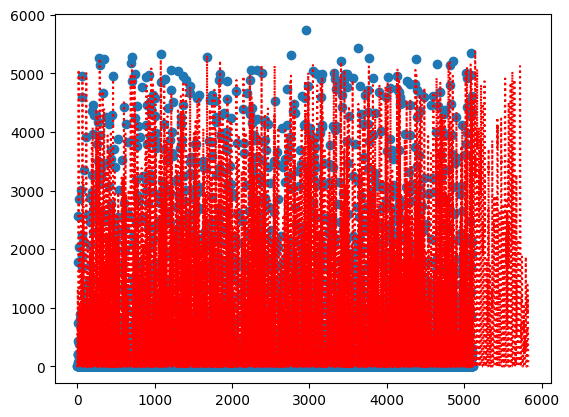

23/23 [==============================] - 0s 5ms/step


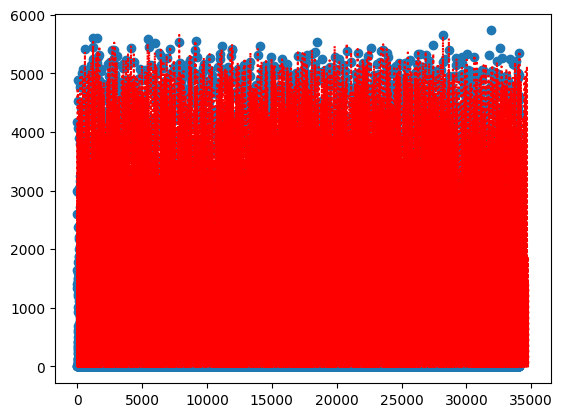

23/23 [==============================] - 0s 3ms/step


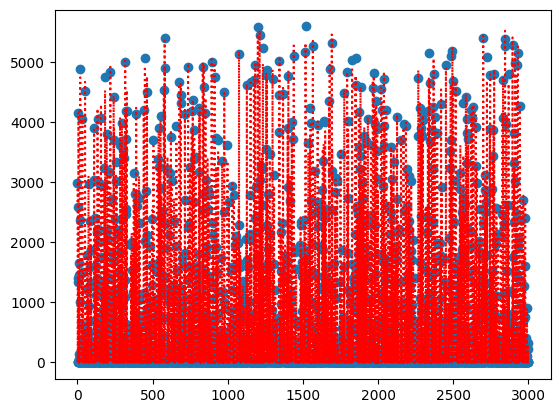

<Figure size 10000x1000 with 0 Axes>

In [153]:
#Convolutional-model
from keras import initializers

                          
#early_stop = EarlyStopping(monitor = 'val_accuracy', mode = 'max', verbose = 1, patience = 10)
#print(train_cnn__getitem__(0))
#TODO- SCNN (SMoothed concolutional neural network)
#      Create custom exponential smoothing layer!
#      Fix so saved models can be retrieved DONE (by removing timeseriesObjects)
#      add earlyStopping
#      Try removing TimeseriesObjects, and only use reshaped arrays. DONE(greate success)
#      Predict on test-data, and plot together with training-test-data to se how well they fit together (DONE) -they sort of fit

#OBSERVATIONS: (Not necessarily correct)
# - 10 epochs works well for C-block.
# - A-block needs more, e.g. 75.
# - B Block works well on low dimensionality, C&A needs higher.
def CNN(data):
    input_dim = len(data['train_x'][0])
    kernel_size = int((input_dim/2) -1)
    print("input dim: ", input_dim)
    print("kernel size: ", kernel_size)
    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, min_delta=0.01, restore_best_weights=True)
    checkpoint = tf.keras.callbacks.ModelCheckpoint('data/models/', monitor="val_loss", mode="min", save_best_only=True, verbose=1)
    #print('dim: ', input_dim)
    model = tf.keras.Sequential([
                #keras.layers.BatchNormalization(),
                keras.layers.Conv1D(8, kernel_size=kernel_size, activation='relu', input_shape=(input_dim, 1),
                                      kernel_initializer= initializers.glorot_uniform(seed=42),
                                      bias_initializer=initializers.Zeros()),#, padding='same'),
                keras.layers.BatchNormalization(),
                keras.layers.AveragePooling1D(pool_size=1, strides=1, padding='same'),
                #keras.layers.Conv1D(47, kernel_size=24, activation='relu', input_shape=(24,49,1), padding='same'),
                #keras.layers.Conv1D(47, kernel_size=24, activation='relu', input_shape=(24,49,1), padding='same'),
                keras.layers.Conv1D(8, kernel_size=kernel_size, activation='relu', input_shape=(input_dim,1),  
                                      kernel_initializer= initializers.glorot_uniform(seed=42),
                                      bias_initializer=initializers.Zeros()),#, padding='same'),),# padding='same'),
                #keras.layers.BatchNormalization(),
                #keras.layers.Conv1D(8, kernel_size=kernel_size, activation='relu', input_shape=(input_dim,1)),#, padding='same'),
                #keras.layers.BatchNormalization(),
                keras.layers.Flatten(),
                #keras.layers.Dropout(0.1),
                keras.layers.Dense(input_dim*150, activation='relu',
                                      kernel_initializer= initializers.glorot_uniform( seed=42),
                                      bias_initializer=initializers.Zeros()),
                keras.layers.Dense(input_dim, activation='relu',
                                      kernel_initializer= initializers.glorot_uniform( seed=42),
                                      bias_initializer=initializers.Zeros()), 
                keras.layers.Dense(input_dim, activation='relu',
                                       kernel_initializer= initializers.glorot_uniform( seed=42),
                                       bias_initializer=initializers.Zeros()),
                # keras.layers.Dense(input_dim, activation='relu',
                #                          kernel_initializer= initializers.glorot_uniform( seed=42),
                #                          bias_initializer=initializers.Zeros()),   
                # keras.layers.Dense(input_dim, activation='relu',
                #                         kernel_initializer= initializers.glorot_uniform( seed=42),
                #                         bias_initializer=initializers.Zeros()),
                # keras.layers.Dense(input_dim*10, activation='relu',
                #                       kernel_initializer= initializers.glorot_uniform( seed=42),
                #                       bias_initializer=initializers.Zeros()),  
                          
                #  keras.layers.Dense((input_dim*10), activation='relu', #####
                #                       kernel_initializer= initializers.glorot_uniform( seed=42),
                #                        bias_initializer=initializers.Zeros()),
                #  keras.layers.Dense(input_dim, activation='relu',
                #                        kernel_initializer= initializers.glorot_uniform( seed=42),
                #                        bias_initializer=initializers.Zeros()),
                #  keras.layers.Dense(input_dim*100, activation='relu',
                #                        kernel_initializer= initializers.glorot_uniform( seed=42),
                #                        bias_initializer=initializers.Zeros()),
                #  keras.layers.Dense(input_dim*10, activation='relu',
                #                        kernel_initializer= initializers.glorot_uniform( seed=42),
                #                        bias_initializer=initializers.Zeros()),
                #  keras.layers.Dense(input_dim, activation='relu',
                #                        kernel_initializer= initializers.glorot_uniform( seed=42),
                #                        bias_initializer=initializers.Zeros()),
                # keras.layers.Dense(input_dim, activation='relu',
                #                        kernel_initializer= initializers.glorot_uniform( seed=42),
                #                        bias_initializer=initializers.Zeros()),
                # keras.layers.Dense(input_dim, activation='relu',
                #                        kernel_initializer= initializers.glorot_uniform( seed=42),
                #                       bias_initializer=initializers.Zeros()), 
                                 
                #keras.layers.BatchNormalization(),
                
                keras.layers.Dense(1, activation='relu',
                                      kernel_initializer= initializers.glorot_uniform( seed=42),
                                      bias_initializer=initializers.Zeros()), 
                                     #kernel_regularizer=regularizers.L1L2(l1=0.1, l2=0.1),
                                     #bias_regularizer=regularizers.L1L2(l1=0.1, l2=0.1)) 
                ])
    model.compile(loss='mean_absolute_error',
                  optimizer=keras.optimizers.Adam(learning_rate=1e-4),
                  metrics=[keras.metrics.MeanAbsoluteError()])
    
    #model.fit(x=np.asarray(data['train_x']).astype('float32'), y=np.asarray(data['train_y']).astype('float32'), validation_data=(data['validation_x'], data['validation_y']), epochs=10, batch_size=128, callbacks=[checkpoint], shuffle=True)
    model.fit(x=X_A_tr_NN, y=Y_A_tr_NN, validation_data=(X_A_te_NN, Y_A_te_NN), epochs=1000, batch_size=24, callbacks=[checkpoint], shuffle=True)
    #model.fit(x=data['train_x'], y=data['train_y'], validation_data=(data['validation_x'], data['validation_y']), epochs=10000, batch_size=24, callbacks=[checkpoint], shuffle=True)
    #model.fit(x=data['train_x'], y=data['train_y'], epochs=15, batch_size=24, shuffle=True)
    model.load_weights('data/models/')
    acc = model.evaluate(data['test_x'], data['test_y'])
    print("ACCC", acc)
    return model

def plotCNN(model2, data, testData):
    predicted_y = model2.predict(data['test_x'])
    predicted_y_test = model2.predict(testData) 

    predicted_y = np.append(predicted_y, predicted_y_test)
    x = []
    #plt.plot(predicted_tr_y, linestyle = 'dotted', color='green')
    plt.plot(predicted_y, linestyle = 'dotted', color='red')
    #labels = np.append(data['train_y'], data['test_y'])
    for i in range(0,len( data['test_y'])):
        x.append(i)
    plt.scatter(x,  data['test_y'])
    plt.show()
    #visualizer(model1, file_format='png', view=False)

def plotAllCNN(model, data, testData):
    model.evaluate(data['test_x'], data['test_y'])
    predicted_tr_y = model.predict(data['train_x'])
    predicted_val_y = model.predict(data['validation_x'])
    predicted_te_y = model.predict(data['test_x'])
    predicted_y_test = model.predict(testData) 
    predicted_y = np.append(predicted_tr_y, predicted_val_y )
    predicted_y = np.append(predicted_y, predicted_te_y )
    predicted_y = np.append(predicted_y, predicted_y_test)
    x = []
    #plt.plot(predicted_tr_y, linestyle = 'dotted', color='green')
    plt.plot(predicted_y, linestyle = 'dotted', color='red')
    labels = np.append(data['train_y'], data['validation_y'])
    labels = np.append(labels, data['test_y'])
    for i in range(0,len(labels)):
        x.append(i)
    plt.scatter(x, labels)
    plt.show()
    #visualizer(model1, file_format='png', view=False)

def plotAllCNN2(model, data, testData):
    model.evaluate(data['test_x'], data['test_y'])
    predicted_tr_y = model.predict(data['train_x'])
    predicted_val_y = model.predict(data['validation_x'])
    predicted_te_y = model.predict(data['test_x'])
    predicted_y_test = model.predict(testData) 
    predicted_y = np.append(predicted_tr_y, predicted_val_y )
    predicted_y = np.append(predicted_y, predicted_te_y )
    predicted_y = np.append(predicted_y, predicted_y_test)
    x = []
    #plt.plot(predicted_tr_y, linestyle = 'dotted', color='green')
    plt.plot(predicted_y[:3000], linestyle = 'dotted', color='red')
    labels = np.append(data['train_y'], data['validation_y'])
    labels = np.append(labels, data['test_y'])
    for i in range(0,len(labels[:3000])):
        x.append(i)
    plt.scatter(x, labels[:3000])
    plt.figure(figsize=(100,10))
    plt.show()
    #visualizer(model1, file_format='png', view=False)


model2 = CNN(data_cnn)
#saveModel_KERAS(model2, "CNN.0.A")

plotCNN(model2, data_cnn, testData_A_cnn)
plotAllCNN(model2, data_cnn, testData_A_cnn)
plotAllCNN2(model2, data_cnn, testData_A_cnn)



In [155]:
saveModel_KERAS(model2, "CNN_145_64Features_A")

In [170]:
import matplotlib.pyplot as plt
 
history_dict = model2.history
print(history_dict)
loss_values = history_dict['train_loss']
val_loss_values = history_dict['val_loss']

 
epochs = range(1, len(loss_values) + 1)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot the loss vs Epochs
#
ax[1].plot(epochs, loss_values, 'bo', label='Training loss')
ax[1].plot(epochs, val_loss_values, 'b', label='Validation loss')
ax[1].set_title('Training & Validation Loss', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=16)
ax[1].set_ylabel('Loss', fontsize=16)
ax[1].legend()

AttributeError: 'History' object has no attribute 'keys'

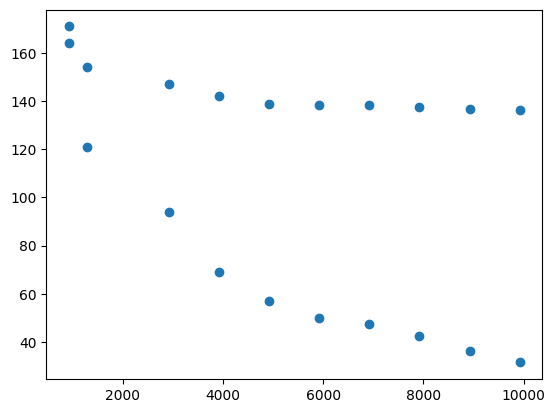

In [238]:
content = ['9923, 136.4482550',
           '9923, 31.4325314',
            '8923, 136.9067576',
            '8923, 36.3748582',
            '7923, 137.7124433',
            '7923, 42.6024574',
            '6923, 138.2449040',
            '6923, 47.3473497',
            '5923, 138.5679238',
            '5923, 50.0876101',
            '4923, 139',
            '4923, 57',
            '3923, 142',
            '3923, 69', 
            '2923, 147',
            '2923, 94', 
            '1293, 154',
            '1293, 121', 
            '923, 171',
            '923, 164' , ]

x = [float(i.split(',')[0]) for i in content]
y = [float(i.split(',')[1]) for i in content]

#print(x, y, z)
fig = plt.figure()
ax = plt.axes()

ax.scatter(x, y)



In [151]:
#ENSEMBLE-MODEL
def trainModels(data, data_cnn, cnn=0, transformers=0, feedforward=0, xgboost=0):
    models = []
    for i in range(cnn):
        models.append(CNN(data_cnn))
    for i in range(transformers):
        models.append(transformer(data_cnn))
    for i in range(feedforward):
        models.append(feedforwardNeuralNet(data))
    return models

def evaluateModels(models, data):
    preds = [m.evaluate(data['test_x'], data['test_y']) for m in models]
    print(preds)

#def removeModels(models, toRemove):

def ensemble(data, data_cnn, testData, num_c, num_t, num_f):
    models = trainModels(data, data_cnn, cnn=num_c, transformers=num_t, feedforward=num_f)
    predictions = np.array([m.predict(testData) for m in models])
    meanPrediction = predictions.mean(axis=0)
    return meanPrediction


models_B = trainModels(data, data_cnn, cnn=2)
evaluateModels(models_B, data_cnn)

    


input dim:  47
kernel size:  22
Epoch 1/15
740/742 [============================>.] - ETA: 0s - loss: 46.2333 - mean_absolute_error: 46.2333
Epoch 1: val_loss improved from inf to 25.91911, saving model to data/models\
INFO:tensorflow:Assets written to: data/models\assets


INFO:tensorflow:Assets written to: data/models\assets


742/742 [==============================] - 13s 11ms/step - loss: 46.2299 - mean_absolute_error: 46.2299 - val_loss: 25.9191 - val_mean_absolute_error: 25.9191
Epoch 2/15
735/742 [============================>.] - ETA: 0s - loss: 39.8326 - mean_absolute_error: 39.8326
Epoch 2: val_loss did not improve from 25.91911
742/742 [==============================] - 3s 4ms/step - loss: 39.7661 - mean_absolute_error: 39.7661 - val_loss: 28.6020 - val_mean_absolute_error: 28.6020
Epoch 3/15
731/742 [============================>.] - ETA: 0s - loss: 38.9386 - mean_absolute_error: 38.9386
Epoch 3: val_loss did not improve from 25.91911
742/742 [==============================] - 4s 5ms/step - loss: 38.8282 - mean_absolute_error: 38.8282 - val_loss: 31.9001 - val_mean_absolute_error: 31.9001
Epoch 4/15
735/742 [============================>.] - ETA: 0s - loss: 37.9855 - mean_absolute_error: 37.9855
Epoch 4: val_loss improved from 25.91911 to 24.36308, saving model to data/models\
INFO:tensorflow:Asset

INFO:tensorflow:Assets written to: data/models\assets


742/742 [==============================] - 9s 12ms/step - loss: 37.9325 - mean_absolute_error: 37.9325 - val_loss: 24.3631 - val_mean_absolute_error: 24.3631
Epoch 5/15
741/742 [============================>.] - ETA: 0s - loss: 36.7785 - mean_absolute_error: 36.7785
Epoch 5: val_loss did not improve from 24.36308
742/742 [==============================] - 3s 4ms/step - loss: 36.7888 - mean_absolute_error: 36.7888 - val_loss: 28.3556 - val_mean_absolute_error: 28.3556
Epoch 6/15
731/742 [============================>.] - ETA: 0s - loss: 37.2402 - mean_absolute_error: 37.2402
Epoch 6: val_loss did not improve from 24.36308
742/742 [==============================] - 3s 4ms/step - loss: 37.1736 - mean_absolute_error: 37.1736 - val_loss: 26.2089 - val_mean_absolute_error: 26.2089
Epoch 7/15
740/742 [============================>.] - ETA: 0s - loss: 36.3187 - mean_absolute_error: 36.3187
Epoch 7: val_loss did not improve from 24.36308
742/742 [==============================] - 3s 4ms/step - 

INFO:tensorflow:Assets written to: data/models\assets


742/742 [==============================] - 9s 12ms/step - loss: 36.8052 - mean_absolute_error: 36.8052 - val_loss: 24.0036 - val_mean_absolute_error: 24.0036
Epoch 9/15
736/742 [============================>.] - ETA: 0s - loss: 36.0958 - mean_absolute_error: 36.0958
Epoch 9: val_loss did not improve from 24.00358
742/742 [==============================] - 3s 4ms/step - loss: 36.0623 - mean_absolute_error: 36.0623 - val_loss: 27.8671 - val_mean_absolute_error: 27.8671
Epoch 10/15
738/742 [============================>.] - ETA: 0s - loss: 35.2052 - mean_absolute_error: 35.2052
Epoch 10: val_loss did not improve from 24.00358
742/742 [==============================] - 3s 4ms/step - loss: 35.1918 - mean_absolute_error: 35.1918 - val_loss: 28.0660 - val_mean_absolute_error: 28.0660
Epoch 11/15
738/742 [============================>.] - ETA: 0s - loss: 35.5411 - mean_absolute_error: 35.5411
Epoch 11: val_loss did not improve from 24.00358
742/742 [==============================] - 3s 4ms/ste

INFO:tensorflow:Assets written to: data/models\assets


742/742 [==============================] - 14s 12ms/step - loss: 128.1364 - mean_absolute_error: 128.1364 - val_loss: 70.2827 - val_mean_absolute_error: 70.2827
Epoch 2/15
742/742 [==============================] - ETA: 0s - loss: 128.1364 - mean_absolute_error: 128.1364
Epoch 2: val_loss did not improve from 70.28269
742/742 [==============================] - 3s 4ms/step - loss: 128.1364 - mean_absolute_error: 128.1364 - val_loss: 70.2827 - val_mean_absolute_error: 70.2827
Epoch 3/15
736/742 [============================>.] - ETA: 0s - loss: 128.2274 - mean_absolute_error: 128.2274
Epoch 3: val_loss did not improve from 70.28269
742/742 [==============================] - 3s 4ms/step - loss: 128.1365 - mean_absolute_error: 128.1365 - val_loss: 70.2827 - val_mean_absolute_error: 70.2827
Epoch 4/15
732/742 [============================>.] - ETA: 0s - loss: 128.1711 - mean_absolute_error: 128.1711
Epoch 4: val_loss did not improve from 70.28269
742/742 [==============================] - 3

KeyboardInterrupt: 

In [30]:
#create folder in working
from pathlib import Path
Path('data/preprocessed').mkdir(parents=True, exist_ok=True)

In [518]:
#LOSS_FUNCTIONS
def MAE(pred, true):
    mae = 0
    for i in range(len(pred)):
        mae += abs(pred[i]-true[i])
    mae = mae/len(pred)
    return mae

def weighted_average(preds, weights):
    

In [527]:
#Ensemble-test
cnn_model = retrieveModel_KERAS('CNN_112_2_47Features_A')
cnn_model_2 = retrieveModel_KERAS('CNN_113_47Features_A')
#cnn_model_3 = retrieveModel_KERAS('CNN_20_47Features_C')

ff_model = retrieveModel_KERAS('feedforward_118_47Features_A')

xgboost_model = retrieveModel_XGBOOST('xgboost_16_77Features_B')
xgboost_model_2 = retrieveModel_XGBOOST('xgboost_16_2_77Features_B')




#pred_cnn = cnn_model.predict(data_cnn['test_x'])
#pred_cnn_2 = cnn_model_2.predict(data_cnn['test_x'])
#pred_cnn_3 = cnn_model_3.predict(data_cnn['test_x'])

pred_xgboost = xgboost_model.predict(X_B_te_trees)
pred_xgboost_2 = xgboost_model_2.predict(X_B_te_trees)
#pred_ff = ff_model.predict(data['test_x'])


#print(pred_cnn)
print(pred_xgboost)
predictions = np.column_stack(( pred_xgboost, pred_xgboost_2))#pred_xgboost ))

meanPrediction = predictions.mean(axis=1)

print("mae: ", MAE(meanPrediction, data['test_y'])) 
#print(cnn_model.evaluate(data_cnn['test_x'], data_cnn['test_y']))

[-0.11119067 -0.07262281 -0.01343091 ...  0.03162842  0.02190794
  0.03258581]
mae:  16.73050800190895


In [24]:
#H2o AutoML
import h2o
from h2o.automl import H2OAutoML
h2o.init()

data_A = pd.concat([X_A, Y_A], ignore_index=True)

data_B = pd.concat([X_B, Y_B], ignore_index=True)

data_C = pd.concat([X_C, Y_C], ignore_index=True)


#CONVERT FROM PD_df to h2o_df:
hf_A = h2o.H2OFrame(data_A)

hf_B = h2o.H2OFrame(data_B)

hf_C = h2o.H2OFrame(data_C)


#Features as factor

# hf_A.apply(lambda x: x.asfactor())

# hf_B.apply(lambda x: x.asfactor())

# hf_C.apply(lambda x: x.asfactor())

#split x&y
a_x = hf_A.columns.remove("Y")
a_y = "Y"

b_x = hf_B.columns.remove("Y")
b_y = "Y"

c_x = hf_C.columns.remove("Y")
c_y = "Y"

# Running fit/training on train set with cross validation n=5
aml = H2OAutoML(max_models = 10, seed = 1)
aml.train(x = x, y = y, training_frame = hf_A)

lb = aml.leaderboard
# Showing best perforimg models
lb.head()


Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...


H2OStartupError: Cannot find Java. Please install the latest JRE from
http://docs.h2o.ai/h2o/latest-stable/h2o-docs/welcome.html#java-requirements

In [80]:
def replace_negative_value(x):
   return 0 if x < 0 else x

In [27]:
#SKLEARN stacked ensemble
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import RandomForestRegressor
estimators = [
    ('lr', retrieveModel_XGBOOST("CAT_142_64Features_A")),
    ('svr', retrieveModel_XGBOOST("xgboost_148_64Features_A"))
]
reg = StackingRegressor(
    estimators=estimators,
    # final_estimator=RandomForestRegressor(n_estimators=10,
    #                                       random_state=42)
)

reg.fit(X_A_tr_trees, Y_A_tr_trees).score(X_A_te_trees, Y_A_te_trees)

0:	learn: 627.3246630	total: 576ms	remaining: 36m 27s
1:	learn: 622.0332405	total: 981ms	remaining: 31m 3s
2:	learn: 617.7967093	total: 1.39s	remaining: 29m 19s
3:	learn: 613.3774350	total: 1.82s	remaining: 28m 52s
4:	learn: 608.2216988	total: 2.32s	remaining: 29m 18s
5:	learn: 603.1047504	total: 2.81s	remaining: 29m 38s
6:	learn: 598.3519396	total: 3.27s	remaining: 29m 33s
7:	learn: 593.2703345	total: 3.76s	remaining: 29m 43s
8:	learn: 588.8744604	total: 4.26s	remaining: 29m 55s
9:	learn: 585.4140076	total: 4.74s	remaining: 29m 54s
10:	learn: 580.7423953	total: 5.29s	remaining: 30m 20s
11:	learn: 575.8196818	total: 5.76s	remaining: 30m 19s
12:	learn: 571.1927134	total: 6.2s	remaining: 30m 6s
13:	learn: 566.9833258	total: 6.65s	remaining: 29m 59s
14:	learn: 562.5830672	total: 7.08s	remaining: 29m 45s
15:	learn: 558.2828970	total: 7.51s	remaining: 29m 36s
16:	learn: 554.3988655	total: 7.94s	remaining: 29m 27s
17:	learn: 550.2318425	total: 8.36s	remaining: 29m 17s
18:	learn: 545.8995881	

KeyboardInterrupt: 

In [ ]:
pred_A_stack = reg.predict(testData_A)


In [ ]:
#TODO:
#   submit stacked ensemble (Sklearn-stacked)
#Try AutoML-stacked-ensemble
#TREN BESTE MED 

In [107]:
#ENSEMBLE-SUBMISSION
def ensembleSubmission(dict_cnn, dict_xg, dict_ff):
    
    weights = {'A': [0.9, 0.1], 'B': [0.3, 0.7], 'C': [0.6, 0.4]}
    sample_submission = pd.read_csv('data/data/sample_submission.csv')

    #A  
    models_cnn = [retrieveModel_KERAS(m).predict(testData_A_cnn) for m in dict_cnn['A']]
    model_xgBoost = [retrieveModel_XGBOOST(m).predict(testData_A_tree) for m in dict_xg['A']]
    models_ff = [retrieveModel_KERAS(m).predict(testData_A) for m in dict_ff['A']]
    models_A = models_cnn
    models_A.extend(model_xgBoost)
    models_A.extend(models_ff)
    preds_A = np.column_stack((m for m in models_A))

    
    # print(weights)
    preds = []

    for i in range(len(preds_A)):
        preds.append((preds_A[i][0]*weights['A'][0] + preds_A[i][1]*weights['A'][1]))
    weightedMeanPrediction_A = np.array(preds)
    meanPrediction_A = preds_A.mean(axis=1)

    final_pred_A = [[p] for p in weightedMeanPrediction_A]
    #final_pred_A = [[p] for p in meanPrediction_A]
    for m in dict_xg['B']:
        retrieveModel_XGBOOST(m)

    #B 
    models_cnn = [retrieveModel_KERAS(m).predict(testData_B_cnn) for m in dict_cnn['B']]
    model_xgBoost = [retrieveModel_XGBOOST(m).predict(testData_B_tree) for m in dict_xg['B']]

    models_ff = [retrieveModel_KERAS(m).predict(testData_B) for m in dict_ff['B']]
    models_B = models_cnn
    models_B.extend(model_xgBoost)
    models_B.extend(models_ff)
    preds_B = np.column_stack((m for m in models_B))

    preds = []
    for i in range(len(preds_B)):
        preds.append((preds_B[i][0]*weights['B'][0] + preds_B[i][1]*weights['B'][1]))
    
    weightedMeanPrediction_B = np.array(preds)
    meanPrediction_B = preds_B.mean(axis=1)

    final_pred_B = [[p] for p in weightedMeanPrediction_B]
    #final_pred_B = [[p] for p in meanPrediction_B]

    #C 
    models_cnn = [retrieveModel_KERAS(m).predict(testData_C_cnn) for m in dict_cnn['C']]
    model_xgBoost = [retrieveModel_XGBOOST(m).predict(testData_C_tree) for m in dict_xg['C']]
    models_ff = [retrieveModel_KERAS(m).predict(testData_C) for m in dict_ff['C']]
    models_C = models_cnn
    models_C.extend(model_xgBoost)
    models_C.extend(models_ff)
    preds_C = np.column_stack((m for m in models_C))

    preds = []
    for i in range(len(preds_C)):
        preds.append((preds_C[i][0]*weights['C'][0] + preds_C[i][1]*weights['C'][1]))

    weightedMeanPrediction_C = np.array(preds)
    meanPrediction_C = preds_C.mean(axis=1)

    final_pred_C = [[p] for p in weightedMeanPrediction_C]
    #final_pred_C = [[p] for p in meanPrediction_C]


    allPreds = np.append(final_pred_A, final_pred_B, axis=0)
    allPreds = np.append(allPreds, final_pred_C, axis=0)

    #Replace negative values with zero, as energy production cannot be negative.
    #replace_func = np.vectorize(replace_negative_value)
    #allPreds = replace_func(allPreds)
    allPreds[allPreds<0] = 0

    print("len: ", len(allPreds))
    allPredictions = pd.DataFrame(allPreds, columns=['prediction'])

    sample_submission['prediction'] = allPredictions['prediction']
    for elem in sample_submission['prediction']:
        print(elem)
    

    #print(sample_submission['prediction'])
    savePred(sample_submission, "pred_67")
{'A': ['CAT_106_70Features_A', ], 'B': ['CAT_16_70Features_B'], 'C': ['CAT_20_70Features_C', ]}
ensembleSubmission({'A': [], 'B': [], 'C': []},
                   {'A': ['CAT_142_64Features_A', 'xgboost_148_64Features_A'], 'B': ['CAT_22_64Features_B', 'xgboost_21_2_64Features_B'], 'C': ['CAT_19_64Features_C', 'xgboost_17_2_64Features_C']},
                   {'A': [], 'B': [], 'C': []})






C:\Users\matse\AppData\Local\Temp\ipykernel_19524\4268399800.py:14: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  preds_A = np.column_stack((m for m in models_A))
C:\Users\matse\AppData\Local\Temp\ipykernel_19524\4268399800.py:38: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  preds_B = np.column_stack((m for m in models_B))


len:  2160
4.398651176906649
3.5107839512940844
0.41782093037759566
28.769114643708313
339.31933265846425
750.9154612628753
1606.1422073577808
2283.0162751857856
2500.1022782642294
2666.6228759823734
2799.4895828462754
2717.1519292579283
2422.663159708905
2475.39858406334
2362.9948642107743
1680.7320777843424
1053.7201082170736
554.9962024019139
203.5061904537633
22.81733278761785
0.0
1.7262415218019738
0.0
0.0
0.0
1.8526242903528085
4.381201915351097
192.35778680112998
805.9832001848591
1551.0058671952602
2207.4411395732795
3065.980572441719
4052.6176815274334
4344.365195380229
4299.951813668036
4014.6546067216586
3735.844818226531
3480.48083986045
3465.0790651411476
2851.142689376071
1874.8922195829987
846.1686927460228
348.7553911655624
77.41128581588055
4.928843798844461
1.2521708557670612
0.0
1.6688032062789824
0.0
0.0
0.0
264.5701153966451
746.3421618654614
1666.380796582911
2878.9483977614273
3732.61966262812
4269.903616828047
4621.9977473564595
4670.4302565055
4421.349267550381

C:\Users\matse\AppData\Local\Temp\ipykernel_19524\4268399800.py:57: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  preds_C = np.column_stack((m for m in models_C))


In [32]:
#Models used on prediction

#PRED_0
#CNN_122_A, CNN_28_B, CNN_25_C -- Data: 1

#PRED 1
#CNN_124_3_A, CNN_20_B, CNN_24_C -- Data: 1

#PRED 2
#CNN_125_T_A, CNN_18_T_B, CNN_24_C -- Data: 1

#PRED 3
#CNN_126_T_A, CNN_18_T_B, CNN_24_C <-- BEST YET, --> CNN_126_T_A is better than CNN_125_T_A -- Data:1

#PRED 4
#CNN_128__T_A, CNN_24__T_B, CNN_24__T_C -- Data: 2

#PRED 5
#CNN_123_D4_A, CNN_17_D4_B, CNN_24_D4_c --Data: 4

#PRED 6
#CNN_

#PRED 7

#PRED 8
#CNN_130_D4_A, CNN_17_D4_B, CNN_24_D4_C -- Data: 4 --> BEST YET

#PRED 9
#CNN_130_D4_A, CNN_21_D4_B, CNN_24_D4_C -- Data: 4

#PRED 10
#CNN_128_D5_A, CNN_17_D4_B, CNN_24_D4_C --> BEST YET --> CNN_128_D5_A is best A-model.

#PRED 11
#CNN_123_D5_A, CNN_17_D4_B, CNN_24_D4_C 

#PRED 12
#CNN_123_D5_A, CNN_19_D5_B, CNN_24_D5_C 

#PRED 13
#CNN_128_D5_A, CNN_19_D5_B, CNN_24_2_D5_C <-- CNN_24_2_D5_C er bedre enn CNN_24_D5_C

#PRED 14
# CNN_122_A_D5_A, CNN_29_B_D5, CNN__C32_D5_ C 

#PRED 15
#ANN_131_A, ANN_23_B, ANN_23_C

#PRED 16
#CNN_127_D6_A, CNN_39_BB, CNN_21_CC < -- BEST YET (Mål enkelte modeller opp mot disse ved evt utbytte) (CNN_39 <- egt 18 i mae..)

#PRED 17
#CNN_127_D6_A, CNN_39_BB, ANN_23_C

#PRED 18
#CNN_117_AA, CNN_shift2_BB, CNN_6_CC <-- Prøv med CNN_21_CC istedenfor her. CNN_shift2_BB skal være bedre enn CNN_39_BB & CNN_117_AA skal være bedre enn CNN_127_D6_A

#PRED 19
#CNN_117_AA, CNN_19_CC, CNN_19_CC

#PRED 20
#CNN_117_AA, CNN_40_BB, CNN_19_CC

#PRED 21
#CNN_117_AA, CNN_16_BB, CNN_19_CC

#PRED 22
#CNN_116_AAA, CNN_17_BBB, CNN_22_CCC <--Kanskje

#PRED 24
#CNN_115_A_simple, CNN_17_B_simple, CNN_22_C_simple

#PRED 25
#29Features

#PRED 26
#CNN_113_47Features_A, CNN_16_47Features_B, CNN_19_47Features_C <-- Normalized values wrong so hirrible results on testData..

#PRED 27
#CNN_115_43Features_A, CNN_16_43Features_B, CNN_20_43Features_C <-- BEST YET

#PRED 28
#CNN_113_47Features_A, CNN_16_47Features_B, CNN_20_47Features_C

#PRED 29
#CNN_113_47Features_A, CNN_16_47Features_B, CNN_21_47Features_C

#PRED 30
#CNN_113_47Features_A, CNN_16_2_47Features_B, CNN_18_47Features_C

#PRED 31
#CNN_113_47Features_A, CNN_16_47Features_B, CNN_18_47Features_C

#PRED 36
#Ensemble av: (CNN_113_47Features_A, CNN_112_47Features_A, xgboost_113_47Features_A), (CNN_15_47Features_B, xgboost_17_47Features_B), (CNN_18_47Features_C, xgboost_17_47Features_C)

#PRED 40
#Ensemble av: (CNN_112_47Features_A, xgboost_110.4_47Features_A), (CNN_15_47Features_B, xgboost_16.985_47Features_B), (CNN_18_47Features_C, xgboost_17_47Features_C)

#PRED 41
#Ensemble av: (CNN_113_47Features_A, CNN_112_47Features_A, xgboost_114BOTH_47Features_A), (CNN_15_47Features_B, xgboost_17_47Features_B), (CNN_18_47Features_C, xgboost_17_47Features_C)

#PRED 42
#Ensemble av: (CNN_113_47Features_A, CNN_112_47Features_A, xgboost_114BOTH_ALLDATA_47Features_A), (CNN_15_47Features_B, xgboost_17_47Features_B), (CNN_18_47Features_C, xgboost_17_47Features_C)

#PRED 43
#Ensemble av: (CNN_113_47Features_A, CNN_112_47Features_A, xgboost_114BOTH_47Features_A), (CNN_15_47Features_B, xgboost_17BOTH_47Features_B), (CNN_18_47Features_C, xgboost_19.5BOTH_47Features_C)

#PRED 44
#Ensemble av: (xgboost_114BOTH_47Features_A), (xgboost_17BOTH_47Features_B), (xgboost_19.5BOTH_47Features_C)

#PRED 45: ['CNN_106_67Features_A'], 'B': ['CNN_16_67Features_B'], 'C': ['CNN_19_67Features_C']

#PRED 46: {'A': ['xgboost_110_2_77Features_A'], 'B': ['xgboost_16_77Features_B'], 'C': ['xgboost_19_77Features_C']}

#PRED 47: {'A': ['CNN_108_77Features_A'], 'B': ['CNN_16_77Features_B'], 'C': ['CNN_20_77Features_C']}

#PRED 48:  {'A': ['CAT_106_70Features_A'], 'B': ['CAT_16_70Features_B'], 'C': ['CAT_20_70Features_C']}

#PRED 49:   {'A': ['xgboost_111_70Features_A'], 'B': ['xgboost_16BOTH_70Features_B'], 'C': ['xgboost_18BOTH_70Features_C']},

#PRED 50: average ensemble of 48%49

#PRED 52:  weighted average ensemble of 48%49 

#PRED 53: {'A': ['xgboost_148_64Features_A'], 'B': ['xgboost_21_64Features_B'], 'C': ['xgboost_17_64Features_C']

#PRED 54: {'A': ['xgboost_148_64Features_A'], 'B': ['xgboost_21_2_64Features_B'], 'C': ['xgboost_17_2_64Features_C']

#PRED 56:  {'A': ['CAT_142_64Features_A'], 'B': ['xgboost_21_2_64Features_B'], 'C': ['CAT_17_2_64Features_C']}
#PRED 57 {'A': ['CAT_136_64Features_A'], 'B': ['xgboost_21_2_64Features_B'], 'C': ['xgboost_17_2_64Features_C']}

#PRED 58:  {'A': ['CAT_142_64Features_A'], 'B': ['CAT_24_64Features_B'], 'C': ['CAT_19_64Features_C']}

#PRED 59:  {'A': ['CAT_142_64Features_A'], 'B': ['xgboost_21_2_64Features_B'], 'C': ['CAT_19_64Features_C']}

#PRED 62:  {'A': ['CAT_142_64Features_A', 'xgboost_148_64Features_A'], 'B': ['CAT_22_64Features_B', 'xgboost_21_2_64Features_B'], 'C': ['CAT_19_64Features_C', 'xgboost_17_2_64Features_C']},


#TODO: PRED 41 vs. PRED 36 viser at jevnere score mellom train-test gir bedre resultater. DONE 
#1. --> Submit med 114BOTH_ALLDATA_A for å videre sjekke om trening med all data til slutt gir enda bedre resultater.
#2. --> SUbmit med jevne modeller fra B&C også. ALLDATA dersom steget over gir utslag. DONE
#3. --> Evt. submit med kun nåværende xgboost-modeller. DONE
#4. --> Submit med kombo av flere xgboostModeller(?) + CNN...
#4. --> Evt- forbedre CNN-modellene med samme metodikk som i 1.& 2.




#A: CAT MUCH BETTER
#B: XGBOOST MID BETTER
#C: CAT SLIGHTLY BETTER

In [107]:
a = retrieveModel_XGBOOST('CAT_16_70Features_B')
a.describe()

AttributeError: 'CatBoostRegressor' object has no attribute 'describe'

In [542]:
saveModel_KERAS( model2, 'CNN_20_77Features_C')

Model: "sequential_57"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_50 (Conv1D)          (None, 26, 8)             184       
                                                                 
 batch_normalization_56 (Ba  (None, 26, 8)             32        
 tchNormalization)                                               
                                                                 
 average_pooling1d_25 (Aver  (None, 26, 8)             0         
 agePooling1D)                                                   
                                                                 
 conv1d_51 (Conv1D)          (None, 5, 8)              1416      
                                                                 
 batch_normalization_57 (Ba  (None, 5, 8)              32        
 tchNormalization)                                               
                                                     

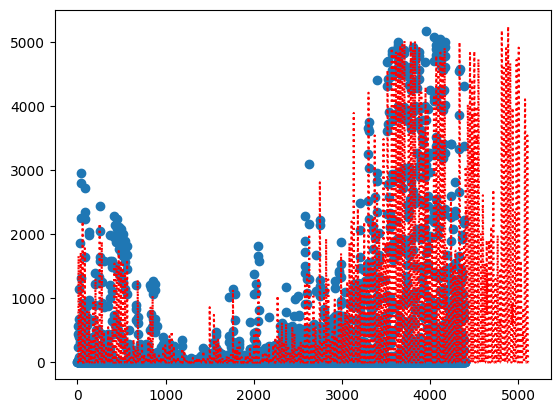

23/23 [==============================] - 0s 2ms/step


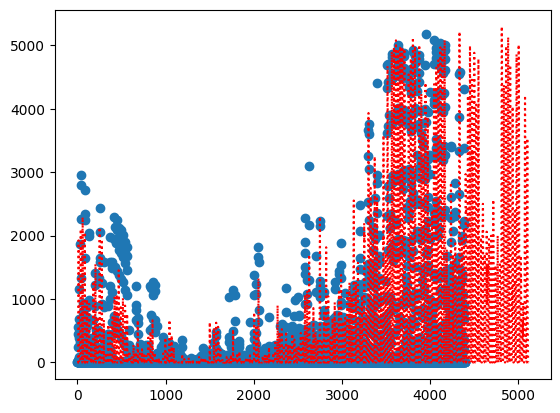

23/23 [==============================] - 0s 2ms/step


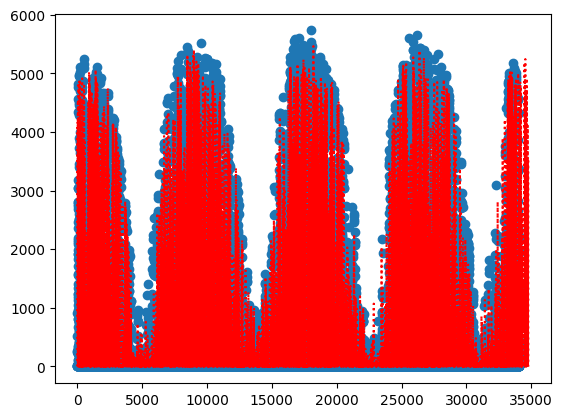

23/23 [==============================] - 0s 2ms/step


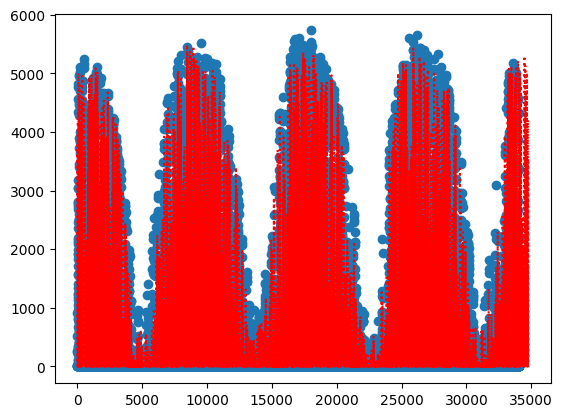

23/23 [==============================] - 0s 3ms/step


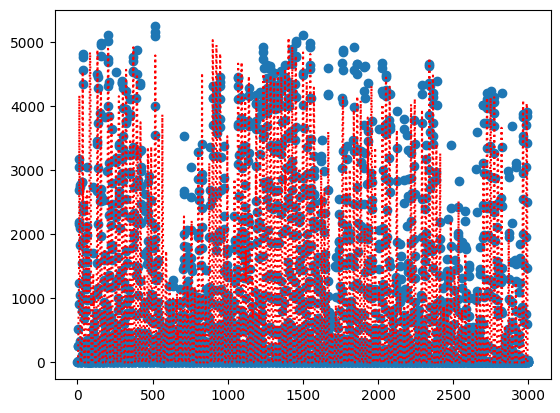

<Figure size 10000x1000 with 0 Axes>

23/23 [==============================] - 0s 2ms/step


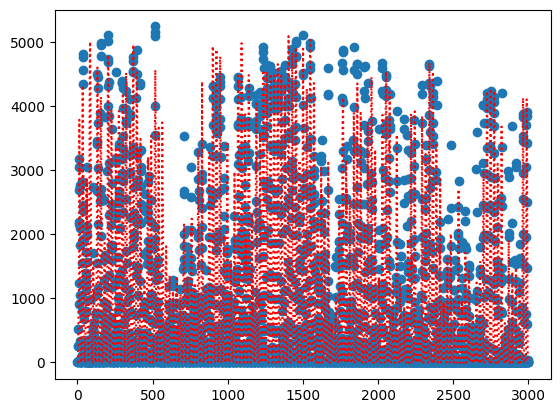

<Figure size 10000x1000 with 0 Axes>

In [389]:
#A SWITCH
modelRetrieved = retrieveModel_KERAS('CNN_112_47Features_A')
modelRetrieved.summary()
print("hp: ", modelRetrieved.get_config())
#plotANN(modelRetrieved, data, testData_A)
#plotAllANN(modelRetrieved, data, testData_A)
#plotAllANN2(modelRetrieved, data, testData_A)
#modelRetrieved.predict(testData_C)
#modelRetrieved.predict(testData_A)
#print(modelRetrieved.summary())
modelRetrieved1 = retrieveModel_KERAS('CNN_112_2_47Features_A')
modelRetrieved1.summary()

# data = pandasToNumpy(train_x, validation_x, test_x, train_y, validation_y, test_y)
#saveModel(modelRetrieved, 'CNN_125_T_A' )
#saveModel(modelRetrieved1, 'CNN_126_T_A' )
print("TEST")
modelRetrieved.evaluate(data_cnn['test_x'], data_cnn['test_y'])
modelRetrieved1.evaluate(data_cnn['test_x'], data_cnn['test_y'])
print("---------------")
print("TRAIN")
modelRetrieved.evaluate(data_cnn['train_x'], data_cnn['train_y'])
modelRetrieved1.evaluate(data_cnn['train_x'], data_cnn['train_y'])
print("---------------")
print("VAL")
modelRetrieved.evaluate(data_cnn['validation_x'], data_cnn['validation_y'])
modelRetrieved1.evaluate(data_cnn['validation_x'], data_cnn['validation_y'])
#modelRetrieved1.evaluate(data['test_x'], data['test_y'])
plotCNN(modelRetrieved, data_cnn, testData_A_cnn)
plotCNN(modelRetrieved1, data_cnn, testData_A_cnn)
plotAllCNN(modelRetrieved, data_cnn, testData_A_cnn)
plotAllCNN(modelRetrieved1, data_cnn, testData_A_cnn)
plotAllCNN2(modelRetrieved, data_cnn, testData_A_cnn)
plotAllCNN2(modelRetrieved1, data_cnn, testData_A_cnn)

TEST
112/112 [==============================] - 1s 2ms/step - loss: 15.6785 - mean_absolute_error: 15.6785
---------------
TRAIN
557/557 [==============================] - 1s 2ms/step - loss: 32.6586 - mean_absolute_error: 32.6586
---------------
VAL
23/23 [==============================] - 0s 2ms/step


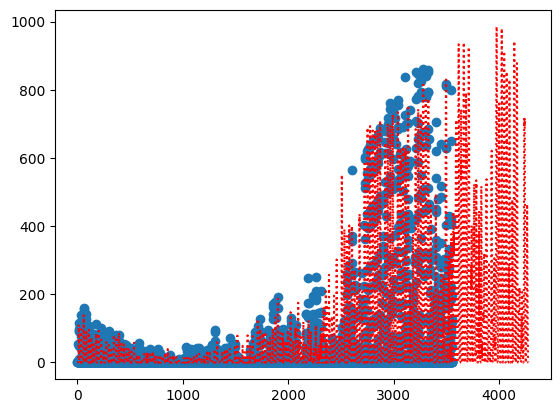

23/23 [==============================] - 0s 2ms/step


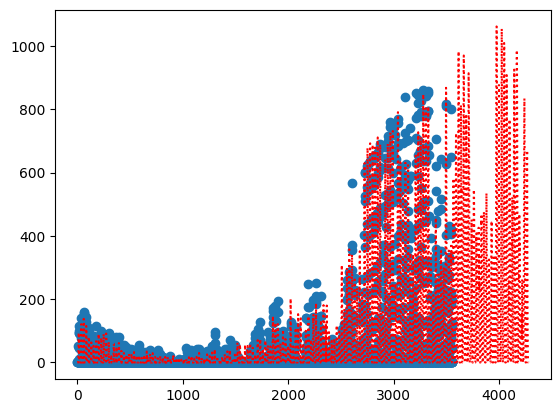

23/23 [==============================] - 0s 2ms/step


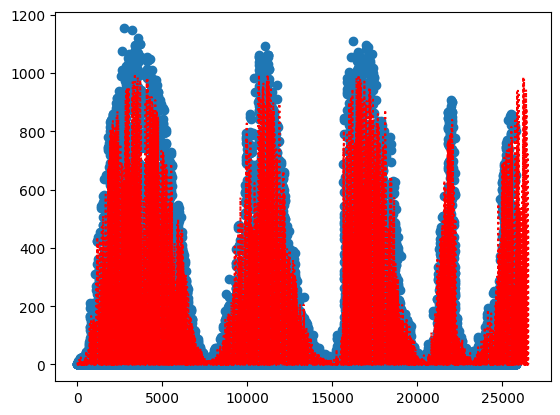

23/23 [==============================] - 0s 2ms/step


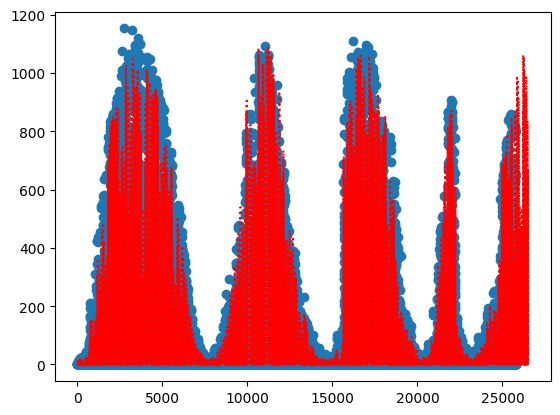

23/23 [==============================] - 0s 2ms/step


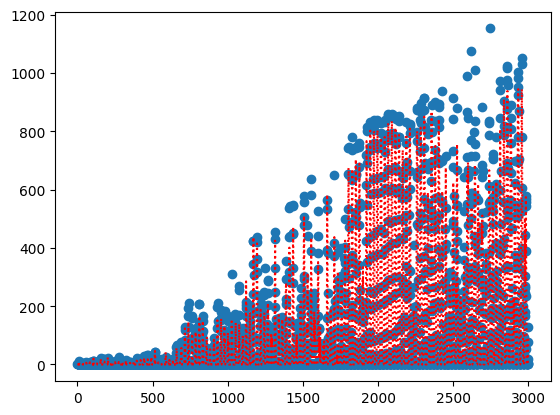

<Figure size 10000x1000 with 0 Axes>

23/23 [==============================] - 0s 2ms/step


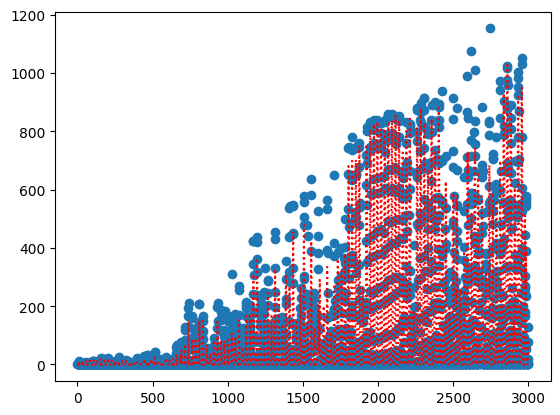

<Figure size 10000x1000 with 0 Axes>

In [398]:
#B SWITCH
modelRetrieved = retrieveModel_KERAS('CNN_18_47Features_B')
#plotANN(modelRetrieved, data, testData_A)
#plotAllANN(modelRetrieved, data, testData_A)
#plotAllANN2(modelRetrieved, data, testData_A)
#modelRetrieved.predict(testData_C)
#modelRetrieved.predict(testData_A)
#print(modelRetrieved.summary())
modelRetrieved1 = retrieveModel_KERAS('CNN_15_47Features_B')
data4 = retriveData('B_4')
#print("D: ", data4)
# data = pandasToNumpy(train_x, validation_x, test_x, train_y, validation_y, test_y)
#saveModel(modelRetrieved, 'CNN_125_T_A' )
#saveModel(modelRetrieved1, 'CNN_126_T_A' )
#print(data['test_x'][0])
print("TEST")
modelRetrieved.evaluate(data_cnn['test_x'], data_cnn['test_y'])
modelRetrieved1.evaluate(data_cnn['test_x'], data_cnn['test_y'])
print("---------------")
print("TRAIN")
modelRetrieved.evaluate(data_cnn['train_x'], data_cnn['train_y'])
modelRetrieved1.evaluate(data_cnn['train_x'], data_cnn['train_y'])
print("---------------")
print("VAL")
modelRetrieved.evaluate(data_cnn['validation_x'], data_cnn['validation_y'])
modelRetrieved1.evaluate(data_cnn['validation_x'], data_cnn['validation_y'])
#modelRetrieved1.evaluate(data['test_x'], data['test_y'])
plotCNN(modelRetrieved, data_cnn, testData_B_cnn)
plotCNN(modelRetrieved1, data_cnn, testData_B_cnn)
plotAllCNN(modelRetrieved, data_cnn, testData_B_cnn)
plotAllCNN(modelRetrieved1, data_cnn, testData_B_cnn)
plotAllCNN2(modelRetrieved, data_cnn, testData_B_cnn)
plotAllCNN2(modelRetrieved1, data_cnn, testData_B_cnn)


D:         absolute_humidity_2m:gm3  air_density_2m:kgm3  ceiling_height_agl:m  \
0                         5.525              1.23975             1200.6750   
1                         5.425              1.23975             1131.4249   
2                         5.400              1.23850             1061.0000   
3                         5.350              1.23975             1021.1500   
4                         5.675              1.23750             1033.7000   
...                         ...                  ...                   ...   
33538                     8.350              1.19800             3640.1250   
33539                     8.525              1.20075             3351.1000   
33540                     8.800              1.20375             2753.0250   
33541                     9.000              1.20600             2204.5000   
33542                     9.025              1.20700             2015.1000   

       clear_sky_energy_1h:J  clear_sky_rad:W  cloud_base_a

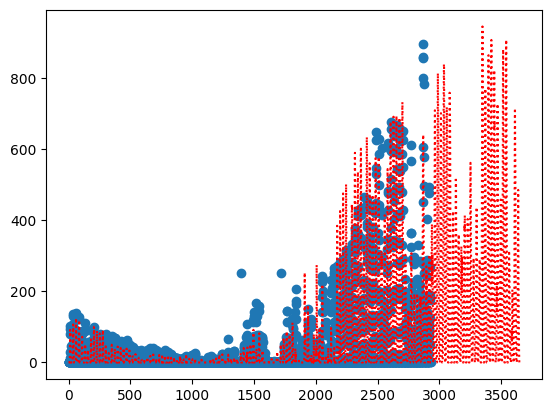

23/23 [==============================] - 0s 2ms/step


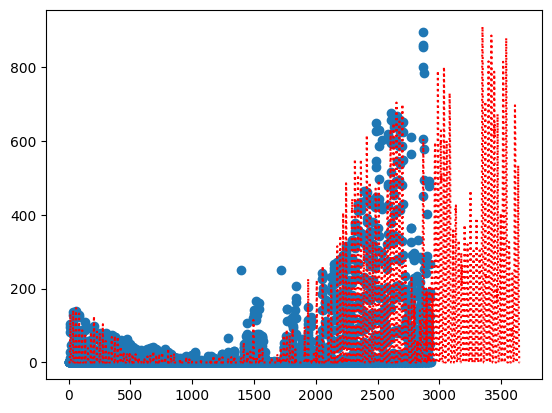

23/23 [==============================] - 0s 2ms/step


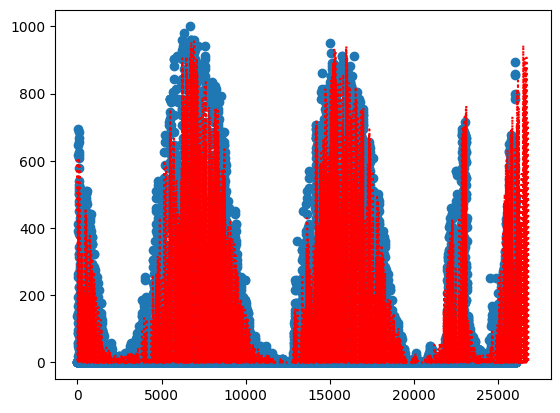

23/23 [==============================] - 0s 2ms/step


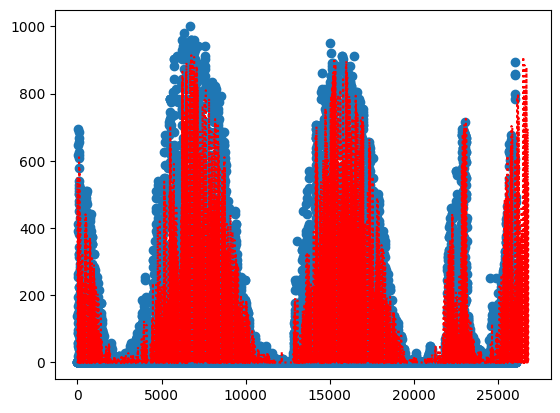

In [410]:
#C SWITCH
modelRetrieved = retrieveModel_KERAS('CNN_19_47Features_C')
#plotANN(modelRetrieved, data, testData_A)
#plotAllANN(modelRetrieved, data, testData_A)
#plotAllANN2(modelRetrieved, data, testData_A)
#modelRetrieved.predict(testData_C)
#modelRetrieved.predict(testData_A)
#print(modelRetrieved.summary())
modelRetrieved1 = retrieveModel_KERAS('CNN_18_47Features_C')
data4 = retriveData('B_4')
print("D: ", data4)
# data = pandasToNumpy(train_x, validation_x, test_x, train_y, validation_y, test_y)
#saveModel(modelRetrieved, 'CNN_125_T_A' )
#saveModel(modelRetrieved1, 'CNN_126_T_A' )
print(data['test_x'][0])
print("TEST")
modelRetrieved.evaluate(data_cnn['test_x'], data_cnn['test_y'])
modelRetrieved1.evaluate(data_cnn['test_x'], data_cnn['test_y'])
print("---------------")
print("TRAIN")
modelRetrieved.evaluate(data_cnn['train_x'], data_cnn['train_y'])
modelRetrieved1.evaluate(data_cnn['train_x'], data_cnn['train_y'])
print("---------------")
print("VAL")
modelRetrieved.evaluate(data_cnn['validation_x'], data_cnn['validation_y'])
modelRetrieved1.evaluate(data_cnn['validation_x'], data_cnn['validation_y'])
#modelRetrieved1.evaluate(data['test_x'], data['test_y'])
plotCNN(modelRetrieved, data_cnn, testData_C_cnn)
plotCNN(modelRetrieved1, data_cnn, testData_C_cnn)
plotAllCNN(modelRetrieved, data_cnn, testData_C_cnn)
plotAllCNN(modelRetrieved1, data_cnn, testData_C_cnn)

In [505]:
sample_submission = pd.read_csv('data/data/sample_submission.csv')

#Test-predicitons
#A
model_A = retrieveModel_KERAS('CNN_113_47Features_A')
test_A = model_A.predict(testData_A_cnn)
#
#B
model_B = retrieveModel_KERAS('CNN_16_3_47Features_B')
test_B = model_B.predict(testData_B_cnn)
#
#C
model_C = retrieveModel_KERAS('CNN_18_47Features_C')
test_C = model_C.predict(testData_C_cnn)
#print(test_A)
allPreds = np.append(test_A, test_B, axis=0)
allPreds = np.append(allPreds, test_C, axis=0)

print("len: ", len(allPreds))
allPredictions = pd.DataFrame(allPreds, columns=['prediction'])

sample_submission['prediction'] = allPredictions['prediction']


#savePred(sample_submission, "pred_32")

23/23 [==============================] - 0s 3ms/step
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]

In [ ]:
def exploreData(data, labels):
    x_train_observed = data[0] #Observed weather
    train_targets = labels #observed power measure for each hour
    x_test_estimated = data[1] #Estimated weather (testData) --> but no targets are available for these dates?
    x_train_estimated = data[2] #Estimated weather ()
    
    print(x_train_estimated)
    print("------------------")
    print("------------------")
    #print((x_train_observed)) #2019-06-02 22:00:00 <--> 2022-10-21 01:00:00
    print("------------------")
    print("------------------")
    #print(x_train_estimated) #2022-10-28 22:00:00 <--> 2023-04-30 23:00:00
    print("------------------")
    print("------------------")        
    print("TT: ", (train_targets))

#exploreData(weather_A1, energy_A)

def plotData(A, B, C):
    # Plotting a single feature
    fig, axs = plt.subplots(3, 1, figsize=(30, 10), sharex=True)
    feature_name = 'snow_density:kgm3'
    weather_A1[0][['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[0], title='Train/Test A', color='red')
    weather_A1[2][['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[0], title='Train/Test A', color='blue')
    weather_A1[1][['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[0], title='Train/Test  A', color='green')
    
    weather_B1[0][['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[1], title='Train/Test B', color='red')
    weather_B1[2][['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[1], title='Train/Test B', color='blue')
    weather_B1[1][['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[1], title='Train/Test  B', color='green')
    
    weather_C1[0][['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[2], title='Train/Test C', color='red')
    weather_C1[2][['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[2], title='Train/Test C', color='blue')
    weather_C1[1][['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[2], title='Train/Test  C', color='green')

    
def plotLabels(A, B, C):
    fig, axs = plt.subplots(3, 1, figsize=(30, 10), sharex=True)
    #feature_name = 'snow_density:kgm3'
    A[1][['time','pv_measurement']].set_index('time').plot(ax=axs[0], title='Train/Test A', color='red')
    #A[3][['time','pv_measurement']].set_index('date_forecast').plot(ax=axs[0], title='Train/Test A', color='blue')
    #A[2][['time','pv_measurement']].set_index('date_forecast').plot(ax=axs[0], title='Train/Test  A', color='green')
    
    B[1][['time','pv_measurement']].set_index('time').plot(ax=axs[1], title='Train/Test A', color='red')
   # B[3][['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[1], title='Train/Test B', color='blue')
   # B[2][['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[1], title='Train/Test  B', color='green')
    
    C[1][['time','pv_measurement']].set_index('time').plot(ax=axs[2], title='Train/Test A', color='red')
   # C[3][['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[2], title='Train/Test C', color='blue')
   # C[2][['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[2], title='Train/Test  C', color='green')

    
#plotData(weather_A, weather_B, weather_C)
#plotLabels(A1, B1, C1)
#ploaData(B)
    
    
    
    